In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import copy
import emcee
import corner

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import medfilt

from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

# load EIT

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2463, 3)
(91883, 7)


In [5]:
metadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(np.shape(metadata))
print(metadata.colnames)


(91883,)
['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS', 'HI-LAT-DEG', 'HI-LON-DEG']


In [6]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

148114320263.0 m
0.9900830778535941 AU
149597870700.0


In [7]:
# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]
metadata = metadata[postCommissioningMask]

correctFilterMask = (metadata['FILTER'] != 'Al_sup')

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [8]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
     ...        ...      ...    ...         ...
heaterOn 2014/12/11    13:00  199.0 2457003.042
heaterOn  2015/06/4    03:00  188.0 2457177.625
heaterOn  2015/12/3    00:00  204.0   2457359.5
heaterOn 2016/05/26    08:45  185.0 2457534.865
heaterOn 2017/05/13    03:23  296.0 2457886.641
heaterOn  2018/05/4    04:00  238.0 2458242.667
heaterOn 2019/04/24    00:00  288.0   2458597.5
heaterOn 2020/04/16    00:00  336.0   24

In [9]:
# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True


In [10]:
# Eliminate all data points that fall near "snow" events, as identified by convolving the f304/fSEM time series with a pointy filter
tSnow = [2450925,
       2451740, 2451858,
       2452005, 2452015, 2452178, 2452218, 2452237, 2452385, 2452941, 
       2453320, 2453388,  
       2454082]
tSnow = np.array(tSnow)

nearSnow = np.zeros_like(ts).astype(bool)

for t in tSnow:
    if t == 2452941:
        nearSnowMask = (ts >= t-5) & (ts <= t+15)
    else:
        nearSnowMask = (ts >= t-5) & (ts <= t+5)
    
    nearSnow[nearSnowMask] = True


In [11]:
# Eliminate all data points where flux is nan or zero
noFlux = np.zeros_like(ts).astype(bool)

nanFluxMask = (np.isnan(fs) | np.isnan(us) | (fs==0) | (us==0))
noFlux[nanFluxMask] = True


# load SEM

In [12]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


# load SORCE

In [13]:
# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_171_unc[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_195_unc[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_284_unc[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_304_unc[arb.units]', 'transmitted_flux_sumEITBands[arb.units]', 'transmitted_flux_sumEITBands_unc[arb.units]']
2452696.0
2458904.0


# load VIRGO

In [14]:
VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
VIRGO = VIRGO[VIRGO['t_obs[JD]'] >= 2450190.]
print(VIRGO)

t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450190.0    1360.378           0.131
2450191.0    1360.407           0.136
2450192.0    1360.431           0.131
2450193.0    1360.428           0.136
2450194.0    1360.405           0.134
2450195.0    1360.382           0.133
2450196.0    1360.361           0.136
2450197.0    1360.343           0.132
2450198.0    1360.372           0.137
2450199.0    1360.388           0.131
      ...         ...             ...
2460254.0    1361.907           0.144
2460255.0    1361.639           0.144
2460256.0    1361.522           0.147
2460257.0    1361.627           0.168
2460258.0    1361.731           0.179
2460259.0    1361.783           0.153
2460260.0    1361.838           0.141
2460261.0    1361.805           0.151
2460262.0    1361.762           0.171
2460263.0    1361.749           0.179
Length = 10074 rows


# Arrays to work with

In [15]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

# correctFilterMask eliminates one additional data point in 304\AA. Has no effect on the other three; pinholes routine already fixed it.
wmask_304 = wmasks[0] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux & correctFilterMask
t304 = ts[wmask_304]
f304 = fs[wmask_304]
u304 = us[wmask_304]

wmask_284 = wmasks[1] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux & correctFilterMask
t284 = ts[wmask_284]
f284 = fs[wmask_284]
u284 = us[wmask_284]

wmask_195 = wmasks[2] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux & correctFilterMask
t195 = ts[wmask_195]
f195 = fs[wmask_195]
u195 = us[wmask_195]

wmask_171 = wmasks[3] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux & correctFilterMask
t171 = ts[wmask_171]
f171 = fs[wmask_171]
u171 = us[wmask_171]

tSEM = np.array(SEM['t_obs[JD]'])
fSEM = np.array(SEM['firstOrderFlux[counts/s]'])
uSEM = np.array(SEM['firstOrderFluxUnc[counts/s]'])
#fSEM = np.array(SEM['centralOrderFlux[counts/s]'])
#uSEM = np.array(SEM['centralOrderFluxUnc[counts/s]'])


tSORCE = np.array(SORCE['date[JD]'])
fSORCE = np.array(SORCE['transmitted_flux_sumEITBands[arb.units]'])
uSORCE = np.array(SORCE['transmitted_flux_sumEITBands_unc[arb.units]'])

tVIRGO = np.array(VIRGO['t_obs[JD]'])
fVIRGO = np.array(VIRGO['flux[W/m^2]'])
uVIRGO = np.array(VIRGO['flux_unc[W/m^2]'])

# Use the ratio of flux in the EIT 304 band to flux in the SEM narrow band to correct for instrumental effects, inc. bakeouts

In [16]:
def least_squares_line(X,Y,Yerr):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    X = matrix of x values
    bOOT = integer best BIC polynomial OOT order
    Y = vector of y values
    Yerr = vector of yerr values
    Outputs:
    B = vector of model parameters that minimizes chi^2
    Bunc = analytic uncertainties on those parameters (see e.g. )
    """
    # least squares params
    Xmat = np.vander(X, 2)
    
    XTX = np.dot(Xmat.T, Xmat/Yerr[:, None]**2)
    
    B = np.linalg.solve(XTX, np.dot(Xmat.T, Y/Yerr**2))


    #uncertainties on least squares params
    N = len(Y)

    prefac = 1./(np.sum(1./Yerr**2)*np.sum(X**2/Yerr**2) - (np.sum(X/Yerr**2)**2))
    intercept_unc = np.sum( ((prefac/Yerr**2)*(np.sum(X**2/Yerr**2) - X*np.sum(X/Yerr**2)))**2 * Yerr**2)
    slope_unc =     np.sum( ((prefac/Yerr**2)*(-np.sum(X/Yerr**2)   + X*np.sum(1/Yerr**2)))**2 * Yerr**2)

    Bvar = np.array((slope_unc, intercept_unc))
    
    return B, Bvar

## First, correct decaying exponential behavior after Jan 11, 2012 = JD 2455938.417

In [17]:
def linearInterpolationWithUncertainty(t_new, t_orig, f_orig, u_orig):
    f_new = np.interp(t_new, t_orig, f_orig)

    # the below analytic uncertainty propagation was tending to underestimate the neighboring uncertainties
    """
    u_new = np.zeros_like(f_new).astype(float)
    
    for i in range(len(f_new)):
        t_now = t_new[i]
        t_prev = t_orig[t_orig <= t_now][-1]
        f_prev = f_orig[t_orig <= t_now][-1]
        u_prev = u_orig[t_orig <= t_now][-1]
        t_next = t_orig[t_orig > t_now][0]
        f_next = f_orig[t_orig > t_now][0]
        u_next = u_orig[t_orig > t_now][0]

        print("")
        print(u_prev)
        u_now = np.sqrt( ( ((t_next - t_now)/(t_next - t_prev)) * u_prev)**2 + ( ((t_now - t_prev)/(t_next - t_prev)) * u_next)**2 )
        print(u_now)
        print(u_next)

        print((t_next-t_now)/(t_next-t_prev))
        print((t_now-t_prev)/(t_next-t_prev))
        u_new[i] = u_now
    """
    #so instead, more simply:
    u_new = np.median(u_orig)*np.ones_like(f_new)
    
    return f_new, u_new

In [18]:
print(len(f304))
print(len(fSEM))

print(len(f304[np.isnan(u304)]))
# SEM has many fewer data points than EIT, so I should interpolate EIT to lie on tSEM and then do my fitting that way

22157
10160
0


98834.81852031259


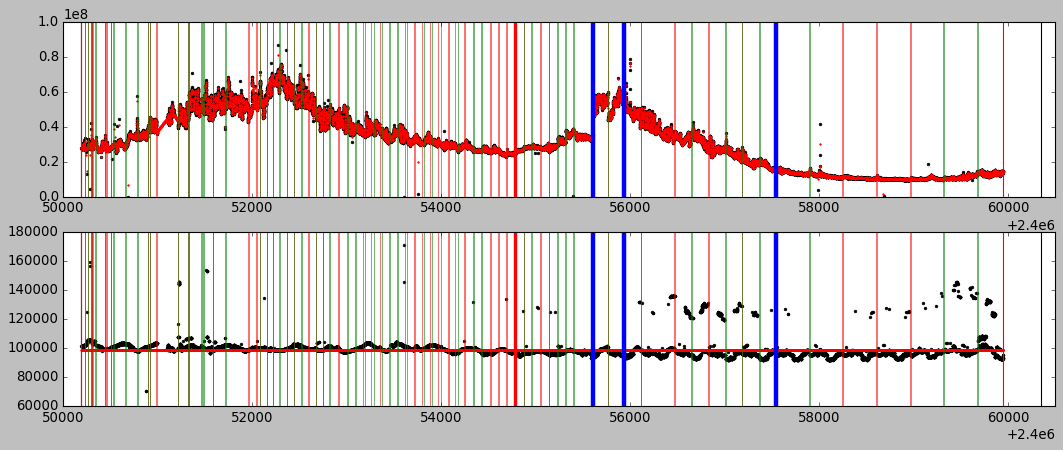

In [19]:
#cut off beginning and end of time series, when SEM is taking data but EIT is not
t304_mask = (tSEM >= t304[0]) & (tSEM <= t304[-1])

f304_tSEM, u304_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304, u_orig=u304)
print(np.min(u304_tSEM))
fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(t304, f304, 'k.',ms=5)
axes[0].plot(tSEM[t304_mask], f304_tSEM, 'r.',ms=3)
axes[0].set_ylim(0,1.e8)

axes[1].plot(t304, u304, 'k.',ms=5)
axes[1].plot(tSEM[t304_mask], u304_tSEM, 'r.',ms=3)
#axes[1].set_ylim(-10000,1.8e5)
axes[1].set_xlim(2450000,2452000)
for ax in axes:
    ax.set_xlim(2450000,2460500)
    ax.axvline(tSEM[0], color='k')
    ax.axvline(tSEM[-1], color='k')

    ax.axvline(t304[0], color='r')
    ax.axvline(t304[-1], color='r')
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

    ax.axvline(2455602.033727, color='b', lw=4)
    ax.axvline(2455938.417, color='b', lw=4)
    ax.axvline(2457542.583333, color='b', lw=4)
    ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')


plt.show()

# define ratio

In [20]:
def normalizedFluxRatio(f1, f2, u1, u2):
    """
    assume f1, f2 are defined on the same array of times and therefore have the same length
    """

    med_f1 = np.median(f1[~np.isnan(f1)])
    med_f2 = np.median(f2[~np.isnan(f2)])

    ratio = (f1/med_f1)/(f2/med_f2)

    unc_med_f1 = np.sqrt((np.pi/2) * np.sum(u1[~np.isnan(u1)]**2/len(u1[~np.isnan(u1)])))
    unc_med_f2 = np.sqrt((np.pi/2) * np.sum(u2[~np.isnan(u2)]**2/len(u2[~np.isnan(u2)])))

    unc_ratio_sq = ((med_f2/(f2 * med_f1))**2 * u1**2) + (((f1*med_f2)/med_f1)**2 * (1/f2**2)**2 * u2**2) + (((f1*med_f2)/f2)**2 * (1/med_f1**2)**2 * unc_med_f1**2) + ((f1/(f2 * med_f1))**2 * unc_med_f2**2)
    unc_ratio = np.sqrt(unc_ratio_sq)

    return ratio, unc_ratio

In [21]:
ratio, unc_ratio = normalizedFluxRatio(f1=f304_tSEM, f2=fSEM[t304_mask], u1=u304_tSEM, u2=uSEM[t304_mask])

In [22]:
# fit two exponentials: one between these two bakeouts (this, June 3, 2016, is the time at which bakeout frequency goes from
# ~every 6 months to ~every year)
fit1Mask = (tSEM[t304_mask] >= 2455938.417) & (tSEM[t304_mask] < 2457542.583333)
#fit1Mask = (tSEM[t304_mask] >= 2455602.033727) & (tSEM[t304_mask] < 2457542.583333)
# and one for the end
fit2Mask = (tSEM[t304_mask] >= 2457542.583333)

# we're fitting a line to ln(ratio) vs. t
# so need to transform coordinates and uncertainties
t1_to_fit = tSEM[t304_mask][fit1Mask] - tSEM[t304_mask][fit1Mask][0]
lnratio1_to_fit = np.log(ratio[fit1Mask])
lnratio1_to_fit_err = (unc_ratio/ratio)[fit1Mask]

noNans1 = ~np.isnan(t1_to_fit) & ~np.isnan(lnratio1_to_fit) & ~np.isnan(lnratio1_to_fit_err)

#fit the line
B1, B1var = least_squares_line(X=t1_to_fit[noNans1],Y=lnratio1_to_fit[noNans1],Yerr=lnratio1_to_fit_err[noNans1])
print(B1)
#print(np.sqrt(B1var))

# transform coordinates and uncertainties for the second exponential
t2_to_fit = tSEM[t304_mask][fit2Mask] - tSEM[t304_mask][fit2Mask][0]
lnratio2_to_fit = np.log(ratio[fit2Mask])
lnratio2_to_fit_err = (unc_ratio/ratio)[fit2Mask]

noNans2 = ~np.isnan(t2_to_fit) & ~np.isnan(lnratio2_to_fit) & ~np.isnan(lnratio2_to_fit_err)

B2, B2var = least_squares_line(X=t2_to_fit[noNans2],Y=lnratio2_to_fit[noNans2],Yerr=lnratio2_to_fit_err[noNans2])
print(B2)
#print(np.sqrt(B2var))


[-0.00059312  0.37070747]
[-1.06756448e-04 -5.54992257e-01]


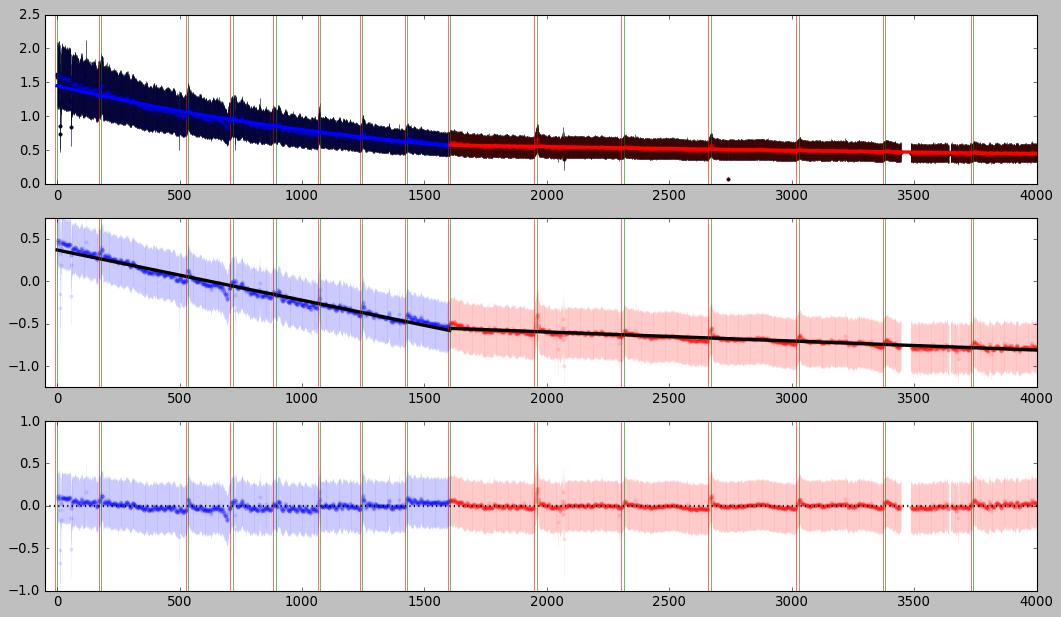

In [23]:
fig, axes = plt.subplots(3,1,figsize=(16,9))
axes[0].errorbar(tSEM[t304_mask][fit1Mask | fit2Mask] - tSEM[t304_mask][fit1Mask][0], ratio[fit1Mask | fit2Mask],yerr=unc_ratio[fit1Mask | fit2Mask],marker='.',color='k',elinewidth=0.5,capsize=0,linestyle='None',zorder=1)
axes[0].errorbar(t1_to_fit, ratio[fit1Mask],yerr=unc_ratio[fit1Mask],marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)
axes[0].errorbar(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], ratio[fit2Mask],yerr=unc_ratio[fit2Mask],marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)

axes[0].plot(t1_to_fit, np.exp(B1[0]*t1_to_fit + B1[1]),'b-',lw=3,zorder=3)
axes[0].plot(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], np.exp(B2[0]*t2_to_fit + B2[1]),'r-',lw=3,zorder=3)

axes[1].errorbar(t1_to_fit, lnratio1_to_fit,yerr=lnratio1_to_fit_err,marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[1].plot(t1_to_fit, B1[0]*t1_to_fit + B1[1], 'k-',lw=3,zorder=2)
axes[1].errorbar(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], lnratio2_to_fit,yerr=lnratio2_to_fit_err,marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[1].plot(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], B2[0]*t2_to_fit + B2[1], 'k-',lw=3,zorder=2)
axes[1].set_ylim(-1.25,0.75)

axes[2].errorbar(t1_to_fit, lnratio1_to_fit - (B1[0]*t1_to_fit + B1[1]), yerr=lnratio1_to_fit_err,marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[2].errorbar(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], lnratio2_to_fit - (B2[0]*t2_to_fit + B2[1]),yerr=lnratio2_to_fit_err, marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[2].axhline(0,color='k',ls=':',zorder=3,lw=2)
axes[2].set_ylim(-1,1)


for ax in axes:
    ax.set_xlim(-50,4000)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate- tSEM[t304_mask][fit1Mask][0],color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate- tSEM[t304_mask][fit1Mask][0],color='g',linestyle='-',lw=0.5)

plt.show()

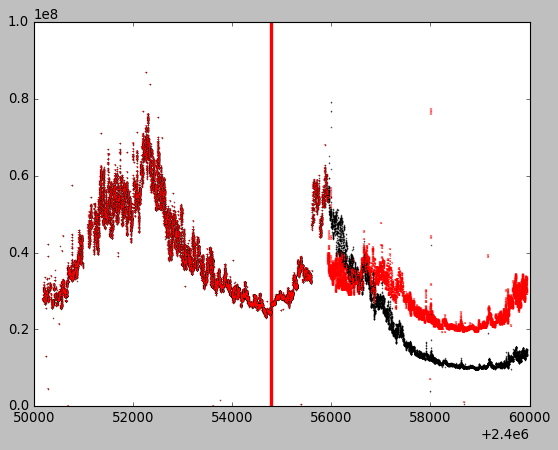

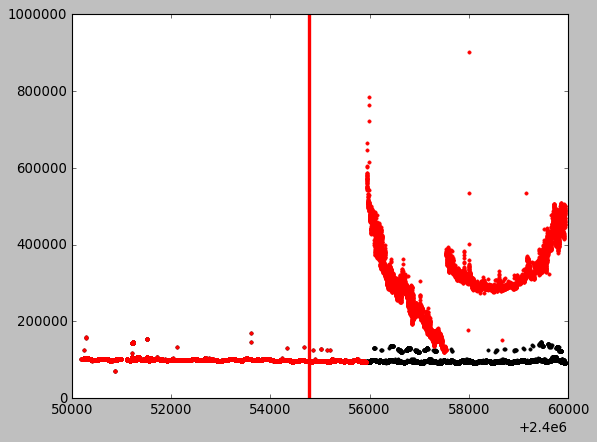

In [24]:
# new arrays to work with
f304_expCorrected = copy.deepcopy(f304)
u304_expCorrected = copy.deepcopy(u304)

# fit parameters, re-notated
A1 = np.exp(B1[1])
# note that sigma_A = dA/dB1 * sigma_B1 = exp(B1) * sigma_B1
sigma_A1 = np.exp(B1[1]) * np.sqrt(B1var[1])
k1 = B1[0]
sigma_k1 = np.sqrt(B1var[0])

A2 = np.exp(B2[1])
sigma_A2 = np.exp(B2[1]) * np.sqrt(B2var[1])
k2 = B2[0]
sigma_k2 = np.sqrt(B2var[0])

#redefine fit masks to apply to t304 so we can do the correction
fit1Mask_t304 = (t304 >= 2455938.417) & (t304 < 2457542.583333)
#fit1Mask_t304 = (t304 >= 2455602.033727) & (t304 < 2457542.583333)
fit2Mask_t304 = (t304 >= 2457542.583333)
t1_to_fit_t304 = t304[fit1Mask_t304] - t304[fit1Mask_t304][0]
t2_to_fit_t304 = t304[fit2Mask_t304] - t304[fit2Mask_t304][0]

# f304,corr = f304/(A*exp(-kt)) = f304 * (1/A) * exp(kt), where A = exp(B[1]) and k = -B[0]
f304_expCorrected[fit1Mask_t304] = f304[fit1Mask_t304]/(A1* np.exp(k1*t1_to_fit_t304))
f304_expCorrected[fit2Mask_t304] = f304[fit2Mask_t304]/(A2* np.exp(k2*t2_to_fit_t304))

# propagate uncertainties analytically
u304_expCorrected[fit1Mask_t304] = np.sqrt( ( (np.exp(k1*t1_to_fit_t304)/A1) * u304[fit1Mask_t304] )**2 + ( ((f304[fit1Mask_t304] * np.exp(k1*t1_to_fit_t304))/A1**2) * sigma_A1 )**2 + ( ((f304[fit1Mask_t304] * np.exp(k1*t1_to_fit_t304) * t1_to_fit_t304)/A1) * sigma_k1 )**2 )
u304_expCorrected[fit2Mask_t304] = np.sqrt( ( (np.exp(k2*t2_to_fit_t304)/A2) * u304[fit2Mask_t304] )**2 + ( ((f304[fit2Mask_t304] * np.exp(k2*t2_to_fit_t304))/A2**2) * sigma_A2 )**2 + ( ((f304[fit2Mask_t304] * np.exp(k2*t2_to_fit_t304) * t2_to_fit_t304)/A2) * sigma_k2 )**2 )

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(t304, f304, u304, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_expCorrected, u304_expCorrected, color='r',marker='.',markersize=1,linestyle='None',elinewidth=2,capsize=0,alpha=0.5)
ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')

ax.set_ylim(0.,1e8)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(t304, u304, 'k.')
ax.plot(t304, u304_expCorrected, 'r.')
ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')

plt.show()


# redefine ratio

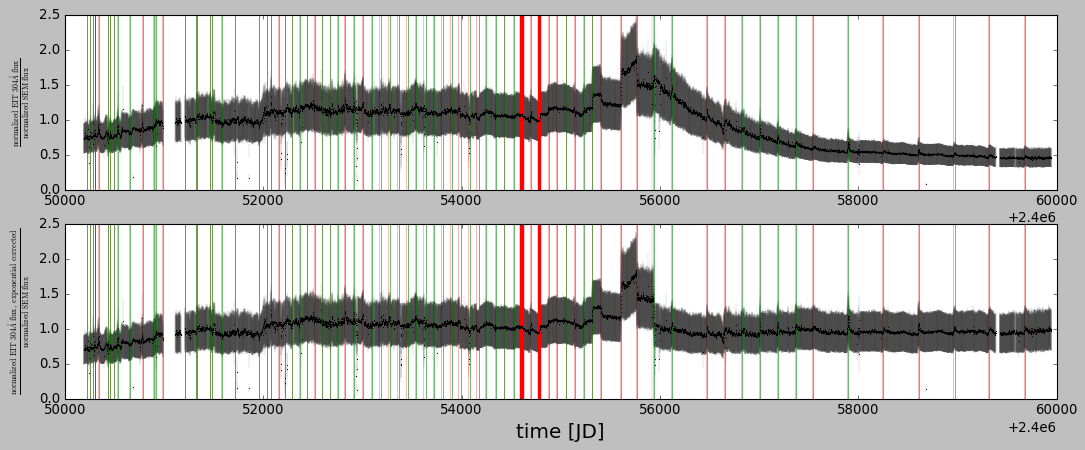

In [25]:
f304_expCorrected_tSEM, u304_expCorrected_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304_expCorrected, u_orig=u304_expCorrected)
ratio_expCorrected, unc_ratio_expCorrected = normalizedFluxRatio(f1=f304_expCorrected_tSEM, f2=fSEM[t304_mask], u1=u304_expCorrected_tSEM, u2=uSEM[t304_mask])

fig, axes = plt.subplots(2,1,figsize=(16,6))

axes[0].errorbar(tSEM[t304_mask], ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)
axes[1].errorbar(tSEM[t304_mask], ratio_expCorrected, yerr=unc_ratio_expCorrected, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    for ax in axes:
        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)


axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ exponential\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_xlabel(r"time [JD]", fontsize=18)
for ax in axes:
    ax.set_ylim(0,2.5)
    ax.axvline(2454609.072650, color='r', lw=4)
    ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')


plt.show()

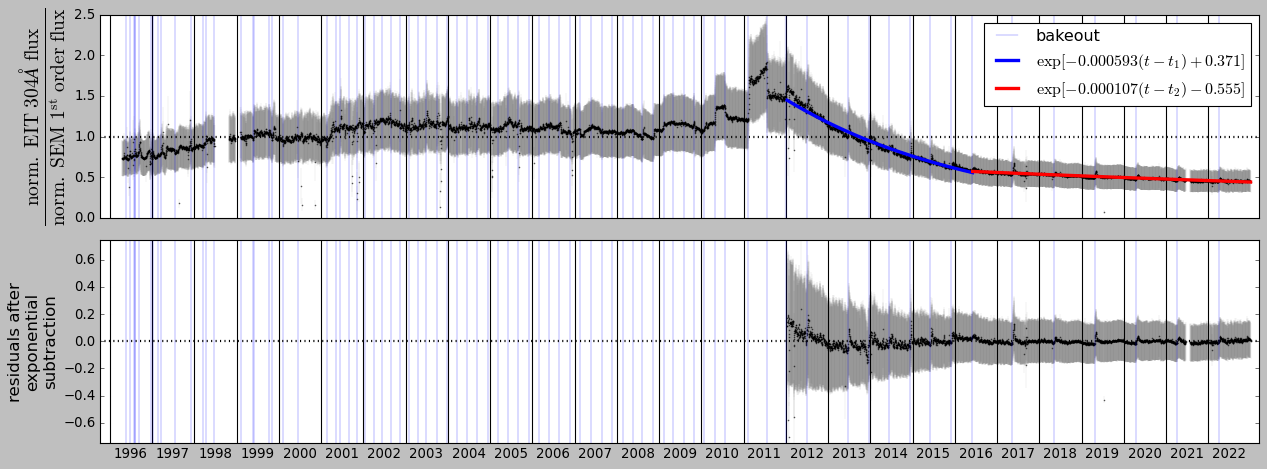

In [26]:
fig, axes = plt.subplots(2,1,figsize=(16,6))

# for legend
axes[0].axvline(1.e8,color='b',linestyle='-',lw=0.25,zorder=2,label='bakeout')

axes[0].errorbar(tSEM[t304_mask], ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2,alpha=0.5)

#axes[0].errorbar(t1_to_fit + tSEM[t304_mask][fit1Mask][0], ratio[fit1Mask],yerr=unc_ratio[fit1Mask],marker='.',color='k',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)
#axes[0].errorbar(t2_to_fit + tSEM[t304_mask][fit1Mask][0]+ tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], ratio[fit2Mask],yerr=unc_ratio[fit2Mask],marker='.',color='k',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)

axes[0].plot(t1_to_fit+ tSEM[t304_mask][fit1Mask][0], np.exp(B1[0]*t1_to_fit + B1[1]),'b-',lw=3,zorder=4,label=r"$\exp[{0}(t-t_1)+{1}]$".format(np.round(B1[0],6),np.round(B1[1],3)))
axes[0].plot(t2_to_fit+ tSEM[t304_mask][fit2Mask][0], np.exp(B2[0]*t2_to_fit + B2[1]),'r-',lw=3,zorder=4,label=r"$\exp[{0}(t-t_2) {1}]$".format(np.round(B2[0],6),np.round(B2[1],3)))
axes[0].set_ylim(0,2.5)
axes[0].axhline(1,color='k',ls=':',zorder=3,lw=2)

axes[1].errorbar(t1_to_fit+ tSEM[t304_mask][fit1Mask][0], ratio[fit1Mask] - np.exp(B1[0]*t1_to_fit + B1[1]),yerr=unc_ratio[fit1Mask], marker='.',color='k',elinewidth=0.1,capsize=0,linestyle='None',ms=2,zorder=1,alpha=0.5)
axes[1].errorbar(t2_to_fit+ tSEM[t304_mask][fit2Mask][0], ratio[fit2Mask] - np.exp(B2[0]*t2_to_fit + B2[1]),yerr=unc_ratio[fit2Mask], marker='.',color='k',elinewidth=0.1,capsize=0,linestyle='None',ms=2,zorder=1,alpha=0.5)
axes[1].axhline(0,color='k',ls=':',zorder=3,lw=2)
axes[1].set_ylim(-0.75,0.75)

for ax in axes:
    #ax.set_xlim(-50,4000)
    ax.set_xlim(2450000, 2460020)
    

    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        #ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25,zorder=2)
    
    for i, y in enumerate(np.arange(1996,2023)):
        jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
        jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

        ax.set_xticks([])
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1) 
        #ax.axvline(tSEM[t304_mask][fit1Mask][0],color='b',ls='-',lw=0.5,zorder=3)
        #ax.axvline(tSEM[t304_mask][fit2Mask][0],color='r',ls='-',lw=0.5,zorder=3)
        if ax==axes[1]:
            ax.text(jan1_thisyear + 180., -0.86, str(y),horizontalalignment='center',fontsize=12,backgroundcolor='None')

axes[0].set_ylabel(r"$\frac{\mathrm{norm.\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{norm.\ SEM\ 1^{st}\ order\ flux}}$",fontsize=25)
axes[1].set_ylabel("residuals after"+"\n"+"exponential"+"\n"+"subtraction",fontsize=15)

#plt.subplots_adjust(hspace=0.05)
axes[0].legend(loc='upper right')


fig.tight_layout()
#plt.show()
plt.savefig("./exponential_trend_and_residuals.pdf",bbox_inches='tight')


# Now, for each inter-bakeout period, fit a linear relationship to the f304/fSEM ratio and divide it out of f304.

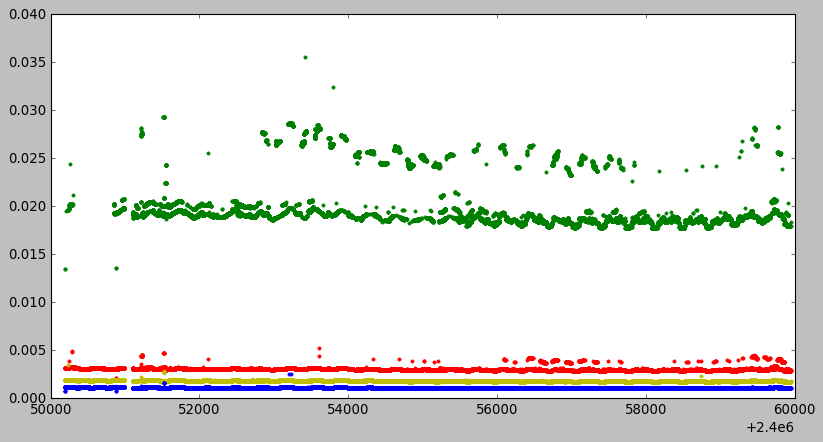

In [27]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(t304, u304/np.median(f304[~np.isnan(f304)]), 'r.')
ax.plot(t284, u284/np.median(f284[~np.isnan(f284)]), 'g.')
ax.plot(t195, u195/np.median(f195[~np.isnan(f195)]), 'y.')
ax.plot(t171, u171/np.median(f171[~np.isnan(f171)]), 'b.')
plt.show()

In [28]:
def fitBakeoutSegment(t, ratio, unc_ratio, prev_bakeoutEndDate, next_bakeoutStartDate):
    """
    Fit a line to the ratio of f304_norm/fSEM_norm
    """
    fitMask = (t >= prev_bakeoutEndDate) & (t <= next_bakeoutStartDate)

    t_to_fit = t[fitMask] - t[fitMask][0]
    ratio_to_fit = ratio[fitMask]
    unc_ratio_to_fit = unc_ratio[fitMask]

    noNans = ~np.isnan(t_to_fit) & ~np.isnan(ratio_to_fit) & ~np.isnan(unc_ratio_to_fit) 

    B, Bunc = least_squares_line(X=t_to_fit[noNans],Y=ratio_to_fit[noNans],Yerr=unc_ratio_to_fit[noNans])

    return fitMask, B, Bunc

def correctLinearBakeoutSegment(t, f, u, B, Bunc):
    """
    divide the linear relationship fit to f304_norm/fSEM_norm out of f304_norm
    """
    # fit parameters, re-notated
    m = B[0]
    sigma_m = np.sqrt(Bunc[0])
    b = B[1]
    sigma_b = np.sqrt(Bunc[1])

    #propagate uncertainties analytically
    fcorr = f/(m*t + b)
    ucorr = np.sqrt( ( (1./(m*t +b)) * u )**2 + ( (-f/(m*t + b)**2) * t * sigma_m )**2 + ( (-f/(m*t + b)**2) * sigma_b )**2 ) 

    return fcorr, ucorr




# Plot post-exponential correction, pre-linear bakeout correction

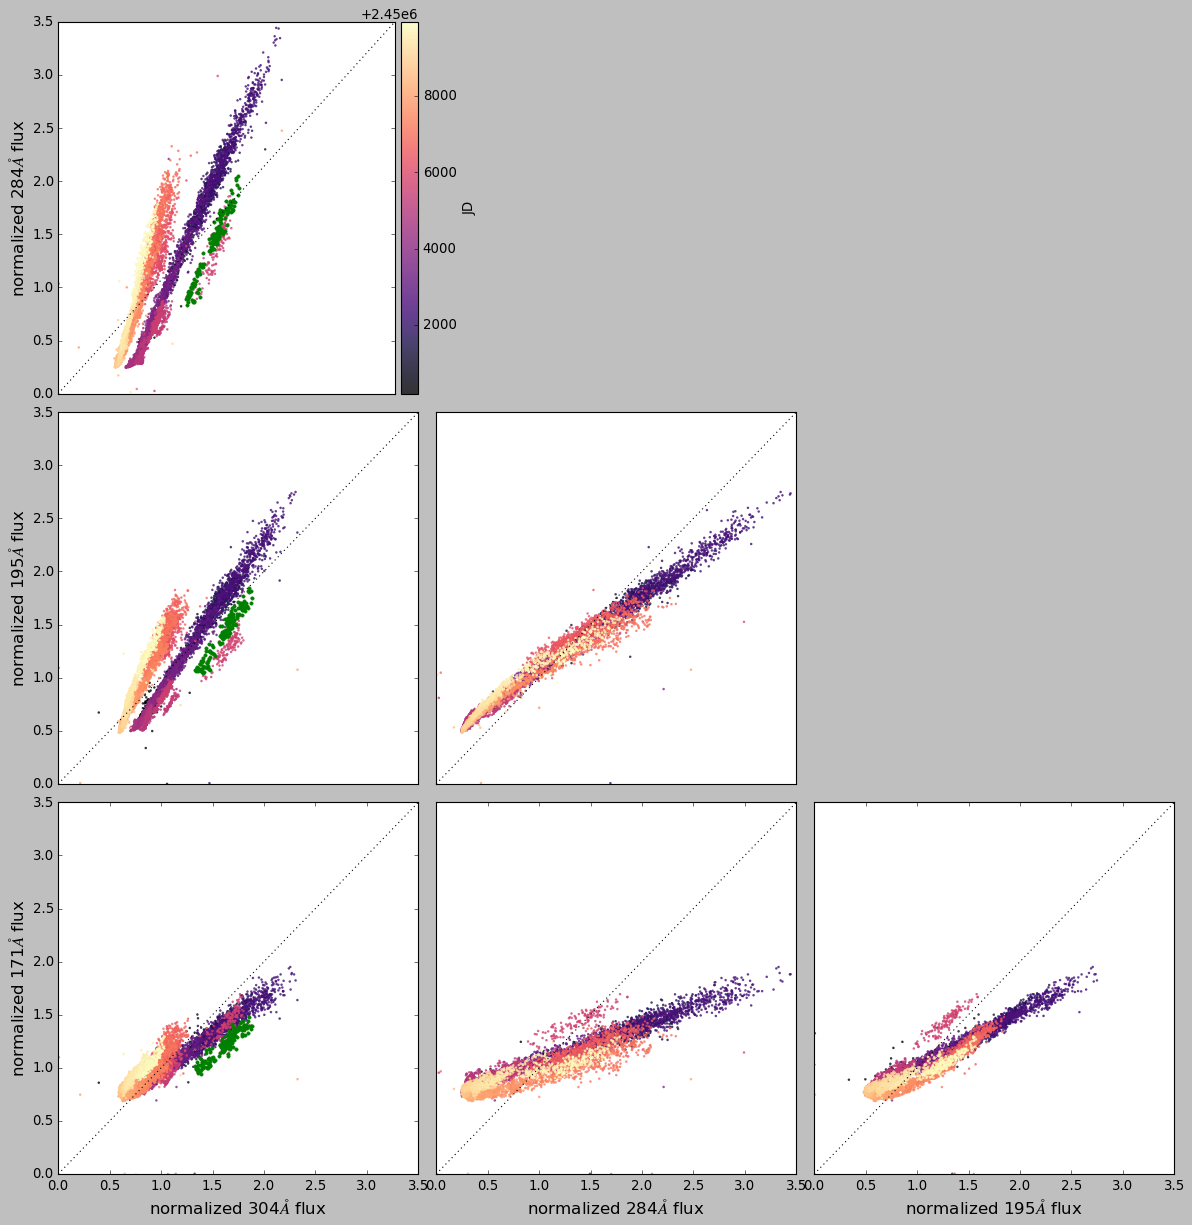

In [29]:
fArrs_to_plot = [f304_expCorrected, f284, f195, f171]
uArrs_to_plot = [u304_expCorrected, u284, u195, u171]
tArrs_to_plot = [t304, t284, t195, t171]

# nov 12, 2008 (first bakeout with obvious discontinuity)
tsplit_1 = 2454783.150532

tLastBadBakeoutBegins = 2455765.033727

# beginning of f304 first exponential trend
tsplit_exp1 = 2455938.417
# beginning of f304 second exponential trend
tsplit_exp2 = 2457542.583333

fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):

    overlap_t, tEIT_i_ind, t304_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[0],0), return_indices=True)

    split0 = (overlap_t <= tsplit_1)
    split1 = (overlap_t > tLastBadBakeoutBegins) & (overlap_t <= tsplit_exp1)
    split_exp1 = (overlap_t > tsplit_exp1) & (overlap_t <= tsplit_exp2)
    split_exp2 = (overlap_t > tsplit_exp2)
    
    c_s = axes[i-1,0].scatter(fArrs_to_plot[0][t304_ind]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[0][t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8,zorder=0)
    
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split0]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split0]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'b.',zorder=1,alpha=0.1)
    axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'g.',zorder=2)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'b.',zorder=3)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp2]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp2]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'g.',zorder=4)
    
   
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="JD")
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"normalized 304$\AA$ flux",fontsize=15)
axes[0,0].set_ylabel(r"normalized 284$\AA$ flux",fontsize=15)
axes[1,0].set_ylabel(r"normalized 195$\AA$ flux",fontsize=15)
axes[2,0].set_ylabel(r"normalized 171$\AA$ flux",fontsize=15)


for i in range(2,4):
    overlap_t, tEIT_i_ind, t284_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[1],0), return_indices=True)
    
    axes[i-1,1].scatter(fArrs_to_plot[1][t284_ind]/np.median(fArrs_to_plot[1][~np.isnan(fArrs_to_plot[1])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[1][t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"normalized 284$\AA$ flux",fontsize=15)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    overlap_t, tEIT_i_ind, t195_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[2],0), return_indices=True)
    
    axes[i-1,2].scatter(fArrs_to_plot[2][t195_ind]/np.median(fArrs_to_plot[2][~np.isnan(fArrs_to_plot[2])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[2][t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"normalized 195$\AA$ flux",fontsize=15)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.plot(np.arange(5),np.arange(5),color='k',ls=':')

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])

plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()
#plt.savefig("./ratio_EITbands_to_eachother_expCorrected.pdf",bbox_inches="tight")
#plt.savefig("./ratio_EITbands_to_eachother_corrected.pdf",bbox_inches="tight")

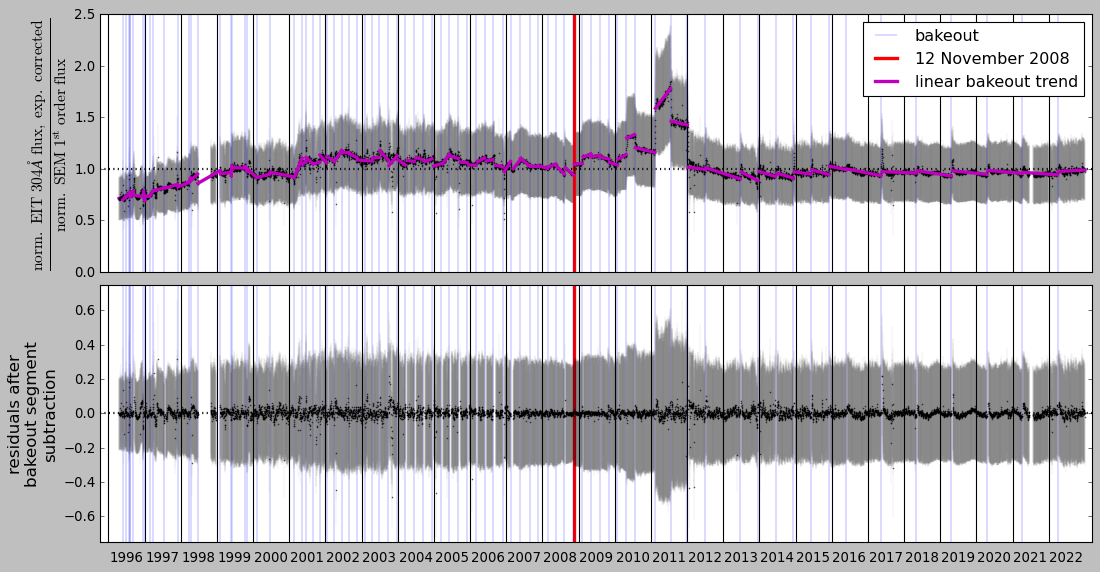

In [30]:
# new arrays to work with
f304_corrected_all = copy.deepcopy(f304_expCorrected)
u304_corrected_all = copy.deepcopy(u304_expCorrected)
f284_corrected_all = copy.deepcopy(f284)
u284_corrected_all = copy.deepcopy(u284)
f195_corrected_all = copy.deepcopy(f195)
u195_corrected_all = copy.deepcopy(u195)
f171_corrected_all = copy.deepcopy(f171)
u171_corrected_all = copy.deepcopy(u171)

f304_corrected_2008onwards = copy.deepcopy(f304_expCorrected)
u304_corrected_2008onwards = copy.deepcopy(u304_expCorrected)
f284_corrected_2008onwards = copy.deepcopy(f284)
u284_corrected_2008onwards = copy.deepcopy(u284)
f195_corrected_2008onwards = copy.deepcopy(f195)
u195_corrected_2008onwards = copy.deepcopy(u195)
f171_corrected_2008onwards = copy.deepcopy(f171)
u171_corrected_2008onwards = copy.deepcopy(u171)

#outlier rejection
unc_ratio_expCorrected[ratio_expCorrected  < 0.5] = np.nan
ratio_expCorrected[ratio_expCorrected < 0.5] = np.nan


# plot segment-by-segment linear fits to f304/fSEM as we go
fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].axvline(1.e8,color='b',linestyle='-',lw=0.25,zorder=2,label='bakeout')

axes[0].errorbar(tSEM[t304_mask], ratio_expCorrected, yerr=unc_ratio_expCorrected, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2,alpha=0.5)

axes[0].set_ylim(0,2.5)
axes[0].axhline(1,color='k',ls=':',zorder=3,lw=2)
axes[1].axhline(0,color='k',ls=':',zorder=3,lw=2)
axes[1].set_ylim(-0.75,0.75)

for ax in axes:
    #ax.set_xlim(-50,4000)
    ax.set_xlim(2450000, 2460020)

    #ax.axvline(2454609.072650, color='r',lw=3,label='22 May 2008')
    ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')

    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        #ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25,zorder=2)
    
    for i, y in enumerate(np.arange(1996,2023)):
        jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
        jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

        ax.set_xticks([])
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1) 
        #ax.axvline(tSEM[t304_mask][fit1Mask][0],color='b',ls='-',lw=0.5,zorder=3)
        #ax.axvline(tSEM[t304_mask][fit2Mask][0],color='r',ls='-',lw=0.5,zorder=3)
        if ax==axes[1]:
            ax.text(jan1_thisyear + 180., -0.86, str(y),horizontalalignment='center',fontsize=12,backgroundcolor='None')

axes[0].set_ylabel(r"$\frac{\mathrm{norm.\ EIT}\ 304\AA\ \mathrm{flux,\ exp.\ corrected}}{\mathrm{norm.\ SEM\ 1^{st}\ order\ flux}}$",fontsize=20)
axes[1].set_ylabel("residuals after"+"\n"+"bakeout segment"+"\n"+"subtraction",fontsize=15)

#0th segment, before any bakeouts
#fit linear relationship to f304/fSEM vs t
fitMask, B, Bunc = fitBakeoutSegment(t=tSEM[t304_mask], ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=tSEM[t304_mask][0], next_bakeoutStartDate=heaterOn[0]['jd'])


fitMask_t304 = (t304 >= t304[0]) & (t304 <= heaterOn[0]['jd']) 
fitMask_t284 = (t284 >= t304[0]) & (t284 <= heaterOn[0]['jd']) 
fitMask_t195 = (t195 >= t304[0]) & (t195 <= heaterOn[0]['jd']) 
fitMask_t171 = (t171 >= t304[0]) & (t171 <= heaterOn[0]['jd']) 

fcorr304, ucorr304 = correctLinearBakeoutSegment(t304[fitMask_t304]- t304[fitMask_t304][0], f304_expCorrected[fitMask_t304], u304_expCorrected[fitMask_t304], B, Bunc)
f304_corrected_all[fitMask_t304] = fcorr304
u304_corrected_all[fitMask_t304] = ucorr304

fcorr284, ucorr284 = correctLinearBakeoutSegment(t284[fitMask_t284]- t304[fitMask_t304][0], f284[fitMask_t284], u284[fitMask_t284], B, Bunc)
f284_corrected_all[fitMask_t284] = fcorr284
u284_corrected_all[fitMask_t284] = ucorr284

fcorr195, ucorr195 = correctLinearBakeoutSegment(t195[fitMask_t195]- t304[fitMask_t304][0], f195[fitMask_t195], u195[fitMask_t195], B, Bunc)
f195_corrected_all[fitMask_t195] = fcorr195
u195_corrected_all[fitMask_t195] = ucorr195

fcorr171, ucorr171 = correctLinearBakeoutSegment(t171[fitMask_t171]- t304[fitMask_t304][0], f171[fitMask_t171], u171[fitMask_t171], B, Bunc)
f171_corrected_all[fitMask_t171] = fcorr171
u171_corrected_all[fitMask_t171] = ucorr171

axes[0].plot(tSEM[t304_mask][fitMask], B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1], 'm-',lw=3,zorder=2)
axes[1].errorbar(tSEM[t304_mask][fitMask],ratio_expCorrected[fitMask] - (B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1]),yerr=unc_ratio_expCorrected[fitMask], color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2,alpha=0.5)


for j in range(80):
    tstart = heaterOff[j]['jd']
    tend = heaterOn[j+1]['jd']
    
    fitMask, B, Bunc = fitBakeoutSegment(t=tSEM[t304_mask], ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=heaterOff[j]['jd'], next_bakeoutStartDate=heaterOn[j+1]['jd'])

    axes[0].plot(tSEM[t304_mask][fitMask], B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1], 'm-',lw=3,zorder=3)
    axes[1].errorbar(tSEM[t304_mask][fitMask],ratio_expCorrected[fitMask] - (B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1]),yerr=unc_ratio_expCorrected[fitMask], color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2,alpha=0.5,zorder=2)

    fitMask_t304 = (t304 >= heaterOff[j]['jd']) & (t304 <= heaterOn[j+1]['jd']) 
    fitMask_t284 = (t284 >= heaterOff[j]['jd']) & (t284 <= heaterOn[j+1]['jd']) 
    fitMask_t195 = (t195 >= heaterOff[j]['jd']) & (t195 <= heaterOn[j+1]['jd']) 
    fitMask_t171 = (t171 >= heaterOff[j]['jd']) & (t171 <= heaterOn[j+1]['jd'])

    fcorr304, ucorr304 = correctLinearBakeoutSegment(t304[fitMask_t304]- t304[fitMask_t304][0], f304_expCorrected[fitMask_t304], u304_expCorrected[fitMask_t304], B, Bunc)
    f304_corrected_all[fitMask_t304] = fcorr304 
    u304_corrected_all[fitMask_t304] = ucorr304

    fcorr284, ucorr284 = correctLinearBakeoutSegment(t284[fitMask_t284]- t304[fitMask_t304][0], f284[fitMask_t284], u284[fitMask_t284], B, Bunc)
    f284_corrected_all[fitMask_t284] = fcorr284 
    u284_corrected_all[fitMask_t284] = ucorr284

    fcorr195, ucorr195 = correctLinearBakeoutSegment(t195[fitMask_t195]- t304[fitMask_t304][0], f195[fitMask_t195], u195[fitMask_t195], B, Bunc)
    f195_corrected_all[fitMask_t195] = fcorr195 
    u195_corrected_all[fitMask_t195] = ucorr195
    
    fcorr171, ucorr171 = correctLinearBakeoutSegment(t171[fitMask_t171]- t304[fitMask_t304][0], f171[fitMask_t171], u171[fitMask_t171], B, Bunc)
    f171_corrected_all[fitMask_t171] = fcorr171 
    u171_corrected_all[fitMask_t171] = ucorr171 

    if heaterOff[j]['jd'] < 2454609.072650:
        continue
            
    # May 22, 2008 (first bakeout with obvious discontinuity)
    #if heaterOff[j]['jd'] >= 2454609.072650:
    
    #November 12, 2008 (as bakeout discontinuities are getting bad; ~coincides w/ end of solar cycle 23)
    if heaterOff[j]['jd'] >= 2454783.150532:
        
        f304_corrected_2008onwards[fitMask_t304] = fcorr304
        u304_corrected_2008onwards[fitMask_t304] = ucorr304
        
        f284_corrected_2008onwards[fitMask_t284] = fcorr284 
        u284_corrected_2008onwards[fitMask_t284] = ucorr284
        
        f195_corrected_2008onwards[fitMask_t195] = fcorr195 
        u195_corrected_2008onwards[fitMask_t195] = ucorr195
                
        f171_corrected_2008onwards[fitMask_t171] = fcorr171 
        u171_corrected_2008onwards[fitMask_t171] = ucorr171
    
#final segment, after all bakeouts
tstart = heaterOff[-1]['jd']
tend = t304[-1]

fitMask, B, Bunc = fitBakeoutSegment(t=tSEM[t304_mask], ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=heaterOff[-1]['jd'], next_bakeoutStartDate=tSEM[t304_mask][-1])

axes[0].plot(tSEM[t304_mask][fitMask], B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1], 'm-',lw=3,zorder=3,label='linear bakeout trend')
axes[1].errorbar(tSEM[t304_mask][fitMask],ratio_expCorrected[fitMask] - (B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1]),yerr=unc_ratio_expCorrected[fitMask], color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2,alpha=0.5,zorder=3)

fitMask_t304 = (t304 >= heaterOff[-1]['jd']) & (t304 <= t304[-1]) 
fitMask_t284 = (t284 >= heaterOff[-1]['jd']) & (t284 <= t304[-1]) 
fitMask_t195 = (t195 >= heaterOff[-1]['jd']) & (t195 <= t304[-1]) 
fitMask_t171 = (t171 >= heaterOff[-1]['jd']) & (t171 <= t304[-1]) 
    
fcorr304, ucorr304 = correctLinearBakeoutSegment(t304[fitMask_t304]- t304[fitMask_t304][0], f304_expCorrected[fitMask_t304], u304_expCorrected[fitMask_t304], B, Bunc)
f304_corrected_all[fitMask_t304] = fcorr304
u304_corrected_all[fitMask_t304] = ucorr304

fcorr284, ucorr284 = correctLinearBakeoutSegment(t284[fitMask_t284]- t304[fitMask_t304][0], f284[fitMask_t284], u284[fitMask_t284], B, Bunc)
f284_corrected_all[fitMask_t284] = fcorr284
u284_corrected_all[fitMask_t284] = ucorr284

fcorr195, ucorr195 = correctLinearBakeoutSegment(t195[fitMask_t195]- t304[fitMask_t304][0], f195[fitMask_t195], u195[fitMask_t195], B, Bunc)
f195_corrected_all[fitMask_t195] = fcorr195
u195_corrected_all[fitMask_t195] = ucorr195
    
fcorr171, ucorr171 = correctLinearBakeoutSegment(t171[fitMask_t171]- t304[fitMask_t304][0], f171[fitMask_t171], u171[fitMask_t171], B, Bunc)
f171_corrected_all[fitMask_t171] = fcorr171
u171_corrected_all[fitMask_t171] = ucorr171 

f304_corrected_2008onwards[fitMask_t304] = fcorr304 
u304_corrected_2008onwards[fitMask_t304] = ucorr304
        
f284_corrected_2008onwards[fitMask_t284] = fcorr284
u284_corrected_2008onwards[fitMask_t284] = ucorr284
        
f195_corrected_2008onwards[fitMask_t195] = fcorr195
u195_corrected_2008onwards[fitMask_t195] = ucorr195
                
f171_corrected_2008onwards[fitMask_t171] = fcorr171
u171_corrected_2008onwards[fitMask_t171] = ucorr171

#plt.subplots_adjust(hspace=0.05)
axes[0].legend(loc='upper right')


#ax.set_xlim(2454000,2456000)
#fig.tight_layout()

#plt.show()
plt.subplots_adjust(top=1.2,hspace=0.05)
plt.savefig("./linearbakeout_trend_and_residuals.pdf",bbox_inches="tight")

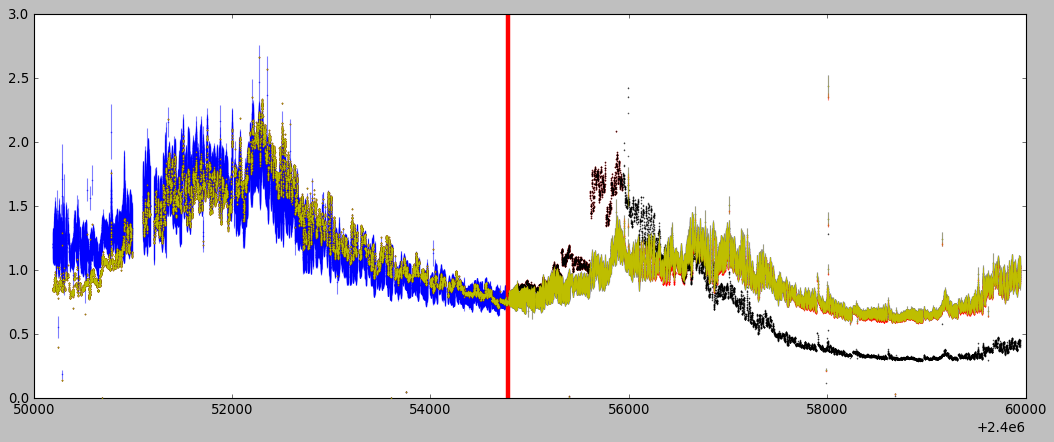

In [31]:
norm = np.median(f304[~np.isnan(f304)])

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t304, f304/norm, u304/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5,zorder=3)
ax.errorbar(t304, f304_expCorrected/norm, u304_expCorrected/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5,zorder=2)
ax.errorbar(t304, f304_corrected_all/norm, u304_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5,zorder=1)
ax.errorbar(t304, f304_corrected_2008onwards/norm, u304_corrected_2008onwards/norm, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5,zorder=4)
ax.axvline(2454783.150532, color='r', lw=4)
    
#ax.set_xlim(2454000,2455000)
#ax.set_ylim(0.5,1.4)
ax.set_ylim(0.,3)
plt.show()

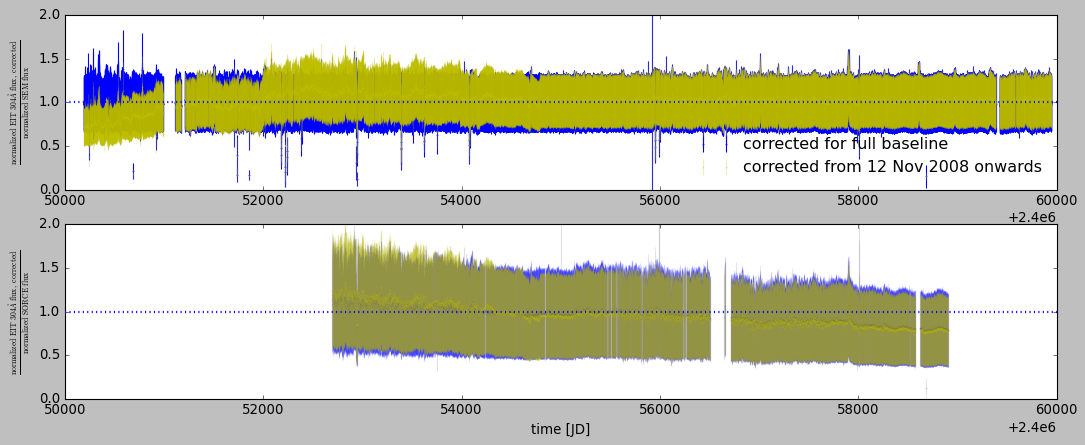

In [32]:
# Plot ratio of corrected 304 to SEM and SORCE.

f304_corrected_all_tSEM, u304_corrected_all_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304_corrected_all, u_orig=u304_corrected_all)
f304_corrected_2008onwards_tSEM, u304_corrected_2008onwards_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304_corrected_2008onwards, u_orig=u304_corrected_2008onwards)

ratio_corrected_all, unc_ratio_corrected_all = normalizedFluxRatio(f1=f304_corrected_all_tSEM, f2=fSEM[t304_mask], u1=u304_corrected_all_tSEM, u2=uSEM[t304_mask])
ratio_corrected_2008onwards, unc_ratio_corrected_2008onwards = normalizedFluxRatio(f1=f304_corrected_2008onwards_tSEM, f2=fSEM[t304_mask], u1=u304_corrected_2008onwards_tSEM, u2=uSEM[t304_mask])

fig, axes = plt.subplots(2,1,figsize=(16,6))


axes[0].errorbar(tSEM[t304_mask], ratio_corrected_all, unc_ratio_corrected_all, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=1,label='corrected for full baseline')
axes[0].errorbar(tSEM[t304_mask], ratio_corrected_2008onwards, unc_ratio_corrected_2008onwards, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=2,alpha=0.25,label='corrected from 12 Nov 2008 onwards')
axes[0].set_ylim(0.,3)

f304_corrected_all_tSORCE, u304_corrected_all_tSORCE = linearInterpolationWithUncertainty(t_new=tSORCE, t_orig=t304, f_orig=f304_corrected_all, u_orig=u304_corrected_all)
f304_corrected_2008onwards_tSORCE, u304_corrected_2008onwards_tSORCE = linearInterpolationWithUncertainty(t_new=tSORCE, t_orig=t304, f_orig=f304_corrected_2008onwards, u_orig=u304_corrected_2008onwards)

med_sorce = np.median(fSORCE[~np.isnan(fSORCE)])

sorce_ratio_corrected_all, unc_sorce_ratio_corrected_all = normalizedFluxRatio(f2=fSORCE, f1=f304_corrected_all_tSORCE, u2=uSORCE, u1=u304_corrected_all_tSORCE)
sorce_ratio_corrected_2008onwards, unc_sorce_ratio_corrected_2008onwards = normalizedFluxRatio(f2=fSORCE, f1=f304_corrected_2008onwards_tSORCE, u2=uSORCE, u1=u304_corrected_2008onwards_tSORCE)

axes[1].errorbar(tSORCE, sorce_ratio_corrected_all, unc_sorce_ratio_corrected_all, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=1,alpha=0.1)
axes[1].errorbar(tSORCE, sorce_ratio_corrected_2008onwards, unc_sorce_ratio_corrected_2008onwards, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=2,alpha=0.1)

for ax in axes:
    ax.set_ylim(0.,2.,)
    ax.axhline(1, linestyle=":",lw=2,zorder=3)
    ax.set_xlim(2450000,2460000)

axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ corrected}}{\mathrm{normalized\ SORCE\ flux}}$",fontsize=10)
axes[1].set_xlabel("time [JD]")
axes[0].legend(loc='lower right',frameon=False)
#plt.show()
plt.savefig("./ratio_EIT304_to_SEM1stOrder_SORCE.pdf",bbox_inches="tight")

5158691.155804405


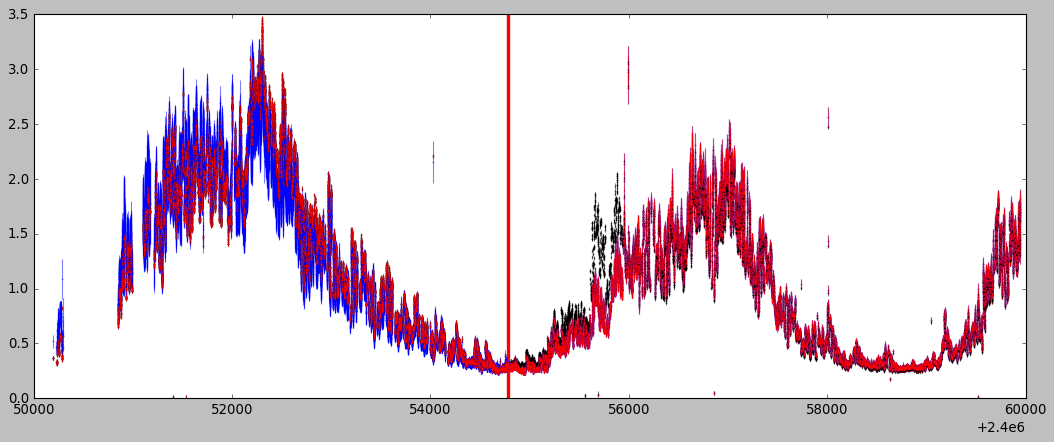

54433861.2217148


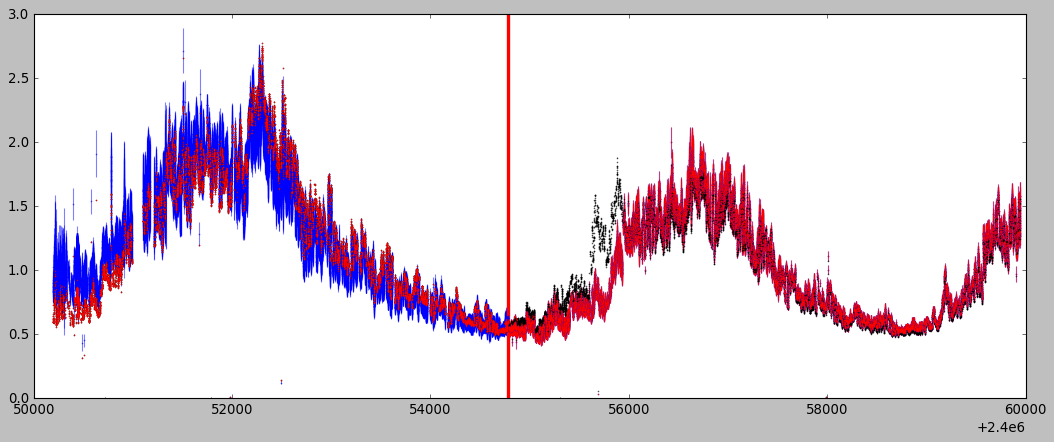

90350650.93731563


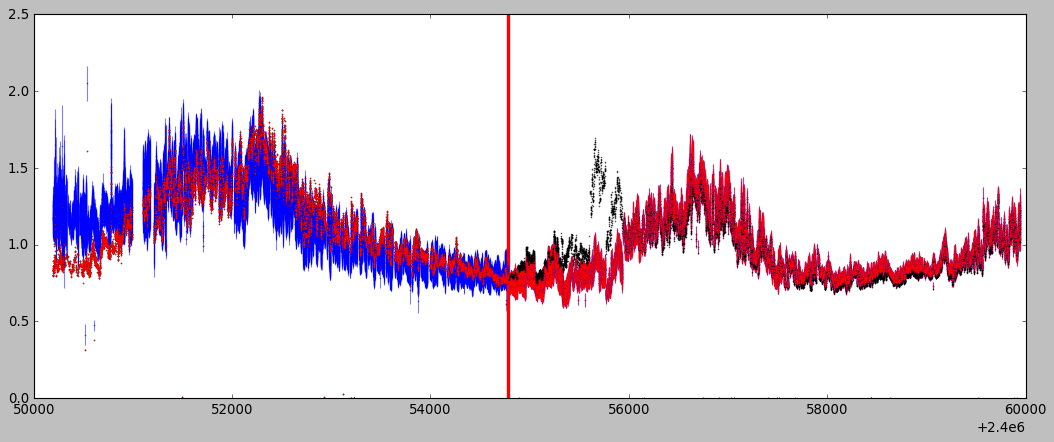

In [33]:
norm = np.median(f284[~np.isnan(f284)])
print(norm)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t284, f284/norm, u284/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t284, f284_corrected_all/norm, u284_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t284, f284_corrected_2008onwards/norm, u284_corrected_2008onwards/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
#ax.axvline(2454609.072650, color='r', lw=4)
ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')

#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,3.5)
plt.show()

norm = np.median(f195[~np.isnan(f195)])
print(norm)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t195, f195/norm, u195/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t195, f195_corrected_all/norm, u195_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t195, f195_corrected_2008onwards/norm, u195_corrected_2008onwards/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
#ax.axvline(2454609.072650, color='r', lw=4)
ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')

#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,3.0)
plt.show()

norm = np.median(f171[~np.isnan(f171)])
print(norm)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t171, f171/norm, u171/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t171, f171_corrected_all/norm, u171_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t171, f171_corrected_2008onwards/norm, u171_corrected_2008onwards/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)

#ax.axvline(2454609.072650, color='r', lw=4)
ax.axvline(2454783.150532, color='r',lw=3,label='12 November 2008')

#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,2.5)
plt.show()

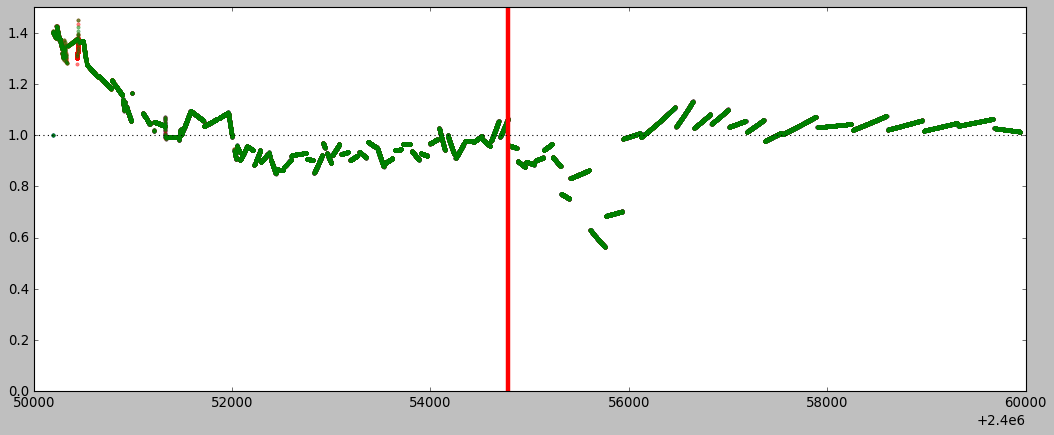

In [34]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(t284, f284_corrected_all/f284, 'b.',alpha=0.5)
ax.plot(t195, f195_corrected_all/f195, 'r.',alpha=0.5)
ax.plot(t171, f171_corrected_all/f171, 'g.',alpha=0.5)
ax.axvline(2454783.150532, color='r', lw=4)
ax.axhline(1,color='k',linestyle=':')
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,1.5)
#ax.set_xlim(2450200,2451000)
plt.show()

# Now, we need one additional correction: A constant offset to each inter-bakeout period for f171, f195, f284, post-Nov 12, 2008.

# Approach for this will be to fit a linear relationship (with scatter) to each of the following, pre-Nov 12, 2008:
## f195 vs. f284 (1)
## f171 vs. f284 (2)
## f171 vs. f195 (3)

## We can calculate the best vertical offset to f195 to make it match line (1) and see if it matches the best horizontal offset to f195 to make it match line (3), etc.

In [35]:
# Functions for fitting a linear relationship with scatter

def fitparams_to_lineparams(fitparams):
    theta = fitparams[:,0]
    bcostheta = fitparams[:,1]
    scatter = fitparams[:,2]
    m = np.tan(theta)
    b = bcostheta/np.cos(theta)
    return np.vstack((m.T, b.T, scatter.T)).T

def lineparams_to_fitparams(lineparams):
    m = lineparams[:,0]
    b = lineparams[:,1]
    scatter = lineparams[:,2]
    theta = np.arctan2(m,1)
    bcostheta = b * np.cos(theta)
    return np.vstack((theta.T, bcostheta.T, scatter.T)).T

def log_prior(params, theta_bounds, bcostheta_bounds, scatter_bounds):
    """
    Inputs:
    fit parameters:
        theta = arctan(slope)
        b*cos(theta) = perpendicular distance from line to origin
    Returns:
    Log prior for these parameters
    """
    theta = params[0]
    bcostheta = params[1]
    scatter = params[2]
    # theta prior is uniform from 0 to pi
    if theta < theta_bounds[0] or theta >= theta_bounds[1]:
        return -np.inf
    # b*cos(theta) prior is uniform 
    # recall that b*cos(theta) is the perpendicular distance of the line from the origin
    if bcostheta < bcostheta_bounds[0] or bcostheta > bcostheta_bounds[1]:
        return -np.inf

    # scatter prior is uniform
    if scatter < scatter_bounds[0] or scatter > scatter_bounds[1]:
        return -np.inf
    
    return -np.log(theta_bounds[1]-theta_bounds[0]) - np.log(bcostheta_bounds[1]-bcostheta_bounds[0]) - np.log(scatter_bounds[1]-scatter_bounds[0]) 


def log_likelihood(params, x, y, xerr, yerr, xycov=None):
    """
    following Hogg et al. 2010 chapter 7
    Assuming no covariance between data points (bad assumption)
    
    Inputs:
    theta, bcostheta = params at current MCMC step
    x, y, xerr, yerr = arrays of data
                
    Returns:
    Log likelihood calculated for these parameters.
    """

    theta = params[0]
    bcostheta = params[1]
    scatter = params[2]

    if scatter < 0:
        return -np.inf

    # orthogonal displacement of data points from the line parametrized by theta, bcostheta
    delta_arr = -np.sin(theta)*x + np.cos(theta)*y - bcostheta

    # projected covariance matrix 
    #(again assuming no off-diagonal terms)
    if xycov is None:
        xycov = np.zeros_like(x)
    sigma_sq = (np.sin(theta)**2 * xerr**2) - (2*np.sin(theta)*np.cos(theta)*xycov) + (np.cos(theta)**2 * yerr**2)
    '''
    if np.any(np.isnan(sigma_sq)) | np.any(np.isnan(scatter)) | np.any(np.isnan(np.log(sigma_sq+scatter))):
        print("term 1")
        print(-np.sum(0.5*np.log(sigma_sq+scatter)))
        print(np.log(sigma_sq+scatter))
        print(sigma_sq+scatter)
    
        print("term 2")
        print(-np.sum( delta_arr**2/(2*(sigma_sq+scatter)) ))
        print("")
    '''
    ll = -np.sum(0.5*np.log(sigma_sq+scatter)) - np.sum( delta_arr**2/(2*(sigma_sq+scatter)) )
    
    return ll

def log_posterior(params, x, y, xerr, yerr, theta_bounds, bcostheta_bounds, scatter_bounds, samplefile=None, xycov=None):
    theta = params[0]
    bcostheta = params[1]
    
    if samplefile is not None:
        lineparams = fitparams_to_lineparams(params)
        samplef = open(samplefile, "w")
        samplef.write("{0} {1}\n".format(m, b))
        samplef.close()

    prior = log_prior(params, theta_bounds, bcostheta_bounds, scatter_bounds)
    if np.isfinite(prior) is False:
        return -np.inf
    
    likelihood = log_likelihood(params, x, y, xerr, yerr, xycov)
    if np.isfinite(likelihood) is False:
        return -np.inf

    return prior + likelihood


def initialize_walkers(nwalkers, init_theta=np.pi/2, init_bcostheta=0., init_scatter=5.):
    """
    Generates nwalkers random initial positions in ndim space.

    Inputs:
    nwalkers = number of initial positions to generate
    ndim = number of dimensions of parameter space
    init_m = initial guess at slope
    init_b = initial guess at intercept

    Returns:
    pos = array of initial walker positions of shape (nwalkers, ndim=2)
    """
    '''
    lower_prior_bounds = np.array((0, -1*bperp_prior))
    upper_prior_bounds = np.array((np.pi, bperp_prior))
    
    #randomly sampled from 10D box
    pos = np.random.uniform(low=0.01, high=0.99, size=(nwalkers, 2))
    pos = (pos*(upper_prior_bounds - lower_prior_bounds)) + lower_prior_bounds
    '''
    pos = np.zeros((nwalkers, 3))
    pos[:,0] = init_theta + 1.e-2*np.random.randn(nwalkers)
    pos[:,1] = init_bcostheta + 1.e-2*np.random.randn(nwalkers)
    pos[:,2] = init_scatter + 1.e-2*np.random.randn(nwalkers) 

    return pos

def fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi), bcostheta_bounds=(-10,10), scatter_bounds=(1.e-6, 100), nwalkers=10, nsteps=5000, discard=500, plot=False, prune_unconverged_walkers=False):
    init_guess = initialize_walkers(nwalkers=nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=3, log_prob_fn=log_posterior, args=[x, y, xerr, yerr, theta_bounds, bcostheta_bounds, scatter_bounds])

    sampler.run_mcmc(init_guess, nsteps)
    samples = sampler.get_chain()

    labels = ['theta', 'bcostheta', 'scatter']
    linelabels=['m', 'b','scatter']
    
    if plot is True:
        fig, axes = plt.subplots(5,1,figsize=(16,6))
        for i in range(3):
            ax = axes[i]
            ax.plot(samples[:,:,i], 'k',alpha=0.3)
            ax.set_xlim(0,len(samples))
            ax.set_ylabel(labels[i])

        axes[3].plot(np.tan(samples[:,:,0]),'k',alpha=0.3)
        axes[3].set_xlim(0,len(samples))
        axes[3].set_ylabel('m')

        axes[4].plot(samples[:,:,1]/np.cos(samples[:,:,0]),'k',alpha=0.3)
        axes[4].set_xlim(0,len(samples))
        axes[4].set_ylabel('b')

        plt.show()

    if prune_unconverged_walkers is True:
        samples = sampler.get_chain(discard=discard)
        acc_frac = sampler.acceptance_fraction
        print(np.shape(samples))
        print(np.shape(acc_frac))
        n_unconverged_walkers = 0
        for i in range(nwalkers):
            if acc_frac[i] < 0.5*np.median(acc_frac):
                samples[:,i,:] = np.nan
                n_unconverged_walkers += 1

        print("{0} walkers did not converge".format(n_unconverged_walkers))
        
        samples = samples[~np.isnan(samples)]
        flat_samples = samples.reshape((nwalkers-n_unconverged_walkers)*(nsteps-discard), 3)
        print(np.shape(flat_samples))
    else:
        flat_samples = sampler.get_chain(discard=discard, flat=True)
    
    flat_lineparams = fitparams_to_lineparams(flat_samples)
    flat_lineparams_stats = np.percentile(flat_lineparams, q=[16,50,84], axis=0)

    if plot is True:
        fig = corner.corner(flat_samples,labels=labels, quantiles=[0.16,0.5,0.84],show_titles='True')
        fig = corner.corner(flat_lineparams,labels=linelabels, quantiles=[0.16,0.5,0.84],show_titles='True')
   
    print("acceptance fraction is: " + str(np.mean(sampler.acceptance_fraction)))
    return flat_lineparams, flat_lineparams_stats


# functions for fitting linear relationship between two EIT bands at a given bakeout segment
def medianBinEIT(tDaily, tEIT, fEIT, uEIT):
    '''
    median-bin the flux from one EIT band into daily values
    '''
    binned_f, bin_edges, binnumber = binned_statistic(x=tEIT, values=fEIT, statistic='median', bins=tDaily)
    binned_u, bin_edges, binnumber = binned_statistic(x=tEIT, values=uEIT, statistic='mean', bins=tDaily)
    binned_u = np.sqrt((np.pi/2)*binned_u)
    return binned_f, binned_u


def fit2EITBakeoutSegment(t1, f1, u1, t2, f2, u2, t_start, t_end, theta_bounds=(0,np.pi), bcostheta_bounds=(-10,10), scatter_bounds=(0,10),nwalkers=10, nsteps=5000, discard=500, plotMCMC=False,plotFit=True, prune_unconverged_walkers=True):
    """
    fit a linear relationship between two EIT band fluxes over one bakeout segment
    
    t_start = start of bakeout segment [JD]
    t_end = end of bakeout segment[JD]
    """
    
    t1daily = np.arange(np.floor(t1[0]),np.ceil(t1[-1])+1,1)
    binned_f1, binned_u1 = medianBinEIT(tDaily=t1daily,tEIT=t1,fEIT=f1,uEIT=u1)

    t2daily = np.arange(np.floor(t2[0]),np.ceil(t2[-1])+1,1)
    binned_f2, binned_u2 = medianBinEIT(tDaily=t2daily,tEIT=t2,fEIT=f2,uEIT=u2)

    binned_t1 = 0.5*(t1daily[0:-1] + t1daily[1:])
    binned_t2 = 0.5*(t2daily[0:-1] + t2daily[1:])
    
    f1med = np.median(f1[~np.isnan(f1)])
    f2med = np.median(f2[~np.isnan(f2)])
    
    norm_f1 = binned_f1/f1med
    norm_u1 = binned_u1/f1med
    norm_f2 = binned_f2/f2med
    norm_u2 = binned_u2/f2med

    nonans1 = ~np.isnan(binned_t1) & ~np.isnan(norm_f1) & ~np.isnan(norm_u1)
    nonans2 = ~np.isnan(binned_t2) & ~np.isnan(norm_f2) & ~np.isnan(norm_u2)

    binned_t1=binned_t1[nonans1]
    norm_f1=norm_f1[nonans1]
    norm_u1=norm_u1[nonans1]
    
    binned_t2=binned_t2[nonans2]
    norm_f2=norm_f2[nonans2]
    norm_u2=norm_u2[nonans2]

    # overlap_t == binned_t1[binned_t1_ind_at_common_obstimes] == binned_t2[binned_t2_ind_at_common_obstimes]
    overlap_t, binned_t1_ind_at_common_obstimes, binned_t2_ind_at_common_obstimes = np.intersect1d(np.round(binned_t1,0), np.round(binned_t2,0), return_indices=True)
    
    bakeout_segment_mask = (overlap_t >= t_start) & (overlap_t < t_end)

    x_to_fit = norm_f1[binned_t1_ind_at_common_obstimes][bakeout_segment_mask]
    xerr_to_fit = norm_u1[binned_t1_ind_at_common_obstimes][bakeout_segment_mask]
    
    y_to_fit = norm_f2[binned_t2_ind_at_common_obstimes][bakeout_segment_mask]
    yerr_to_fit = norm_u2[binned_t2_ind_at_common_obstimes][bakeout_segment_mask]
    
    if len(x_to_fit) < 2:
        print("not enough data in this segment")
        return None, None

    else:
        xsort = np.argsort(x_to_fit)
        x_to_fit = x_to_fit[xsort]
        y_to_fit = y_to_fit[xsort]
        xerr_to_fit = xerr_to_fit[xsort]
        yerr_to_fit = yerr_to_fit[xsort]

        flat_lineparams, flat_lineparams_stats = fitMCMCline(x=x_to_fit, y=y_to_fit, xerr=xerr_to_fit, yerr=yerr_to_fit, theta_bounds=theta_bounds,bcostheta_bounds=bcostheta_bounds, scatter_bounds=scatter_bounds,nwalkers=nwalkers, nsteps=nsteps, discard=discard, plot=plotMCMC,prune_unconverged_walkers=prune_unconverged_walkers)
    
        if plotFit is True:
            B, Bvar = least_squares_line(X=x_to_fit, Y=y_to_fit, Yerr=yerr_to_fit)
    
            fig, ax = plt.subplots(1,1,figsize=(4,4))
            ax.errorbar(x_to_fit, y_to_fit, xerr=xerr_to_fit, yerr=yerr_to_fit,color='k', marker='.',linestyle='None', elinewidth=1, capsize=0,zorder=1)

            rand_idxs = np.random.choice(len(flat_lineparams), 1000)
            for i in rand_idxs:
                ax.plot(x_to_fit, flat_lineparams[i][0]*x_to_fit + flat_lineparams[i][1],'b-',lw=1,alpha=0.1,zorder=0)
            
            ax.plot(x_to_fit,B[0]*x_to_fit + B[1],'r-',zorder=2)

            ax.set_xlim(np.min(x_to_fit)*0.95, np.max(x_to_fit)*1.05)
            ax.set_ylim(np.min(y_to_fit)*0.95, np.max(y_to_fit)*1.05)
            plt.show()
    
    
        return flat_lineparams, flat_lineparams_stats



/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


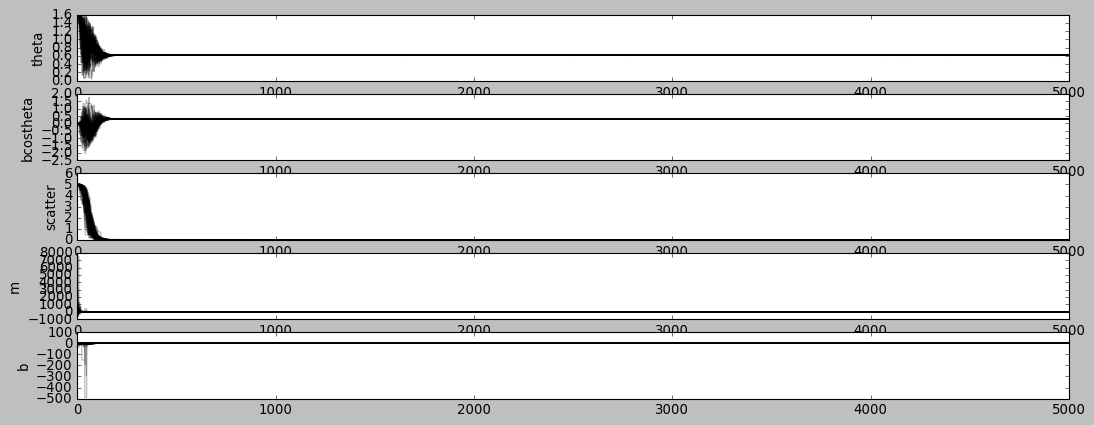

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.6360520000000001


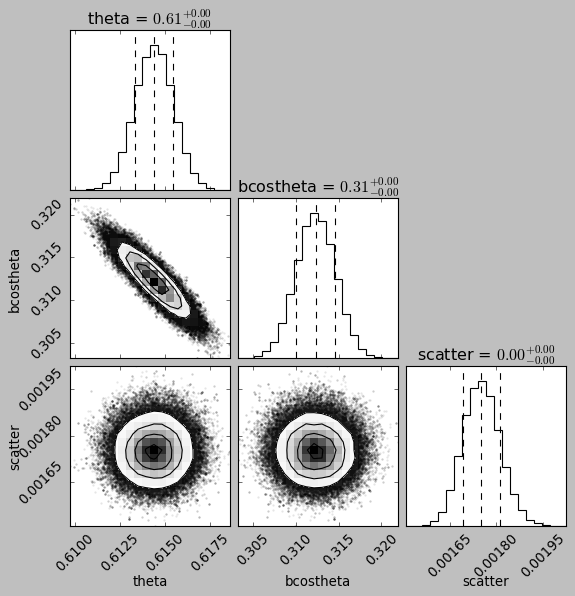

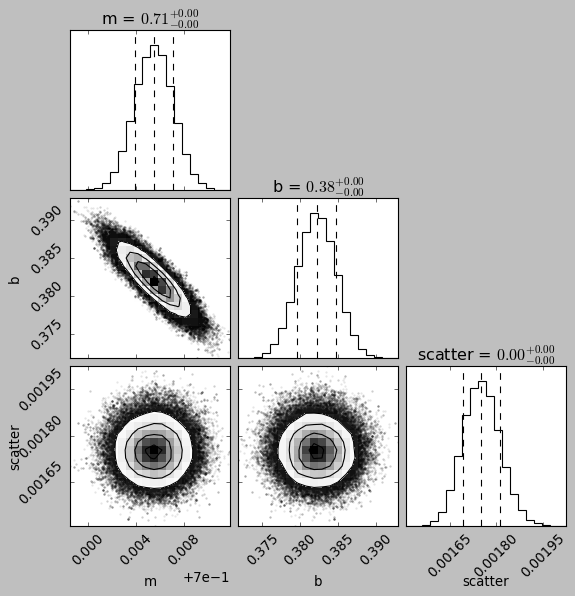

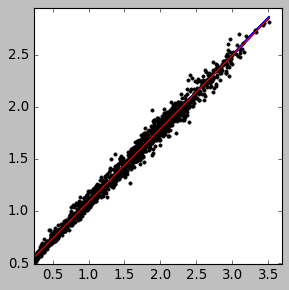

/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


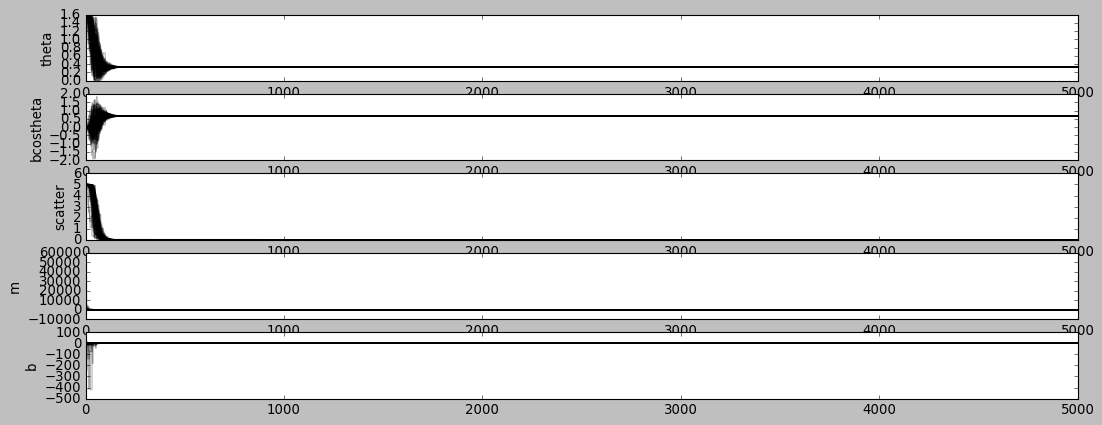

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.636456


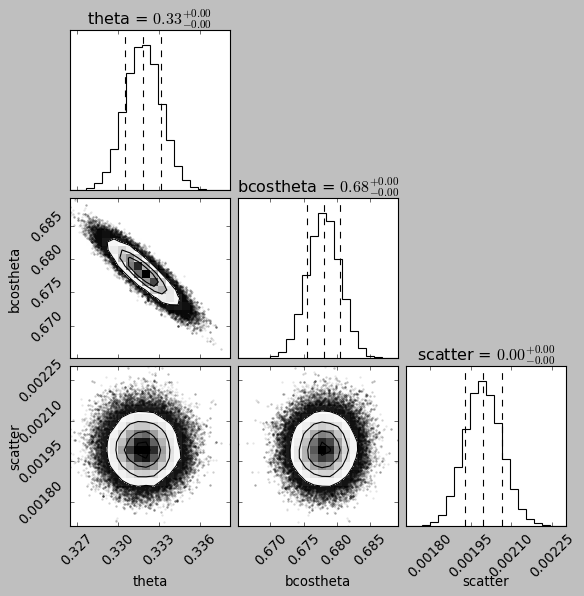

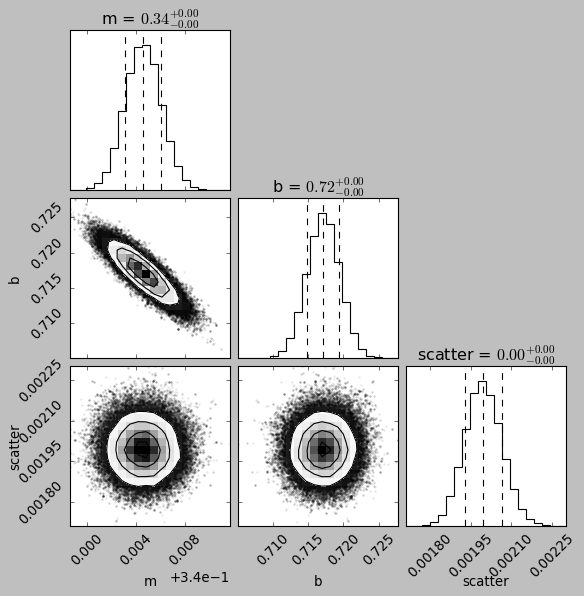

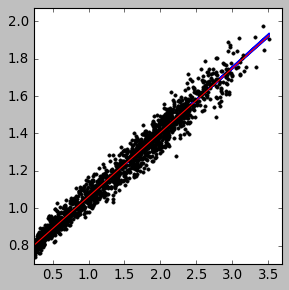

/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


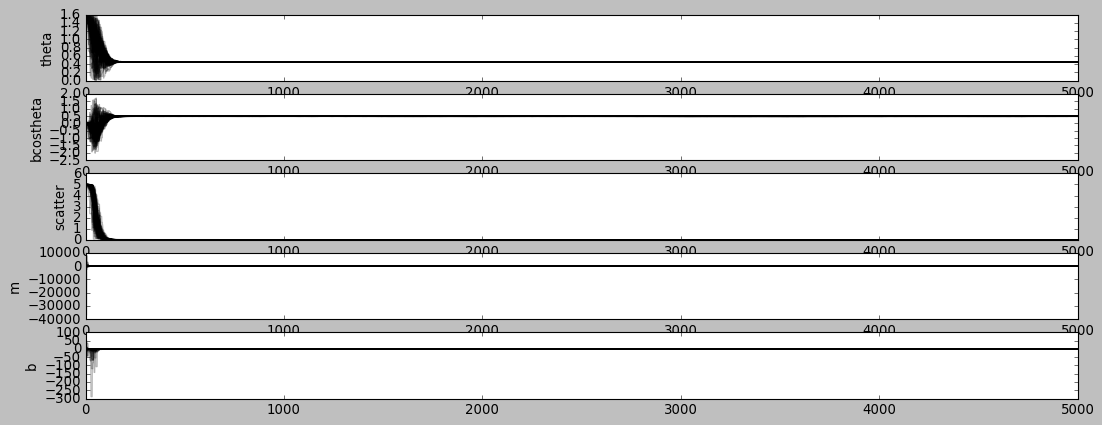

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.636114


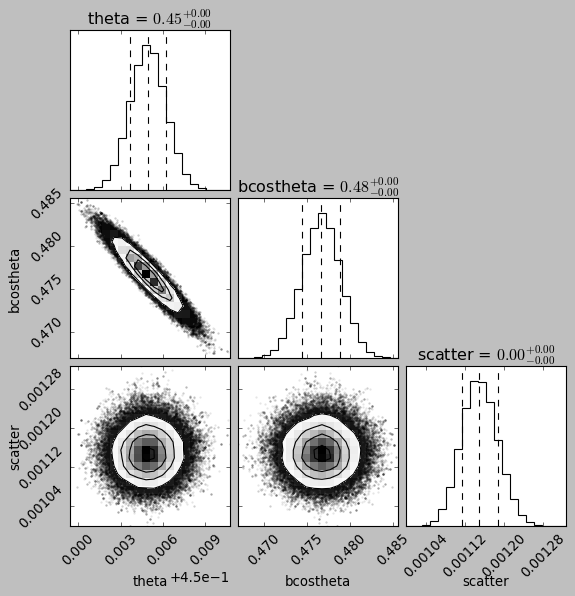

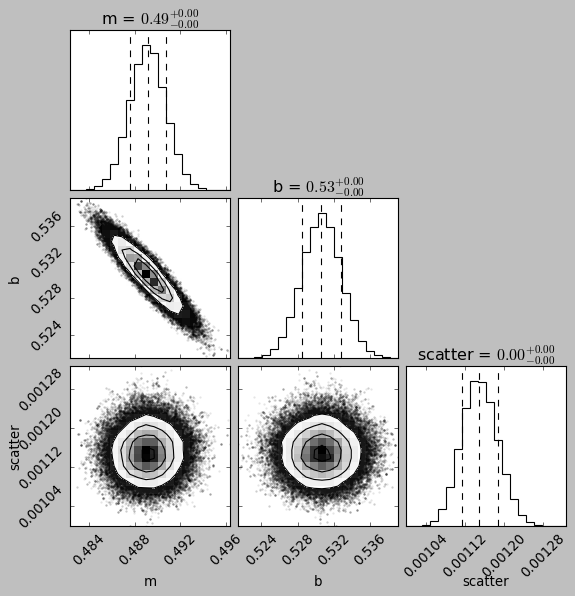

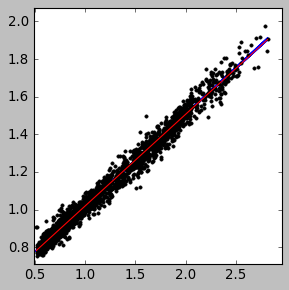

In [135]:
fArrs_to_plot = [f304_corrected_2008onwards, f284_corrected_2008onwards, f195_corrected_2008onwards, f171_corrected_2008onwards]
uArrs_to_plot = [u304_corrected_2008onwards, u284_corrected_2008onwards, u195_corrected_2008onwards, u171_corrected_2008onwards]
tArrs_to_plot = [t304, t284, t195, t171]


# before Nov 12, 2008 (first obvious bakeout discontinuity)
tstart = t304[0]
tend = 2454783.150532

lp_195_vs_284, lpstats_195_vs_284 = fit2EITBakeoutSegment(t1=t284, f1=f284_corrected_2008onwards, u1=u284_corrected_2008onwards, t2=t195, f2=f195_corrected_2008onwards, u2=u195_corrected_2008onwards, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_284, lpstats_171_vs_284 = fit2EITBakeoutSegment(t1=t284, f1=f284_corrected_2008onwards, u1=u284_corrected_2008onwards, t2=t171, f2=f171_corrected_2008onwards, u2=u171_corrected_2008onwards, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_195, lpstats_171_vs_195 = fit2EITBakeoutSegment(t1=t195, f1=f195_corrected_2008onwards, u1=u195_corrected_2008onwards, t2=t171, f2=f171_corrected_2008onwards, u2=u171_corrected_2008onwards, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

In [136]:
print(lpstats_171_vs_195)
print(lpstats_171_vs_195[2,1])
print(lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1])
print(lpstats_171_vs_195[2,1] - lpstats_171_vs_195[1,1])

print(lpstats_171_vs_284)

[[0.48757847 0.52845517 0.00111361]
 [0.48914538 0.53064795 0.00114942]
 [0.49072217 0.53280392 0.00118737]]
0.5328039249641963
0.0021927819531366577
0.0021559753451865227
[[0.34310063 0.71480854 0.00192874]
 [0.34456518 0.71713316 0.00199488]
 [0.34604764 0.71944405 0.0020644 ]]


In [137]:
# notation (for comparison with pages 232-239 of lab notebook)
# x = f284
# y = f195
# z = f171

alpha = lpstats_195_vs_284[1,0] # = slope of y vs. x = slope of f195 vs f284
beta  = lpstats_171_vs_284[1,0] # = slope of z vs. x = slope of f171 vs f284
gamma = lpstats_171_vs_195[1,0] # = slope of z vs. y = slope of f171 vs f195

#uncertainties
sigma_alpha = ((lpstats_195_vs_284[1,0] - lpstats_195_vs_284[0,0]) + (lpstats_195_vs_284[2,0] - lpstats_195_vs_284[1,0]))/2
sigma_beta = ((lpstats_171_vs_284[1,0] - lpstats_171_vs_284[0,0]) + (lpstats_171_vs_284[2,0] - lpstats_171_vs_284[1,0]))/2
sigma_gamma = ((lpstats_171_vs_195[1,0] - lpstats_171_vs_195[0,0]) + (lpstats_171_vs_195[2,0] - lpstats_171_vs_195[1,0]))/2

# unit vectors in the new coordinate system wrt the xyz coordinate system. l is parallel to the line of best fit, while j and k are perpendicular to it (and to each other)
j_xyz = (1./(np.sqrt(1 + (gamma**2 * alpha**2))*np.sqrt(1 + alpha**2 * (1 + gamma**2)))) * np.array(( -alpha, 1 + gamma**2 * alpha**2, -gamma * alpha**2 ))
k_xyz = (1./(np.sqrt(1 + gamma**2 * alpha**2))) * np.array((-gamma*alpha, 0, 1))
l_xyz = (1./(np.sqrt(1 + alpha**2 * (1 + gamma**2)))) * np.array((1, alpha, gamma*alpha))
transformation_matrix_xyz_to_jkl = np.vstack((j_xyz, k_xyz, l_xyz))
transformation_matrix_jkl_to_xyz = transformation_matrix_xyz_to_jkl.T


#analytic uncertainty propagation 
j_denom_fac = 1 + (alpha**2) + (2 * alpha**2 * gamma**2) + (gamma**2 * alpha**4) + (gamma**4 * alpha**4)

djx_dalpha = (-1*np.sqrt(j_denom_fac) + (alpha/2)*(j_denom_fac)**(-1/2.) * (2*alpha + 4*alpha*gamma**2 + 4*gamma**2*alpha**3 + 4*gamma**4*alpha**3))/j_denom_fac
djx_dgamma = (alpha * j_denom_fac**(-1./2) * (4*alpha**2 * gamma + 2*gamma*alpha**4 + 4*gamma**3*alpha**4))/j_denom_fac
sigma_jx = np.sqrt( (djx_dalpha*sigma_alpha)**2 + (djx_dgamma*sigma_gamma)**2 )

djy_dalpha = ( (2*alpha*gamma**2)*np.sqrt(j_denom_fac) - (1 + gamma**2 * alpha**2)*0.5*j_denom_fac**(-1./2)*(2*alpha + 4*alpha*gamma**2 + 4*gamma**2*alpha**3 + 4*gamma**4*alpha**3))/j_denom_fac
djy_dgamma = ( (2*gamma*alpha**2)*np.sqrt(j_denom_fac) - (1 + gamma**2 * alpha**2)*0.5*j_denom_fac**(-1./2)*(4*alpha**2 * gamma + 2*gamma*alpha**4 + 4*gamma**3*alpha**4))/j_denom_fac
sigma_jy = np.sqrt( (djy_dalpha*sigma_alpha)**2 + (djy_dgamma*sigma_gamma)**2 )

djz_dalpha = ( (-2*gamma*alpha)*np.sqrt(j_denom_fac) + (gamma*alpha**2)*0.5*j_denom_fac**(-1./2)*(2*alpha + 4*alpha*gamma**2 + 4*gamma**2*alpha**3 + 4*gamma**4*alpha**3))/j_denom_fac
djz_dgamma = ( (-alpha**2)*np.sqrt(j_denom_fac) + (gamma*alpha**2)*0.5*j_denom_fac**(-1./2)*(4*alpha**2 * gamma + 2*gamma*alpha**4 + 4*gamma**3*alpha**4))/j_denom_fac
sigma_jz = np.sqrt( (djz_dalpha*sigma_alpha)**2 + (djz_dgamma*sigma_gamma)**2 )

print(sigma_jx, sigma_jy, sigma_jz)


k_denom_fac = 1 + (gamma**2 * alpha**2)

dkx_dalpha = ( -gamma * np.sqrt(k_denom_fac) + (gamma*alpha)*0.5*k_denom_fac**(-1./2)*(2*gamma**2 *alpha))/k_denom_fac
dkx_dgamma = ( -alpha * np.sqrt(k_denom_fac) + (gamma*alpha)*0.5*k_denom_fac**(-1./2)*(2*alpha**2 *gamma))/k_denom_fac
sigma_kx = np.sqrt( (dkx_dalpha*sigma_alpha)**2 + (dkx_dgamma*sigma_gamma)**2 )

dky_dalpha = 0
dky_dgamma = 0
sigma_ky = np.sqrt( (dky_dalpha*sigma_alpha)**2 + (dky_dgamma*sigma_gamma)**2 )

dkz_dalpha = -1*k_denom_fac**(-3./2) * gamma**2 * alpha
dkz_dgamma = -1*k_denom_fac**(-3./2) * alpha**2 * gamma
sigma_kz = np.sqrt( (dkz_dalpha*sigma_alpha)**2 + (dkz_dgamma*sigma_gamma)**2 )

print(sigma_kx, sigma_ky, sigma_kz)


l_denom_fac = 1 + alpha**2 + (alpha**2 * gamma**2)

dlx_dalpha = -0.5*l_denom_fac**(-3/2.)*(2*alpha + 2*alpha*gamma**2)
dlx_dgamma =  -0.5*l_denom_fac**(-3/2.)*(2*gamma*alpha**2)
sigma_lx = np.sqrt( (dlx_dalpha*sigma_alpha)**2 + (dlx_dgamma*sigma_gamma)**2 )

dly_dalpha = ( np.sqrt(l_denom_fac) - alpha*0.5*l_denom_fac**(-1./2)*(2*alpha + 2*alpha*gamma**2))/l_denom_fac
dly_dgamma = (-alpha*0.5*l_denom_fac**(-1./2)*(2*gamma*alpha**2))/l_denom_fac
sigma_ly = np.sqrt( (dly_dalpha*sigma_alpha)**2 + (dly_dgamma*sigma_gamma)**2 )

dlz_dalpha = ( gamma*np.sqrt(l_denom_fac) - alpha*gamma*0.5*l_denom_fac**(-1./2)*(2*alpha + 2*alpha*gamma**2))/l_denom_fac
dlz_dgamma = ( alpha*np.sqrt(l_denom_fac) - alpha*gamma*0.5*l_denom_fac**(-1./2)*(2*gamma*alpha**2))/l_denom_fac
sigma_lz = np.sqrt( (dlz_dalpha*sigma_alpha)**2 + (dlz_dgamma*sigma_gamma)**2 )

print(sigma_lx, sigma_ly, sigma_lz)


def convert_xyz_to_jkl(xyz_coords, xyz_uncs):
    """
    both arguments are arrays of shape (3, N)
    """
    jkl_coords = np.matmul(transformation_matrix_xyz_to_jkl, xyz_coords)
    jkl_uncs = np.zeros_like(xyz_uncs)
    # j,k,l uncertainty
    jkl_uncs[0] = np.sqrt( xyz_coords[0]**2 * sigma_jx**2 + j_xyz[0]**2 * xyz_uncs[0]**2 + xyz_coords[1]**2 * sigma_jy**2 + j_xyz[1]**2 * xyz_uncs[1]**2 + xyz_coords[2]**2 * sigma_jz**2 + j_xyz[2]**2 * xyz_uncs[2]**2)
    jkl_uncs[1] = np.sqrt( xyz_coords[0]**2 * sigma_kx**2 + k_xyz[0]**2 * xyz_uncs[0]**2 + xyz_coords[1]**2 * sigma_ky**2 + k_xyz[1]**2 * xyz_uncs[1]**2 + xyz_coords[2]**2 * sigma_kz**2 + k_xyz[2]**2 * xyz_uncs[2]**2)
    jkl_uncs[2] = np.sqrt( xyz_coords[0]**2 * sigma_lx**2 + l_xyz[0]**2 * xyz_uncs[0]**2 + xyz_coords[1]**2 * sigma_ly**2 + l_xyz[1]**2 * xyz_uncs[1]**2 + xyz_coords[2]**2 * sigma_lz**2 + l_xyz[2]**2 * xyz_uncs[2]**2)
    return jkl_coords, jkl_uncs

def convert_jkl_to_xyz(jkl_coords, jkl_uncs):
    """
    both arguments are arrays of shape (3, N)
    """
    xyz_coords = np.matmul(transformation_matrix_jkl_to_xyz, jkl_coords)
    xyz_uncs = np.zeros_like(jkl_uncs)
    xyz_uncs[0] = np.sqrt( jkl_coords[0]**2 * sigma_jx**2 + j_xyz[0]**2 * jkl_uncs[0]**2 + jkl_coords[1]**2 * sigma_kx**2 + k_xyz[0]**2 * jkl_uncs[1]**2 + jkl_coords[2]**2 * sigma_lx**2 + l_xyz[0]**2 * jkl_uncs[2]**2 )
    xyz_uncs[1] = np.sqrt( jkl_coords[0]**2 * sigma_jy**2 + j_xyz[1]**2 * jkl_uncs[0]**2 + jkl_coords[1]**2 * sigma_ky**2 + k_xyz[1]**2 * jkl_uncs[1]**2 + jkl_coords[2]**2 * sigma_ly**2 + l_xyz[1]**2 * jkl_uncs[2]**2 )
    xyz_uncs[2] = np.sqrt( jkl_coords[0]**2 * sigma_jz**2 + j_xyz[2]**2 * jkl_uncs[0]**2 + jkl_coords[1]**2 * sigma_kz**2 + k_xyz[2]**2 * jkl_uncs[1]**2 + jkl_coords[2]**2 * sigma_lz**2 + l_xyz[2]**2 * jkl_uncs[2]**2 )
    return xyz_coords, xyz_uncs

0.0008588256399802059 0.0005250781998047013 0.0007814804503386682
0.0011455427323303193 0.0 0.000395308502338709
0.0007037850315106848 0.0007873507148576321 0.000892670910732404


In [138]:
# this whole cell is testing
'''
#points on the line of best fit (see below cell)
l0 = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))
t = np.linspace(0., 10, 500)
lp_x = l0[0] + t
lp_y = l0[1] + t*alpha
lp_z = l0[2] + t*beta

fig, axes = plt.subplots(2,2,figsize=(12,12))
overlap_t, t195_ind, t284_ind = np.intersect1d(np.round(t195,0), np.round(t284,0), return_indices=True)
x =  f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
y =  f195_corrected_2008onwards[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])
c_s = axes[0,0].scatter(x, y, c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',alpha=0.5,zorder=0)
x = f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
xtest = np.arange(5)
axes[0,0].plot(x, lpstats_195_vs_284[1,0]*x + lpstats_195_vs_284[1,1],'r')
axes[0,0].plot(l0[0], l0[1], 'ko',markersize=10)
axes[0,0].plot(lp_x, lp_y, 'k-')

overlap_t, t171_ind, t284_ind = np.intersect1d(np.round(t171,0), np.round(t284,0), return_indices=True)
x = f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
y = f171_corrected_2008onwards[t171_ind]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)])
c_s = axes[1,0].scatter(x,y, c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',alpha=0.5,zorder=0)
axes[1,0].plot(x, lpstats_171_vs_284[1,0]*x + lpstats_171_vs_284[1,1],'r')
axes[1,0].plot(l0[0], l0[2], 'ko',markersize=10)
axes[1,0].plot(lp_x, lp_z, 'k-')

overlap_t, t171_ind, t195_ind = np.intersect1d(np.round(t171,0), np.round(t195,0), return_indices=True)
x = f195_corrected_2008onwards[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])
y = f171_corrected_2008onwards[t171_ind]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)])
c_s = axes[1,1].scatter(x,y, c=t195[t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',alpha=0.5,zorder=0)
axes[1,1].plot(x, lpstats_171_vs_195[1,0]*x + lpstats_171_vs_195[1,1],'r')
axes[1,1].plot(l0[1], l0[2], 'ko',markersize=10)
axes[1,1].plot(lp_y, lp_z, 'k-')


axes[1,1].set_xlabel('f195')
axes[1,0].set_xlabel('f284')
axes[1,0].set_ylabel('f171')
axes[0,0].set_ylabel('f195')
for ax in np.ravel(axes):
    ax.set_xlim(0.,3.5)
    ax.set_ylim(0.,3.5)

plt.show()
'''

"\n#points on the line of best fit (see below cell)\nl0 = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))\nt = np.linspace(0., 10, 500)\nlp_x = l0[0] + t\nlp_y = l0[1] + t*alpha\nlp_z = l0[2] + t*beta\n\nfig, axes = plt.subplots(2,2,figsize=(12,12))\noverlap_t, t195_ind, t284_ind = np.intersect1d(np.round(t195,0), np.round(t284,0), return_indices=True)\nx =  f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])\ny =  f195_corrected_2008onwards[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])\nc_s = axes[0,0].scatter(x, y, c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',alpha=0.5,zorder=0)\nx = f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])\nxtest = np.arange(5)\naxes[0,0].plot(x, lpstats_195_vs_284[1,0]*x + lpstats_195_vs_284[1,1],'r')\naxes[0,0].plot(l0[0], l0[1], 'ko',markersize=10)\na

[-0.12526616  0.09831658  0.16144394]
[0.07471277 0.07344015 0.08139879]


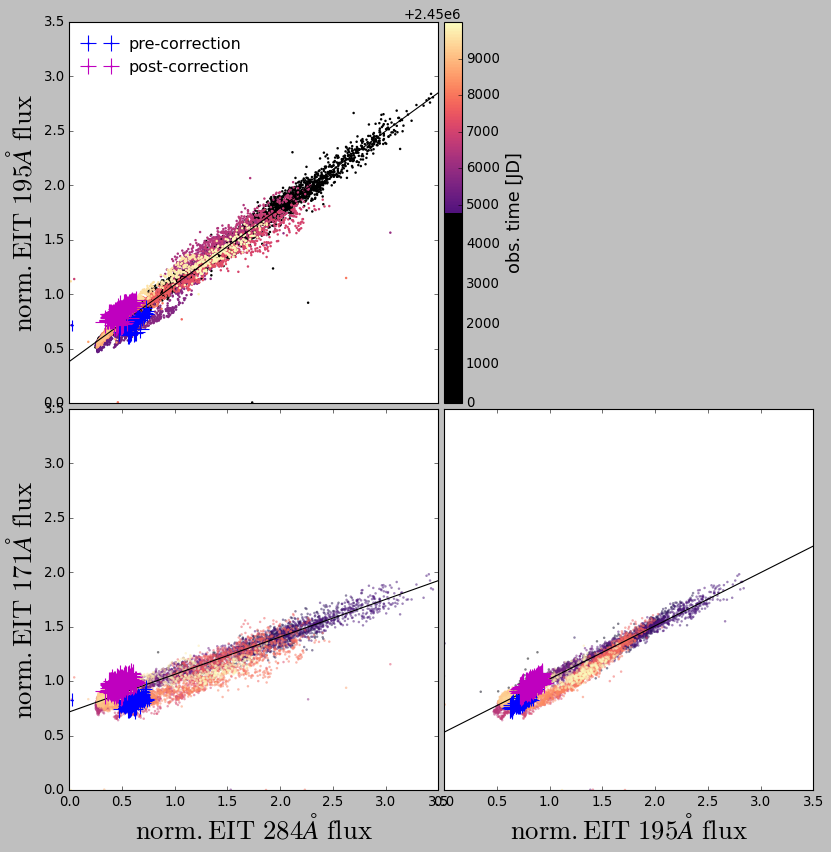

In [139]:
# this whole cell is testing


#test = convert_xyz_to_jkl(l_xyz)
#print(test)

#test = convert_jkl_to_xyz(np.array((j_xyz[2], k_xyz[2], l_xyz[2])))
#print(test)

# test the lineup correction procedure on the last obviously bad bakeout (the segment before the f304 exponential trend begins)
#tLastBadBakeoutBegins = 2455765.033727
#tsplit_exp1 = 2455938.417

t1 = 2455388.033727 #last bad bakeout begins
t2 = 2455602.033727 #tsplit_exp1

#t1 = 2455313.150532
#t2 = 2455398.150532

#t1 = 2455602.150532
#t2 = 2455761.150532

fitMask_t284 = (t284 >= t1) & (t284 <= t2) 
fitMask_t195 = (t195 >= t1) & (t195 <= t2) 
fitMask_t171 = (t171 >= t1) & (t171 <= t2) 

# may need to pick these more carefully so that they correspond to the same observation time
b_f284 = f284_corrected_2008onwards[fitMask_t284][0]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
b_f195 = f195_corrected_2008onwards[fitMask_t195][0]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])
b_f171 = f171_corrected_2008onwards[fitMask_t171][0]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)])

b_f284_unc = u284_corrected_2008onwards[fitMask_t284][0]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
b_f195_unc = u195_corrected_2008onwards[fitMask_t195][0]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])
b_f171_unc = u171_corrected_2008onwards[fitMask_t171][0]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)])


b0_xyz = np.array((b_f284, b_f195, b_f171))
b0_xyz_unc = np.array((b_f284_unc, b_f195_unc, b_f171_unc))
#print(b0_xyz)
#print(b0_xyz_unc)

b0_jkl, b0_jkl_unc = convert_xyz_to_jkl(b0_xyz, b0_xyz_unc)
#print(b0_jkl)
#print(b0_jkl_unc)

#points on the line of best fit
# this is a point on the line, deduced by setting x = 0 and then solving for y and z in the three projected line equations
l0_xyz = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))
l0_xyz_unc = np.array((((lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]) +  (lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]))/2.,
                       ((lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]) +  (lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]))/2.,
                       ((lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]) +  (lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]))/2.))

#print(l0_xyz)
#print(l0_xyz_unc)

l0_jkl, l0_jkl_unc = convert_xyz_to_jkl(l0_xyz, l0_xyz_unc)
#print(l0_jkl)
#print(l0_jkl_unc)
# therefore an array of points along the line can be obtained by:
# (parametric form of the line is (x-x0)/1 = (y-y0)/alpha = (z-z0)/beta )
t = np.linspace(-10, 10, 10000)
lp_x = l0_xyz[0] + t
lp_y = l0_xyz[1] + t*alpha
lp_z = l0_xyz[2] + t*beta
lp_xyz = np.vstack((lp_x, lp_y, lp_z))
#print(np.shape(lp_xyz))
lp_xyz_unc = np.zeros_like(lp_xyz)
lp_xyz_unc[0] = l0_xyz_unc[0]*np.ones_like(lp_xyz_unc[0])
lp_xyz_unc[1] = np.sqrt(l0_xyz_unc[1]**2  + t**2 * sigma_alpha**2)
lp_xyz_unc[2] = np.sqrt(l0_xyz_unc[2]**2  + t**2 * sigma_beta**2)

#print(lp_xyz)
#print(lp_xyz_unc)

lp_jkl, lp_jkl_unc = convert_xyz_to_jkl(lp_xyz, lp_xyz_unc)
#print(lp_jkl)
#print(lp_jkl_unc)

# find the point on the line that is perpendicularly closest to b0_jkl
closestIdx = np.argmin(np.abs(lp_jkl[2] - b0_jkl[2]))
#print(closestIdx)

#print(lp_jkl[:,closestIdx])
lambda_j = lp_jkl[0,closestIdx] - b0_jkl[0]
lambda_k = lp_jkl[1,closestIdx] - b0_jkl[1]
lambda_l = lp_jkl[2,closestIdx] - b0_jkl[2]
lambda_jkl = np.array((lambda_j, lambda_k, lambda_l))

lambda_jkl_unc = np.array(( np.sqrt(lp_jkl_unc[0,closestIdx]**2 + b0_jkl_unc[0]**2), np.sqrt(lp_jkl_unc[1,closestIdx]**2 + b0_jkl_unc[1]**2), np.sqrt(lp_jkl_unc[2,closestIdx]**2 + b0_jkl_unc[2]**2) ))

lambda_xyz, lambda_xyz_unc = convert_jkl_to_xyz(lambda_jkl, lambda_jkl_unc)
print(lambda_xyz)
print(lambda_xyz_unc)

test_f284 = (f284_corrected_2008onwards[fitMask_t284]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])) + lambda_xyz[0]
test_f195 = (f195_corrected_2008onwards[fitMask_t195]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])) + lambda_xyz[1]
test_f171 = (f171_corrected_2008onwards[fitMask_t171]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)])) + lambda_xyz[2]

test_u284 = np.sqrt(u284_corrected_2008onwards[fitMask_t284]**2 + (lambda_xyz_unc[0] * np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]))**2)
test_u195 = np.sqrt(u195_corrected_2008onwards[fitMask_t195]**2 + (lambda_xyz_unc[1] * np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]))**2)
test_u171 = np.sqrt(u171_corrected_2008onwards[fitMask_t171]**2 + (lambda_xyz_unc[2] * np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]))**2)
'''
fig, axes = plt.subplots(3,1,figsize=(6,12))
axes[0].errorbar(t284[fitMask_t284], f284_corrected_2008onwards[fitMask_t284], yerr=u284_corrected_2008onwards[fitMask_t284], color='k', marker='.',elinewidth=1,capsize=0,linestyle='-')
axes[0].errorbar(t284[fitMask_t284], test_f284*np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]), yerr=test_u284, color='r', marker='.',elinewidth=1,capsize=0,linestyle='-')
#axes[0].plot(u284_corrected_2008onwards[fitMask_t284], test_u284, 'k.')
#axes[0].plot(np.arange(100000), np.arange(100000), 'k:')

axes[1].errorbar(t195[fitMask_t195], f195_corrected_2008onwards[fitMask_t195], yerr=u195_corrected_2008onwards[fitMask_t195], color='k', marker='.',elinewidth=1,capsize=0,linestyle='-')
axes[1].errorbar(t195[fitMask_t195], test_f195*np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]), yerr=test_u195, color='r', marker='.',elinewidth=1,capsize=0,linestyle='-')


axes[2].errorbar(t171[fitMask_t171], f171_corrected_2008onwards[fitMask_t171], yerr=u171_corrected_2008onwards[fitMask_t171], color='k', marker='.',elinewidth=1,capsize=0,linestyle='-')
axes[2].errorbar(t171[fitMask_t171], test_f171*np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]), yerr=test_u171, color='r', marker='.',elinewidth=1,capsize=0,linestyle='-')

plt.show()
'''
class MidpointNormalize(clrs.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)


nov12 = 2454783.150532
colors_black = np.zeros((256,4))
colors_black[:,-1] = 1.
colors_plasma = plt.cm.magma(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_black, colors_plasma))
black_to_plasma = clrs.LinearSegmentedColormap.from_list(
    'black_to_plasma', all_colors)


fig, axes = plt.subplots(2,2,figsize=(12,12),)

overlap_t, t195_ind, t284_ind = np.intersect1d(np.round(t195,0), np.round(t284,0), return_indices=True)
midnorm = MidpointNormalize(vmin=2450000, vcenter=nov12, vmax=2460000)

divider00 = make_axes_locatable(axes[0,1])
cax00 = divider00.append_axes('left',size='5%', pad=0)
c_s = axes[0,0].scatter(f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]), 
                        f195_corrected_2008onwards[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]), 
                        c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap=black_to_plasma,alpha=1,zorder=1,norm=midnorm)
cbar = fig.colorbar(c_s, cax=cax00, orientation='vertical',)
cbar.ax.set_yticks(np.arange(2450000,2460000,1000))
cbar.set_label(label='obs. time [JD]',fontsize=16)

x = f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
xtest = np.arange(5)
#axes[0,0].plot(x, lpstats_195_vs_284[1,0]*x + lpstats_195_vs_284[1,1],'r')
#axes[0,0].plot(l0[0], l0[1], 'ko',markersize=10)
axes[0,0].plot(lp_x, lp_y, 'k-')

toPlot = (overlap_t > t1) & (overlap_t <= t2)

axes[0,0].errorbar(f284_corrected_2008onwards[t284_ind][toPlot]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]),
                   f195_corrected_2008onwards[t195_ind][toPlot]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]),
                   xerr=u284_corrected_2008onwards[t284_ind][toPlot]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]),
                   yerr=u195_corrected_2008onwards[t195_ind][toPlot]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]),
                   color='b',elinewidth=1,marker='.',ms=3,capsize=0,ls='None',zorder=2,label='pre-correction')

overlap_t, t195_ind, t284_ind = np.intersect1d(np.round(t195[fitMask_t195],0), np.round(t284[fitMask_t284],0), return_indices=True)
axes[0,0].errorbar(test_f284[t284_ind],
                   test_f195[t195_ind],
                   xerr=test_u284[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]),
                   yerr=test_u195[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]),
                   color='m',elinewidth=1,marker='.',ms=3,capsize=0,ls='None',zorder=3,label='post-correction')
axes[0,0].legend(loc='upper left',frameon=False)

overlap_t, t171_ind, t284_ind = np.intersect1d(np.round(t171,0), np.round(t284,0), return_indices=True)
c_s = axes[1,0].scatter(f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]), f171_corrected_2008onwards[t171_ind]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]), c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',alpha=0.5,zorder=1)
x = f284_corrected_2008onwards[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)])
#axes[1,0].plot(x, lpstats_171_vs_284[1,0]*x + lpstats_171_vs_284[1,1],'r')
#axes[1,0].plot(l0[0], l0[2], 'ko',markersize=10)
axes[1,0].plot(lp_x, lp_z, 'k-')

toPlot = (overlap_t > t1) & (overlap_t <= t2)
axes[1,0].errorbar(f284_corrected_2008onwards[t284_ind][toPlot]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]),
                   f171_corrected_2008onwards[t171_ind][toPlot]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]),
                   xerr=u284_corrected_2008onwards[t284_ind][toPlot]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]),
                   yerr=u171_corrected_2008onwards[t171_ind][toPlot]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]),
                   color='b',elinewidth=1,marker='.',ms=3,capsize=0,ls='None',zorder=2)

overlap_t, t171_ind, t284_ind = np.intersect1d(np.round(t171[fitMask_t171],0), np.round(t284[fitMask_t284],0), return_indices=True)
axes[1,0].errorbar(test_f284[t284_ind],
                   test_f171[t171_ind],
                   xerr=test_u284[t284_ind]/np.median(f284_corrected_2008onwards[~np.isnan(f284_corrected_2008onwards)]),
                   yerr=test_u171[t171_ind]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]),
                   color='m',elinewidth=1,marker='.',ms=3,capsize=0,ls='None',zorder=3)

overlap_t, t171_ind, t195_ind = np.intersect1d(np.round(t171,0), np.round(t195,0), return_indices=True)
c_s = axes[1,1].scatter(f195_corrected_2008onwards[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]), f171_corrected_2008onwards[t171_ind]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]), c=t195[t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',alpha=0.5,zorder=1)
x = f195_corrected_2008onwards[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)])
#axes[1,1].plot(x, lpstats_171_vs_195[1,0]*x + lpstats_171_vs_195[1,1],'r')
#axes[1,1].plot(l0[1], l0[2], 'ko',markersize=10)
axes[1,1].plot(lp_y, lp_z, 'k-')

toPlot = (overlap_t > t1) & (overlap_t <= t2)
axes[1,1].errorbar(f195_corrected_2008onwards[t195_ind][toPlot]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]),
                   f171_corrected_2008onwards[t171_ind][toPlot]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]), 
                   xerr=u195_corrected_2008onwards[t195_ind][toPlot]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]),
                   yerr=u171_corrected_2008onwards[t171_ind][toPlot]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]),
                   color='b',elinewidth=1,marker='.',ms=3,capsize=0,ls='None',zorder=2)

overlap_t, t171_ind, t195_ind = np.intersect1d(np.round(t171[fitMask_t171],0), np.round(t195[fitMask_t195],0), return_indices=True)
axes[1,1].errorbar(test_f195[t195_ind],
                   test_f171[t171_ind],
                   xerr=test_u195[t195_ind]/np.median(f195_corrected_2008onwards[~np.isnan(f195_corrected_2008onwards)]),
                   yerr=test_u171[t171_ind]/np.median(f171_corrected_2008onwards[~np.isnan(f171_corrected_2008onwards)]),
                   color='m',elinewidth=1,marker='.',ms=3,capsize=0,ls='None',zorder=3)


axes[1,1].set_xlabel(r'$\mathrm{norm. EIT}\ 195\AA\ \mathrm{flux}$',fontsize=24)
axes[1,0].set_xlabel(r'$\mathrm{norm. EIT}\ 284\AA\ \mathrm{flux}$',fontsize=24)
axes[1,0].set_ylabel(r'$\mathrm{norm. EIT}\ 171\AA\ \mathrm{flux}$',fontsize=24)
axes[0,0].set_ylabel(r'$\mathrm{norm. EIT}\ 195\AA\ \mathrm{flux}$',fontsize=24)
axes[0,1].axis('off')
for ax in np.ravel(axes):
    ax.set_xlim(0.,3.5)
    ax.set_ylim(0.,3.5)

plt.subplots_adjust(hspace=0.015,wspace=0.015)
axes[0,0].set_xticks([])
axes[1,1].set_yticks([])

#plt.show()
plt.savefig("./bakeoutLineupCorrection.pdf",bbox_inches='tight')


In [140]:
print(np.min(t284[t284_ind]))
print(np.max(t284[t284_ind]))
print(nov12)

2450190.228552
2450949.795214
2454783.150532


In [141]:
# yet new arrays to work with for 2008 onwards
f284_corrected_2008onwards_bakeoutlineup = copy.deepcopy(f284_corrected_2008onwards)
u284_corrected_2008onwards_bakeoutlineup = copy.deepcopy(u284_corrected_2008onwards)
f195_corrected_2008onwards_bakeoutlineup = copy.deepcopy(f195_corrected_2008onwards)
u195_corrected_2008onwards_bakeoutlineup = copy.deepcopy(u195_corrected_2008onwards)
f171_corrected_2008onwards_bakeoutlineup = copy.deepcopy(f171_corrected_2008onwards)
u171_corrected_2008onwards_bakeoutlineup = copy.deepcopy(u171_corrected_2008onwards)

# values that the flux and uncertainty arrays were normalized by before the straight-line fit to pre-Nov 12, 2008 was done
f284_norm_2008onwards = np.median(f284_corrected_2008onwards)
f195_norm_2008onwards = np.median(f195_corrected_2008onwards)
f171_norm_2008onwards = np.median(f171_corrected_2008onwards)
#print(f284_norm, f195_norm, f171_norm)

for j in range(80):
    tstart = heaterOff[j]['jd']
    tend = heaterOn[j+1]['jd']

    #mask out some points in f284 (during a flare? anomalously high) that I suspect are causing problems with the transposition
    if heaterOff[j]['jd'] >= 2455930 and heaterOn[j]['jd'] < 2456110:
        print('here')
        fitMask_t284 = (t284 >= heaterOff[j]['jd']) & (t284 <= heaterOn[j+1]['jd']) & (f284_corrected_2008onwards/norm <= 1.75)
    else:
        fitMask_t284 = (t284 >= heaterOff[j]['jd']) & (t284 <= heaterOn[j+1]['jd']) 
    fitMask_t195 = (t195 >= heaterOff[j]['jd']) & (t195 <= heaterOn[j+1]['jd']) 
    fitMask_t171 = (t171 >= heaterOff[j]['jd']) & (t171 <= heaterOn[j+1]['jd'])

    f284_thisbakeout = f284_corrected_2008onwards[fitMask_t284]/f284_norm_2008onwards
    f195_thisbakeout = f195_corrected_2008onwards[fitMask_t195]/f195_norm_2008onwards
    f171_thisbakeout = f171_corrected_2008onwards[fitMask_t171]/f171_norm_2008onwards

    u284_thisbakeout = u284_corrected_2008onwards[fitMask_t284]/f284_norm_2008onwards
    u195_thisbakeout = u195_corrected_2008onwards[fitMask_t195]/f195_norm_2008onwards
    u171_thisbakeout = u171_corrected_2008onwards[fitMask_t171]/f171_norm_2008onwards

    b0_f284 = np.median(f284_thisbakeout)
    b0_f195 = np.median(f195_thisbakeout)
    b0_f171 = np.median(f171_thisbakeout)

    b0_f284_unc = np.mean(u284_thisbakeout) * np.sqrt(np.pi/2)
    b0_f195_unc = np.mean(u195_thisbakeout) * np.sqrt(np.pi/2)
    b0_f171_unc = np.mean(u171_thisbakeout) * np.sqrt(np.pi/2)

    b0_xyz = np.array((b0_f284, b0_f195, b0_f171))
    b0_xyz_unc = np.array((b0_f284_unc, b0_f195_unc, b0_f171_unc))

    b0_jkl, b0_jkl_unc = convert_xyz_to_jkl(b0_xyz, b0_xyz_unc)

    #points on the line of best fit        
    # this is a point on the line, deduced by setting x = 0 and then solving for y and z in the three projected line equations
    l0_xyz = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))
    l0_xyz_unc = np.array((((lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]) +  (lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]))/2.,
                            ((lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]) +  (lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]))/2.,
                            ((lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]) +  (lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]))/2.))

    l0_jkl, l0_jkl_unc = convert_xyz_to_jkl(l0_xyz, l0_xyz_unc)

    # therefore an array of points along the line can be obtained by:
    # (parametric form of the line is (x-x0)/1 = (y-y0)/alpha = (z-z0)/beta )
    t = np.linspace(-10, 10, 10000)
    lp_x = l0_xyz[0] + t
    lp_y = l0_xyz[1] + t*alpha
    lp_z = l0_xyz[2] + t*beta
    lp_xyz = np.vstack((lp_x, lp_y, lp_z))

    lp_xyz_unc = np.zeros_like(lp_xyz)
    lp_xyz_unc[0] = l0_xyz_unc[0]*np.ones_like(lp_xyz_unc[0])
    lp_xyz_unc[1] = np.sqrt(l0_xyz_unc[1]**2  + t**2 * sigma_alpha**2)
    lp_xyz_unc[2] = np.sqrt(l0_xyz_unc[2]**2  + t**2 * sigma_beta**2)

    lp_jkl, lp_jkl_unc = convert_xyz_to_jkl(lp_xyz, lp_xyz_unc)
        
    # find the point on the line that is perpendicularly closest to b0_jkl
    closestIdx = np.argmin(np.abs(lp_jkl[2] - b0_jkl[2]))

    lambda_j = lp_jkl[0,closestIdx] - b0_jkl[0]
    lambda_k = lp_jkl[1,closestIdx] - b0_jkl[1]
    lambda_l = lp_jkl[2,closestIdx] - b0_jkl[2]
    lambda_jkl = np.array((lambda_j, lambda_k, lambda_l))

    lambda_jkl_unc = np.array(( np.sqrt(lp_jkl_unc[0,closestIdx]**2 + b0_jkl_unc[0]**2), np.sqrt(lp_jkl_unc[1,closestIdx]**2 + b0_jkl_unc[1]**2), np.sqrt(lp_jkl_unc[2,closestIdx]**2 + b0_jkl_unc[2]**2) ))

    lambda_xyz, lambda_xyz_unc = convert_jkl_to_xyz(lambda_jkl, lambda_jkl_unc)

    # correct the fluxes
    f284_corr = f284_thisbakeout + lambda_xyz[0]
    f195_corr = f195_thisbakeout + lambda_xyz[1]
    f171_corr = f171_thisbakeout + lambda_xyz[2]

    u284_corr = np.sqrt(u284_thisbakeout**2 + lambda_xyz_unc[0]**2)
    u195_corr = np.sqrt(u195_thisbakeout**2 + lambda_xyz_unc[1]**2)
    u171_corr = np.sqrt(u171_thisbakeout**2 + lambda_xyz_unc[2]**2)
    
    # Nov 12, 2008 (first bakeout with obvious discontinuity, coinciding w/end of solar cycle 23) to beginning of f304 exponential trend on January 11 2012
    if heaterOff[j]['jd'] >= 2454783.150532:# and heaterOff[j]['jd'] <= 2455938.417:
        f284_corrected_2008onwards_bakeoutlineup[fitMask_t284] = f284_corr*f284_norm_2008onwards
        f195_corrected_2008onwards_bakeoutlineup[fitMask_t195] = f195_corr*f195_norm_2008onwards
        f171_corrected_2008onwards_bakeoutlineup[fitMask_t171] = f171_corr*f171_norm_2008onwards

        u284_corrected_2008onwards_bakeoutlineup[fitMask_t284] = u284_corr*f284_norm_2008onwards
        u195_corrected_2008onwards_bakeoutlineup[fitMask_t195] = u195_corr*f195_norm_2008onwards
        u171_corrected_2008onwards_bakeoutlineup[fitMask_t171] = u171_corr*f171_norm_2008onwards
    
#final segment, after all bakeouts
fitMask_t284 = (t284 >= heaterOff[-1]['jd']) & (t284 <= t284[-1]) 
fitMask_t195 = (t195 >= heaterOff[-1]['jd']) & (t195 <= t195[-1]) 
fitMask_t171 = (t171 >= heaterOff[-1]['jd']) & (t171 <= t171[-1])

f284_thisbakeout = f284_corrected_2008onwards[fitMask_t284]/f284_norm_2008onwards
f195_thisbakeout = f195_corrected_2008onwards[fitMask_t195]/f195_norm_2008onwards
f171_thisbakeout = f171_corrected_2008onwards[fitMask_t171]/f171_norm_2008onwards

u284_thisbakeout = u284_corrected_2008onwards[fitMask_t284]/f284_norm_2008onwards
u195_thisbakeout = u195_corrected_2008onwards[fitMask_t195]/f195_norm_2008onwards
u171_thisbakeout = u171_corrected_2008onwards[fitMask_t171]/f171_norm_2008onwards

b0_f284 = np.median(f284_thisbakeout)
b0_f195 = np.median(f195_thisbakeout)
b0_f171 = np.median(f171_thisbakeout)

b0_f284_unc = np.mean(u284_thisbakeout) * np.sqrt(np.pi/2)
b0_f195_unc = np.mean(u195_thisbakeout) * np.sqrt(np.pi/2)
b0_f171_unc = np.mean(u171_thisbakeout) * np.sqrt(np.pi/2)

b0_xyz = np.array((b0_f284, b0_f195, b0_f171))
b0_xyz_unc = np.array((b0_f284_unc, b0_f195_unc, b0_f171_unc))

b0_jkl, b0_jkl_unc = convert_xyz_to_jkl(b0_xyz, b0_xyz_unc)

#points on the line of best fit
# this is a point on the line, deduced by setting x = 0 and then solving for y and z in the three projected line equations
l0_xyz = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))
l0_xyz_unc = np.array((((lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]) +  (lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]))/2.,
                        ((lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]) +  (lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]))/2.,
                        ((lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]) +  (lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]))/2.))

l0_jkl, l0_jkl_unc = convert_xyz_to_jkl(l0_xyz, l0_xyz_unc)

# therefore an array of points along the line can be obtained by:
# (parametric form of the line is (x-x0)/1 = (y-y0)/alpha = (z-z0)/beta )
t = np.linspace(-10, 10, 10000)
lp_x = l0_xyz[0] + t
lp_y = l0_xyz[1] + t*alpha
lp_z = l0_xyz[2] + t*beta
lp_xyz = np.vstack((lp_x, lp_y, lp_z))

lp_xyz_unc = np.zeros_like(lp_xyz)
lp_xyz_unc[0] = l0_xyz_unc[0]*np.ones_like(lp_xyz_unc[0])
lp_xyz_unc[1] = np.sqrt(l0_xyz_unc[1]**2  + t**2 * sigma_alpha**2)
lp_xyz_unc[2] = np.sqrt(l0_xyz_unc[2]**2  + t**2 * sigma_beta**2)

lp_jkl, lp_jkl_unc = convert_xyz_to_jkl(lp_xyz, lp_xyz_unc)
        
# find the point on the line that is perpendicularly closest to b0_jkl
closestIdx = np.argmin(np.abs(lp_jkl[2] - b0_jkl[2]))

lambda_j = lp_jkl[0,closestIdx] - b0_jkl[0]
lambda_k = lp_jkl[1,closestIdx] - b0_jkl[1]
lambda_l = lp_jkl[2,closestIdx] - b0_jkl[2]
lambda_jkl = np.array((lambda_j, lambda_k, lambda_l))

lambda_jkl_unc = np.array(( np.sqrt(lp_jkl_unc[0,closestIdx]**2 + b0_jkl_unc[0]**2), np.sqrt(lp_jkl_unc[1,closestIdx]**2 + b0_jkl_unc[1]**2), np.sqrt(lp_jkl_unc[2,closestIdx]**2 + b0_jkl_unc[2]**2) ))

lambda_xyz, lambda_xyz_unc = convert_jkl_to_xyz(lambda_jkl, lambda_jkl_unc)

# correct the fluxes
f284_corr = f284_thisbakeout + lambda_xyz[0]
f195_corr = f195_thisbakeout + lambda_xyz[1]
f171_corr = f171_thisbakeout + lambda_xyz[2]

u284_corr = np.sqrt(u284_thisbakeout**2 + lambda_xyz_unc[0]**2)
u195_corr = np.sqrt(u195_thisbakeout**2 + lambda_xyz_unc[1]**2)
u171_corr = np.sqrt(u171_thisbakeout**2 + lambda_xyz_unc[2]**2)

f284_corrected_2008onwards_bakeoutlineup[fitMask_t284] = f284_corr*f284_norm_2008onwards
f195_corrected_2008onwards_bakeoutlineup[fitMask_t195] = f195_corr*f195_norm_2008onwards
f171_corrected_2008onwards_bakeoutlineup[fitMask_t171] = f171_corr*f171_norm_2008onwards

u284_corrected_2008onwards_bakeoutlineup[fitMask_t284] = u284_corr*f284_norm_2008onwards
u195_corrected_2008onwards_bakeoutlineup[fitMask_t195] = u195_corr*f195_norm_2008onwards
u171_corrected_2008onwards_bakeoutlineup[fitMask_t171] = u171_corr*f171_norm_2008onwards


here


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5158691.155804405


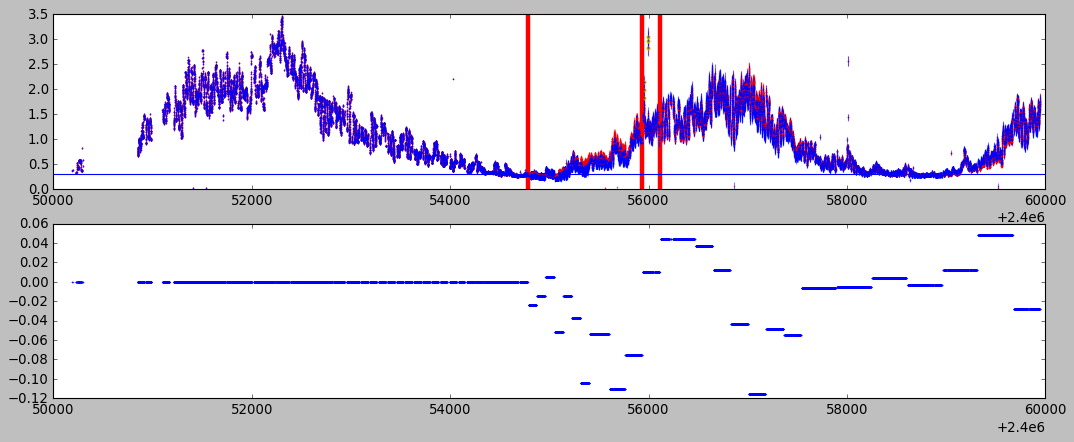

54433861.2217148


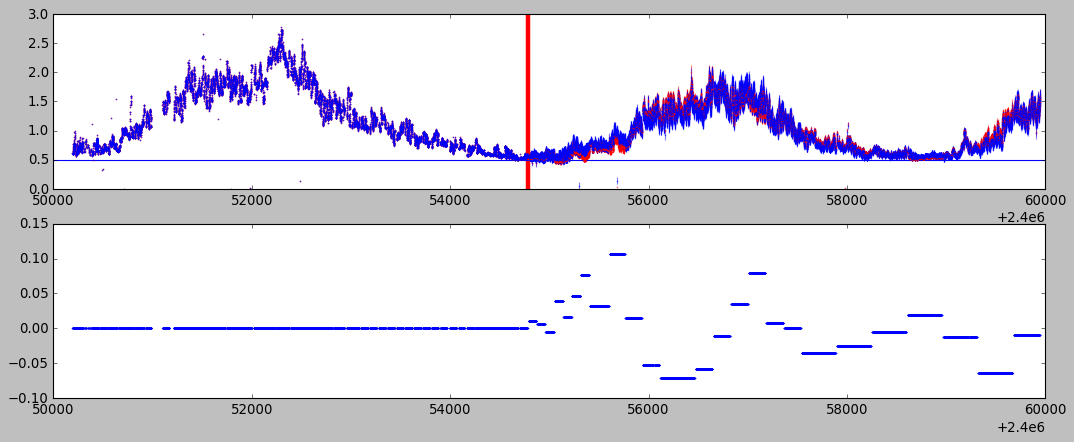

90350650.93731563


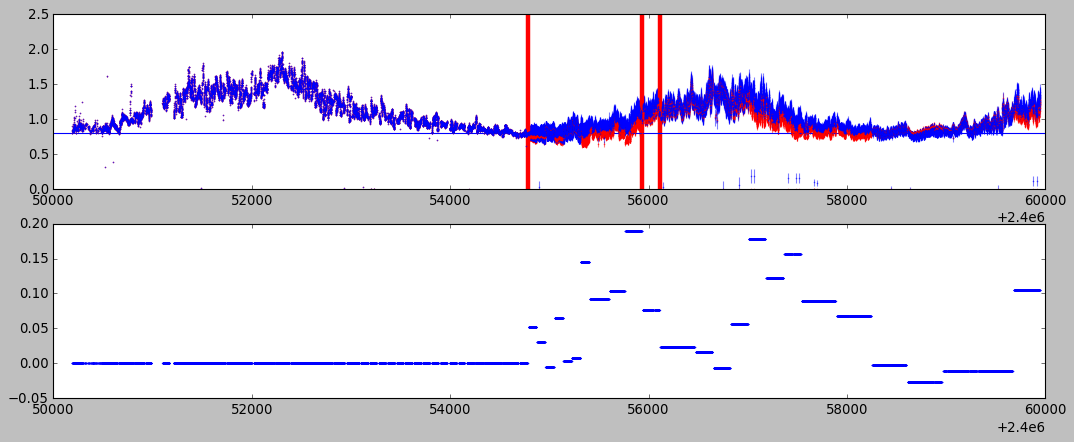

In [142]:
norm = np.median(f284[~np.isnan(f284)])
print(norm)
fig, axes = plt.subplots(2,1,figsize=(16,6))
#axes[0].errorbar(t284, f284/norm, u284/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
#axes[0].errorbar(t284, f284_corrected_all/norm, u284_corrected_all/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5,zorder=2)
#axes[0].errorbar(t284, f284_corrected_all_bakeoutlineup/norm, u284_corrected_all_bakeoutlineup/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5,zorder=1)

axes[0].errorbar(t284, f284_corrected_2008onwards/norm, u284_corrected_2008onwards/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[0].errorbar(t284, f284_corrected_2008onwards_bakeoutlineup/norm, u284_corrected_2008onwards_bakeoutlineup/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[1].plot(t284, f284_corrected_2008onwards_bakeoutlineup/norm - f284_corrected_2008onwards/norm, color='b',marker='.',markersize=2,linestyle='None',alpha=0.5)

tomaskout = (t284 > 2455938.417) & (t284 < 2456118.033727) & (f284_corrected_2008onwards/norm > 1.75)

axes[0].plot(t284[tomaskout], f284_corrected_2008onwards[tomaskout]/norm, 'y.')

axes[0].axvline(2454783.150532, color='r', lw=4)

axes[0].axvline(2455938.417, color='r', lw=4)
axes[0].axvline(2456118.033727, color='r', lw=4)
axes[0].axhline(0.3,color='b')
#ax.set_ylim(0.,1.e8)
axes[0].set_ylim(0.,3.5)
#axes[0].set_xlim(2455500, 2456500)
plt.show()

norm = np.median(f195[~np.isnan(f195)])
print(norm)
fig, axes = plt.subplots(2,1,figsize=(16,6))
#axes[0].errorbar(t195, f195/norm, u195/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
#axes[0].errorbar(t195, f195_corrected_all/norm, u195_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[0].errorbar(t195, f195_corrected_2008onwards/norm, u195_corrected_2008onwards/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[0].errorbar(t195, f195_corrected_2008onwards_bakeoutlineup/norm, u195_corrected_2008onwards_bakeoutlineup/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[1].plot(t195, f195_corrected_2008onwards_bakeoutlineup/norm - f195_corrected_2008onwards/norm, color='b',marker='.',markersize=2,linestyle='None',alpha=0.5)

axes[0].axvline(2454783.150532, color='r', lw=4)
axes[0].axhline(0.5,color='b')
#ax.set_ylim(0.,1.e8)
axes[0].set_ylim(0.,3.0)
plt.show()

norm = np.median(f171[~np.isnan(f171)])
print(norm)
fig, axes = plt.subplots(2,1,figsize=(16,6))
#axes[0].errorbar(t171, f171/norm, u171/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
#axes[0].errorbar(t171, f171_corrected_all/norm, u171_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[0].errorbar(t171, f171_corrected_2008onwards/norm, u171_corrected_2008onwards/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[0].errorbar(t171, f171_corrected_2008onwards_bakeoutlineup/norm, u171_corrected_2008onwards_bakeoutlineup/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
axes[1].plot(t171, f171_corrected_2008onwards_bakeoutlineup/norm - f171_corrected_2008onwards/norm, color='b',marker='.',markersize=2,linestyle='None',alpha=0.5)

axes[0].axvline(2454783.150532, color='r', lw=4)
axes[0].axvline(2455938.417, color='r', lw=4)
axes[0].axvline(2456118.033727, color='r', lw=4)
axes[0].axhline(0.8,color='b')
#axes[0].set_ylim(0.,1.e8)
axes[0].set_ylim(0.,2.5)
plt.show()

# Plot post-all corrections

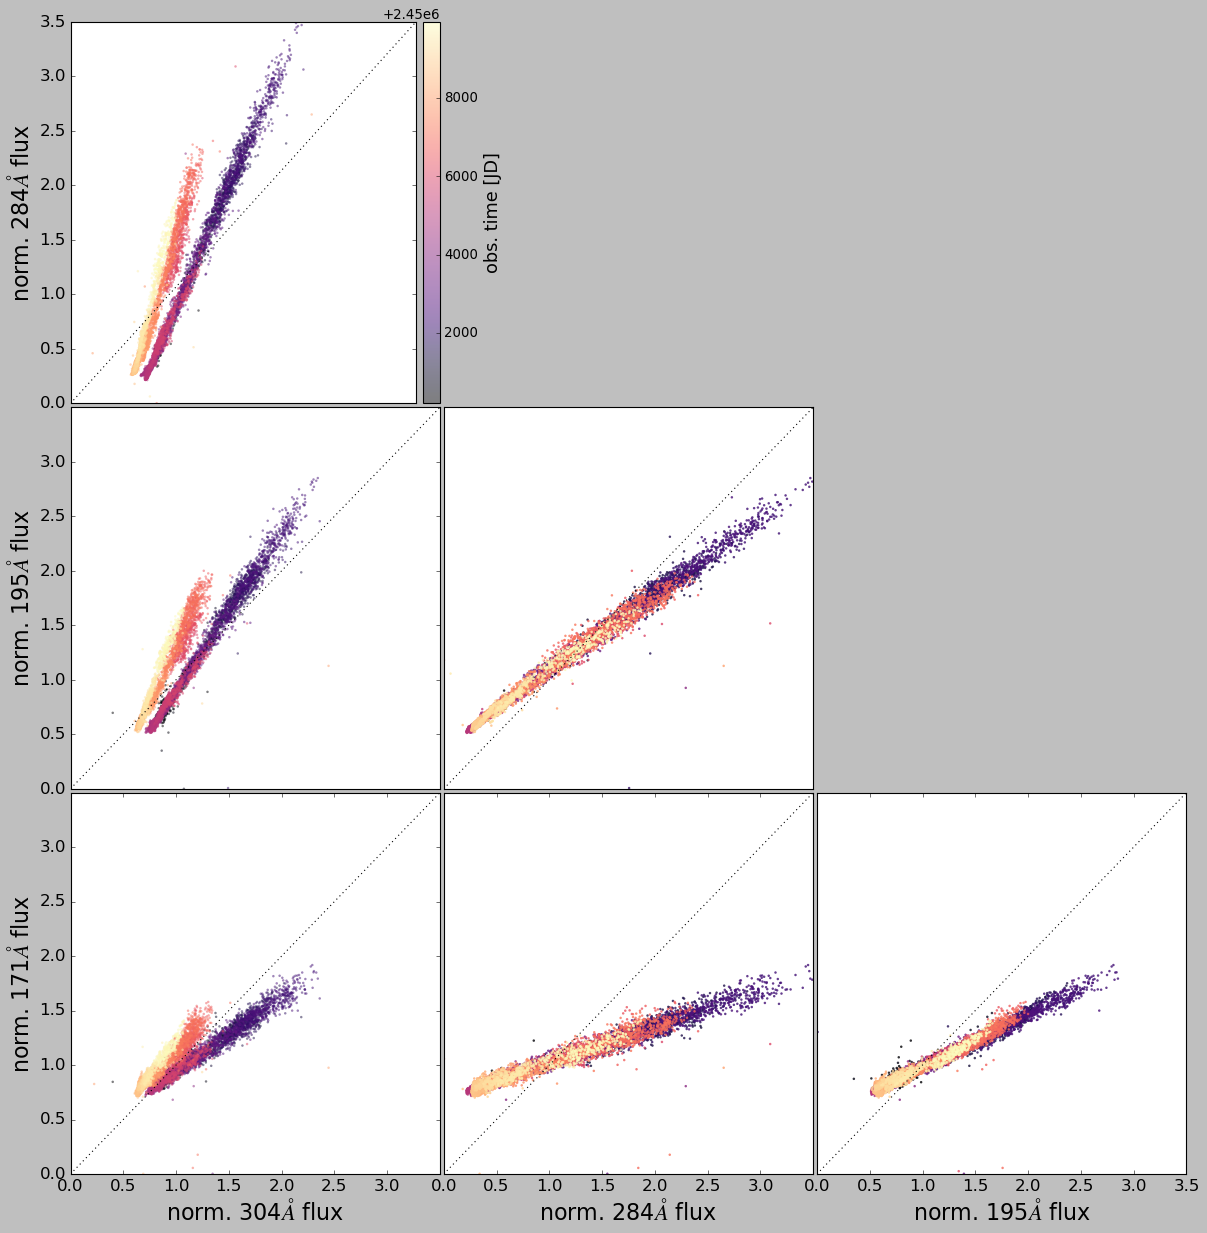

In [148]:
#fArrs_to_plot = [f304_corrected_all, f284_corrected_all, f195_corrected_all, f171_corrected_all]
#fArrs_to_plot = [f304_corrected_2008onwards, f284_corrected_2008onwards, f195_corrected_2008onwards, f171_corrected_2008onwards]
#uArrs_to_plot = [u304_corrected_2008onwards, u284_corrected_2008onwards, u195_corrected_2008onwards, u171_corrected_2008onwards]

fArrs_to_plot = [f304_corrected_2008onwards, f284_corrected_2008onwards_bakeoutlineup, f195_corrected_2008onwards_bakeoutlineup, f171_corrected_2008onwards_bakeoutlineup]
uArrs_to_plot = [u304_corrected_2008onwards, u284_corrected_2008onwards_bakeoutlineup, u195_corrected_2008onwards_bakeoutlineup, u171_corrected_2008onwards_bakeoutlineup]

tArrs_to_plot = [t304, t284, t195, t171]


# nov 12, 2008 (first bakeout with obvious discontinuity)
tsplit_1 = 2454783.150532

tLastBadBakeoutBegins = 2455765.033727

# beginning of f304 first exponential trend
tsplit_exp1 = 2455938.417
# beginning of f304 second exponential trend
tsplit_exp2 = 2457542.583333

fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):

    overlap_t, tEIT_i_ind, t304_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[0],0), return_indices=True)

    split0 = (overlap_t <= tsplit_1)
    split1 = (overlap_t > tLastBadBakeoutBegins) & (overlap_t <= tsplit_exp1)
    split_exp1 = (overlap_t > tsplit_exp1) & (overlap_t <= 2456111.033727)#tsplit_exp2)
    split_exp2 = (overlap_t > tsplit_exp2)
    
    c_s = axes[i-1,0].scatter(fArrs_to_plot[0][t304_ind]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[0][t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.5,zorder=0)

    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split0]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split0]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'k.',zorder=1,alpha=0.1)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'k.',zorder=2,alpha=1)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'b.',zorder=3,alpha=0.4)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp2]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp2]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'g.',zorder=4,alpha=0.4)
    
   
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="obs. time [JD]")
        cbar.set_label(label="obs. time [JD]",fontsize=16)
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"norm. 304$\AA$ flux",fontsize=20)
axes[0,0].set_ylabel(r"norm. 284$\AA$ flux",fontsize=20)
axes[1,0].set_ylabel(r"norm. 195$\AA$ flux",fontsize=20)
axes[2,0].set_ylabel(r"norm. 171$\AA$ flux",fontsize=20)


for i in range(2,4):
    overlap_t, tEIT_i_ind, t284_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[1],0), return_indices=True)
    
    axes[i-1,1].scatter(fArrs_to_plot[1][t284_ind]/np.median(fArrs_to_plot[1][~np.isnan(fArrs_to_plot[1])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[1][t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"norm. 284$\AA$ flux",fontsize=20)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    overlap_t, tEIT_i_ind, t195_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[2],0), return_indices=True)
    
    axes[i-1,2].scatter(fArrs_to_plot[2][t195_ind]/np.median(fArrs_to_plot[2][~np.isnan(fArrs_to_plot[2])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[2][t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"norm. 195$\AA$ flux",fontsize=20)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.plot(np.arange(5),np.arange(5),color='k',ls=':')
    ax.tick_params(axis='both', which='major', labelsize=15)

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])

axes[2,0].set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0])
axes[1,0].set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0])
axes[2,0].set_xticks([0.,0.5,1.0,1.5,2.0,2.5,3.0])
axes[2,1].set_xticks([0.,0.5,1.0,1.5,2.0,2.5,3.0])

plt.subplots_adjust(hspace=0.01,wspace=0.01)

plt.savefig("./ratio_EITbands_to_eachother_2008onwards_bakeoutlineup.pdf",bbox_inches="tight")
#plt.show()

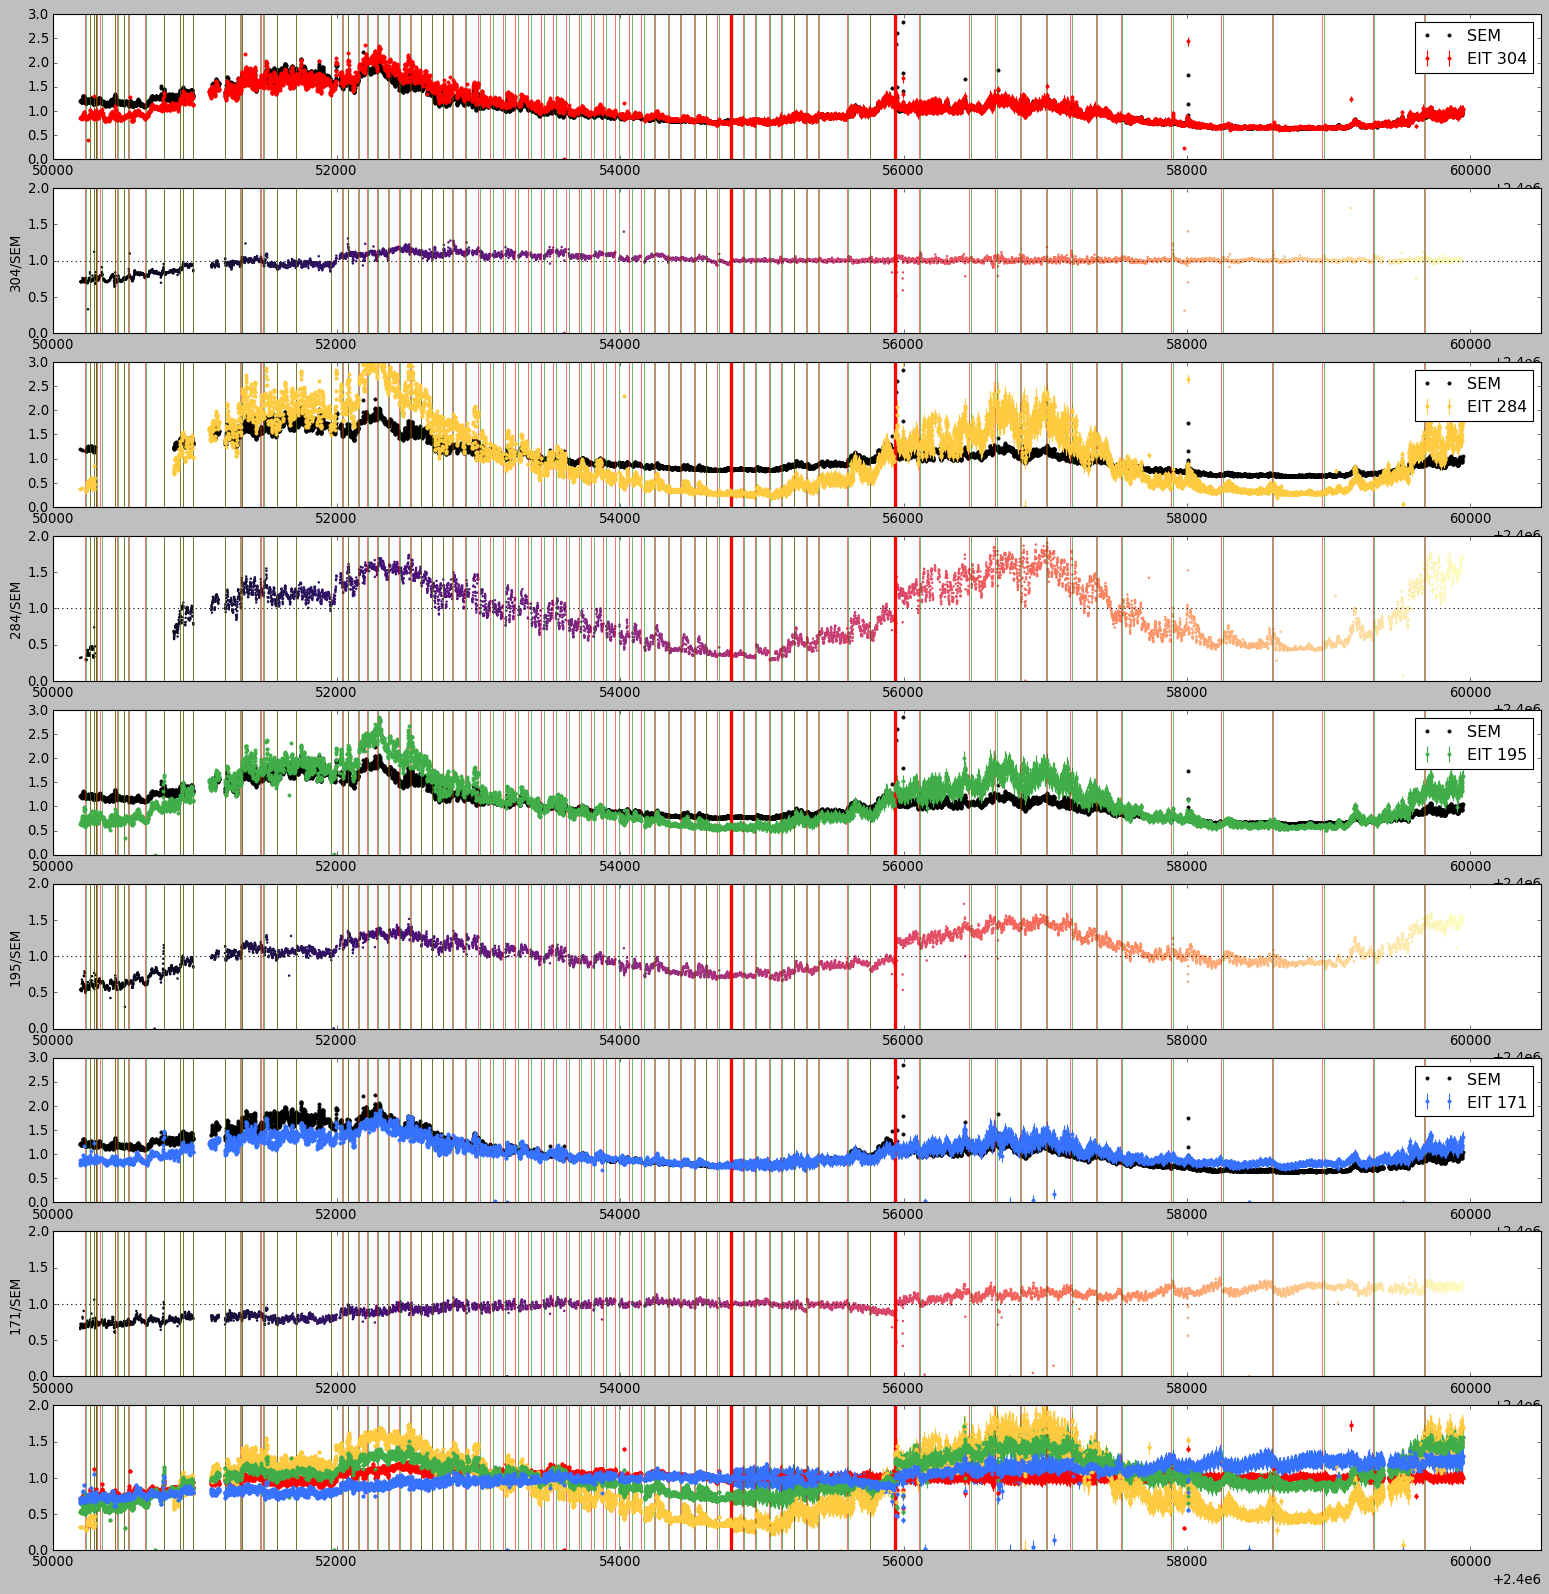

In [149]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    tEIT = tArrs_to_plot[i]
    fEIT = fArrs_to_plot[i]
    uEIT = uArrs_to_plot[i]

    overlap_t, tEIT_ind, tSEM_ind = np.intersect1d(np.round(tEIT,0), np.round(tSEM,0), return_indices=True)
    axes[2*i].plot(tSEM[tSEM_ind], fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)]), 'k.',label='SEM')
    axes[2*i].errorbar(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]),capsize=0,elinewidth=1)
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].scatter(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),c=tEIT[tEIT_ind], marker='.',cmap='magma',edgecolor='None')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),marker='.',ls='None',color=cs[i])
    axes[8].errorbar(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),yerr=(uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),marker='.',ls='None',elinewidth=1,capsize=0,color=cs[i])
    
    axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

    #ax.axvline(2455406.162303, color='r',lw=3) #end of bakeout July 28 2010
    #ax.axvline(2455609.162303, color='r',lw=3) #end of bakeout 16 Feb 2011

    ax.axvline(2454783.150532, color='r', lw=3) #Nov 12, 2008
    ax.axvline(2455938.417, color='r', lw=3) # Jan 11, 2012, beginning of first 304 exponential trend, end of obvious bakeout offsets

#plt.show()
plt.savefig("./ratio_EITbands_to_SEM1stOrder_2008onwards_bakeoutlineup.pdf",bbox_inches="tight")

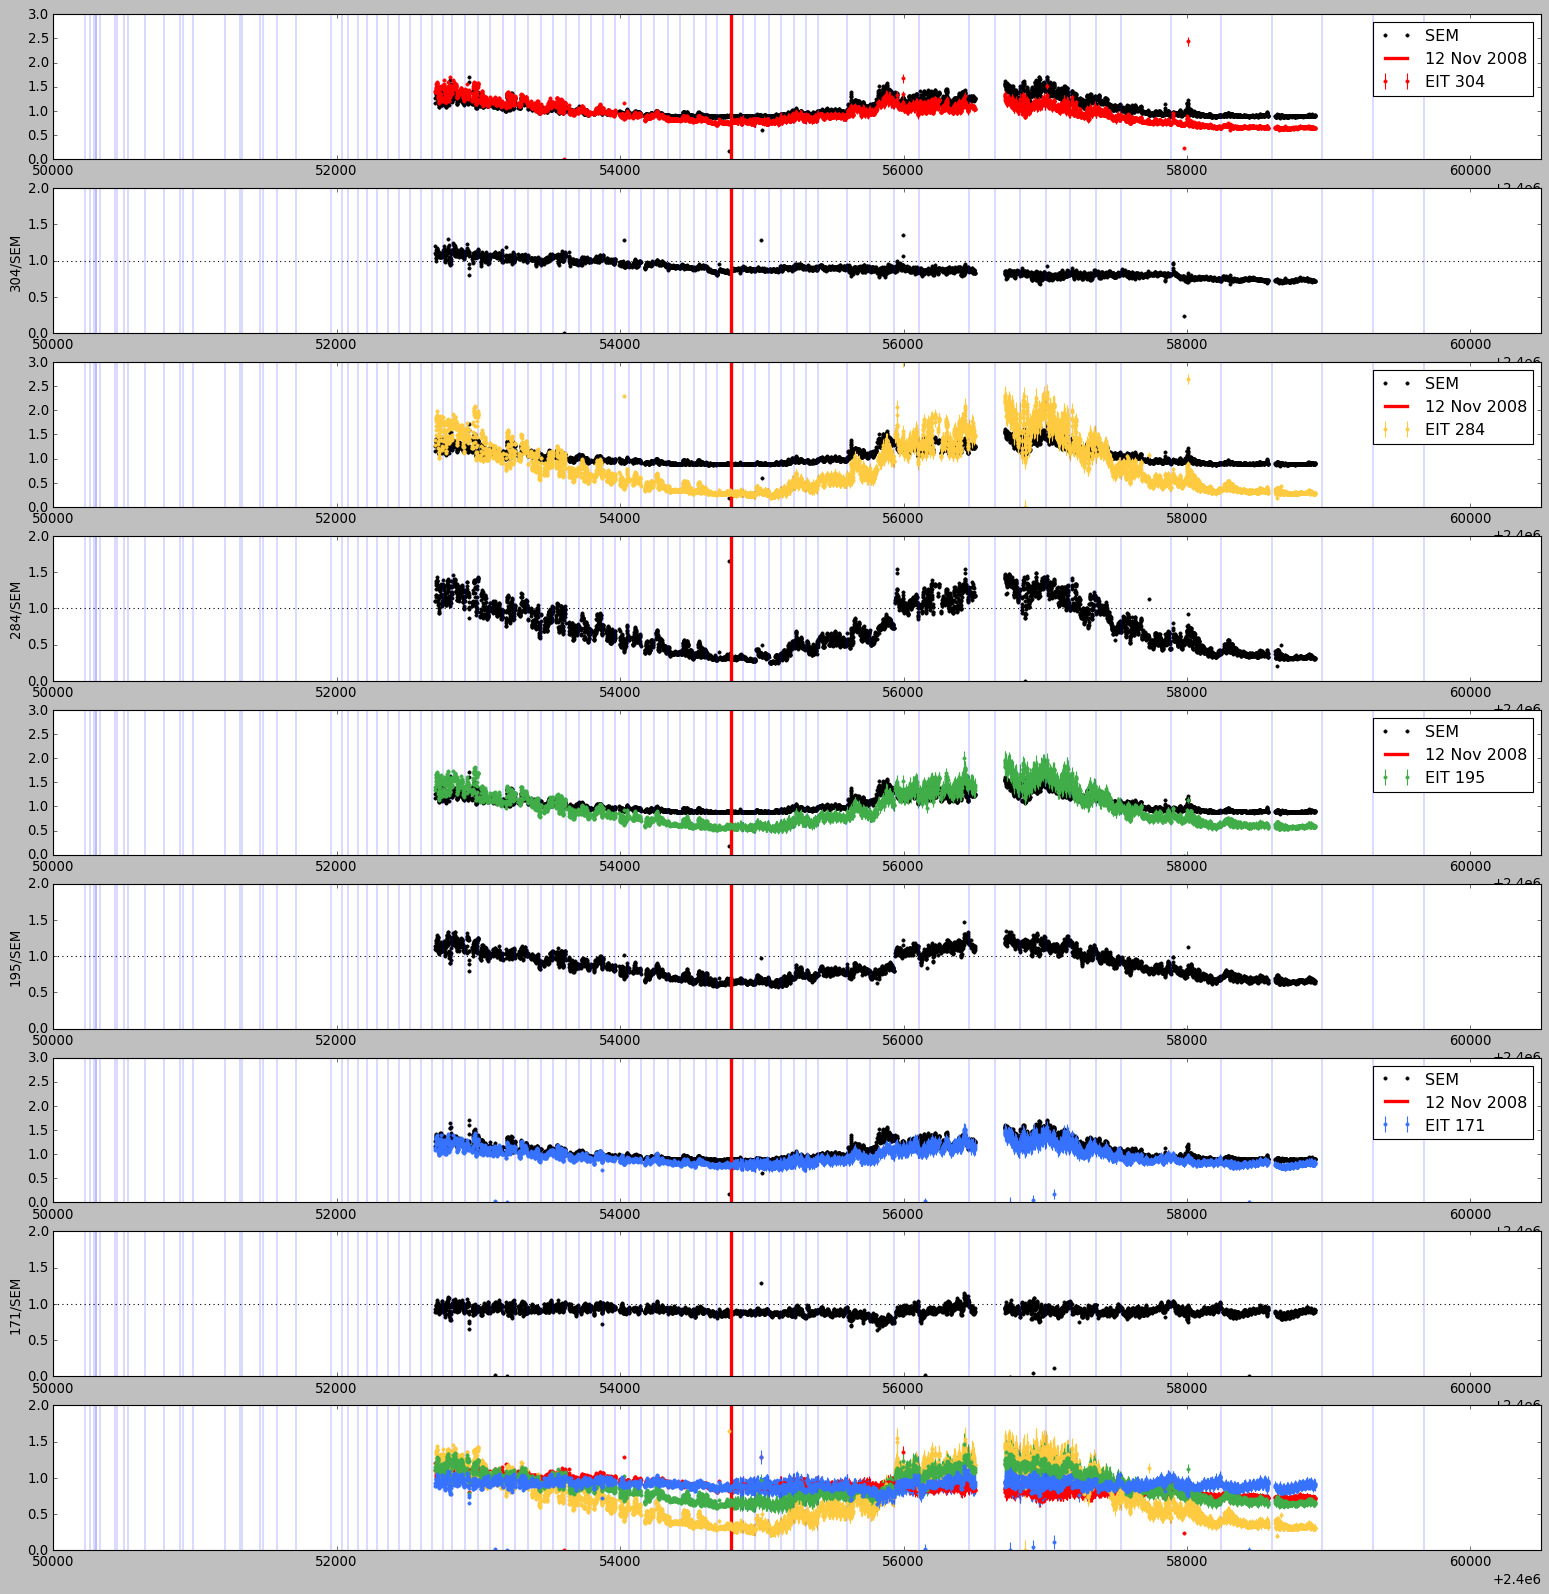

In [153]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    tEIT = tArrs_to_plot[i]
    fEIT = fArrs_to_plot[i]
    uEIT = uArrs_to_plot[i]

    overlap_t, tEIT_ind, tSORCE_ind = np.intersect1d(np.round(tEIT,0), np.round(tSORCE,0), return_indices=True)
    axes[2*i].plot(tSORCE[tSORCE_ind], fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)]), 'k.',label='SEM')
    axes[2*i].errorbar(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]),capsize=0,elinewidth=1)
    axes[2*i].set_ylim(0.,3.)
    
    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),'k.')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))

    axes[8].errorbar(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])), (uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)])), marker='.',ls='None',color=cs[i],capsize=0,elinewidth=1)
    axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        #ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

    ax.axvline(2454783.150532, color='r', lw=3,label='12 Nov 2008') #Nov 12, 2008
    #ax.axvline(2455938.417, color='r', lw=3) # Jan 11, 2012, beginning of first 304 exponential trend, end of obvious bakeout offsets

for i in range(4):
    axes[2*i].legend(loc='upper right')


#plt.show()
plt.savefig("./ratio_EITbands_to_SORCE_2008onwards_bakeoutlineup.pdf",bbox_inches="tight")

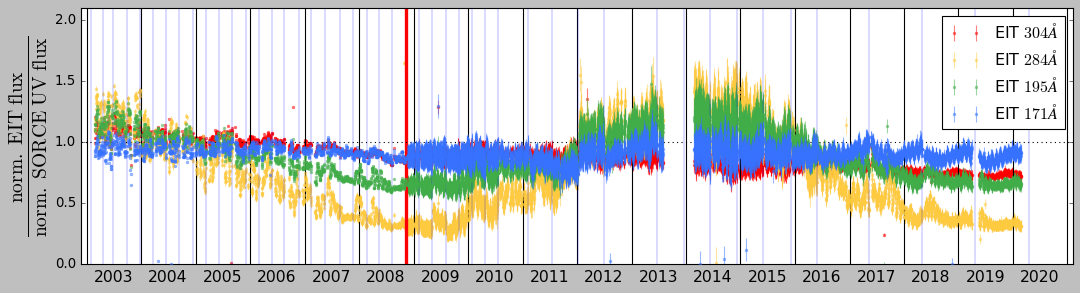

In [193]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
#ax.axvline(1.e8,color='b',linestyle='-',lw=0.25,zorder=2,label='bakeout')
labels = [r'EIT $304\AA$', r'EIT $284\AA$', r'EIT $195\AA$', r'EIT $171\AA$']
for i in range(4):
    tEIT = tArrs_to_plot[i]
    fEIT = fArrs_to_plot[i]
    uEIT = uArrs_to_plot[i]

    overlap_t, tEIT_ind, tSORCE_ind = np.intersect1d(np.round(tEIT,0), np.round(tSORCE,0), return_indices=True)
    '''
    axes[2*i].plot(tSORCE[tSORCE_ind], fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)]), 'k.',label='SEM')
    axes[2*i].errorbar(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]),capsize=0,elinewidth=1)
    axes[2*i].set_ylim(0.,3.)
    
    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),'k.')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))
    '''
    ax.errorbar(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])), (uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)])), marker='.',ls='None',color=cs[i],capsize=0,elinewidth=1,ms=5,alpha=0.5,label=labels[i],zorder=i)
ax.set_ylim(0.,2.1)
    

ax.set_xlim(2452600,2459250)
for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
    
ax.axvline(2454783.150532, color='r', lw=3)#,label='12 Nov 2008') #Nov 12, 2008
ax.legend(loc='upper right')
ax.axhline(1.0,color='k',ls=':')

ax.set_xticks([])
for i, y in enumerate(np.arange(2003,2021)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

    
    ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1) 
    ax.text(jan1_thisyear + 180., -0.15, str(y),horizontalalignment='center',fontsize=14,backgroundcolor='None')
jan1_2021 = '2021-01-01T00:00:00.000Z'
jan1_2021 = astropy.time.Time(jan1_2021).jd
ax.axvline(jan1_2021,color='k',ls='-',lw=1,zorder=1)

ax.set_ylabel(r"$\frac{\mathrm{norm.\ EIT}\ \mathrm{flux}}{\mathrm{norm.\ SORCE\ UV\ flux}}$",fontsize=25)

#plt.show()
plt.savefig("./ratio_EITbands_to_SORCE_2008onwards_bakeoutlineup_samesubplot.pdf",bbox_inches="tight")

In [46]:
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
     ...        ...      ...    ...         ...
heaterOn 2014/12/11    13:00  199.0 2457003.042
heaterOn  2015/06/4    03:00  188.0 2457177.625
heaterOn  2015/12/3    00:00  204.0   2457359.5
heaterOn 2016/05/26    08:45  185.0 2457534.865
heaterOn 2017/05/13    03:23  296.0 2457886.641
heaterOn  2018/05/4    04:00  238.0 2458242.667
heaterOn 2019/04/24    00:00  288.0   2458597.5
heaterOn 2020/04/16    00:00  336.0   24

# Save arrays

In [47]:
# columns:
# obs_time [JD]
# flux [DN/s]
# flux_unc [DN/s]
# before bakeout flag (== 1 if this is the last data point before a bakeout, 0 otherwise)
# after bakeout flag (== 1 if this is the first data point after a bakeout, 0 otherwise)

#fArrs_to_plot = [f304_corrected_2008onwards, f284_corrected_all, f195_corrected_all, f171_corrected_all]
#fArrs_to_plot = [f304_corrected_2008onwards, f284_corrected_2008onwards, f195_corrected_2008onwards, f171_corrected_2008onwards]
#tArrs_to_plot = [t304, t284, t195, t171]

# save 304 angstrom data
beforeBakeout_304 = np.zeros_like(t304).astype(int)
afterBakeout_304 = np.zeros_like(t304).astype(int)
beforeBakeout_284 = np.zeros_like(t284).astype(int)
afterBakeout_284 = np.zeros_like(t284).astype(int)
beforeBakeout_195 = np.zeros_like(t195).astype(int)
afterBakeout_195 = np.zeros_like(t195).astype(int)
beforeBakeout_171 = np.zeros_like(t171).astype(int)
afterBakeout_171 = np.zeros_like(t171).astype(int)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    bb_304_mask = (t304 < bakeoutStartDate)
    bb_304_inds = np.arange(len(t304))[bb_304_mask]
    beforeBakeout_304[bb_304_inds[-1]] = 1
    ab_304_mask = (t304 > bakeoutEndDate)
    ab_304_inds = np.arange(len(t304))[ab_304_mask]
    afterBakeout_304[ab_304_inds[0]] = 1

    bb_284_mask = (t284 < bakeoutStartDate)
    bb_284_inds = np.arange(len(t284))[bb_284_mask]
    beforeBakeout_284[bb_284_inds[-1]] = 1
    ab_284_mask = (t284 > bakeoutEndDate)
    ab_284_inds = np.arange(len(t284))[ab_284_mask]
    afterBakeout_284[ab_284_inds[0]] = 1

    bb_195_mask = (t195 < bakeoutStartDate)
    bb_195_inds = np.arange(len(t195))[bb_195_mask]
    beforeBakeout_195[bb_195_inds[-1]] = 1
    ab_195_mask = (t195 > bakeoutEndDate)
    ab_195_inds = np.arange(len(t195))[ab_195_mask]
    afterBakeout_195[ab_195_inds[0]] = 1
    
    bb_171_mask = (t171 < bakeoutStartDate)
    bb_171_inds = np.arange(len(t171))[bb_171_mask]
    beforeBakeout_171[bb_171_inds[-1]] = 1
    ab_171_mask = (t171 > bakeoutEndDate)
    ab_171_inds = np.arange(len(t171))[ab_171_mask]
    afterBakeout_171[ab_171_inds[0]] = 1

In [48]:
toSave_304_2008onwards = np.vstack((t304, f304_corrected_2008onwards, u304_corrected_2008onwards, beforeBakeout_304, afterBakeout_304)).T
toSave_284_2008onwards = np.vstack((t284, f284_corrected_2008onwards_bakeoutlineup, u284_corrected_2008onwards_bakeoutlineup, beforeBakeout_284, afterBakeout_284)).T
toSave_195_2008onwards = np.vstack((t195, f195_corrected_2008onwards_bakeoutlineup, u195_corrected_2008onwards_bakeoutlineup, beforeBakeout_195, afterBakeout_195)).T
toSave_171_2008onwards = np.vstack((t171, f171_corrected_2008onwards_bakeoutlineup, u171_corrected_2008onwards_bakeoutlineup, beforeBakeout_171, afterBakeout_171)).T


In [49]:
header = 'average_observation_time[JD] flux[DN/s] flux_unc[DN/s] last_data_point_before_bakeout first_data_point_after_bakeout'

In [50]:
np.savetxt("./EIT/EIT304_LC_corrected_2008onwards.txt", toSave_304_2008onwards, fmt='%f %f %f %d %d', delimiter=' ', header=header)
np.savetxt("./EIT/EIT284_LC_corrected_2008onwards.txt", toSave_284_2008onwards, fmt='%f %f %f %d %d', delimiter=' ', header=header)
np.savetxt("./EIT/EIT195_LC_corrected_2008onwards.txt", toSave_195_2008onwards, fmt='%f %f %f %d %d', delimiter=' ', header=header)
np.savetxt("./EIT/EIT171_LC_corrected_2008onwards.txt", toSave_171_2008onwards, fmt='%f %f %f %d %d', delimiter=' ', header=header)

In [51]:
metadata304 = metadata[wmask_304]
metadata284 = metadata[wmask_284]
metadata195 = metadata[wmask_195]
metadata171 = metadata[wmask_171]

In [52]:
metadata304.write("./EIT/EIT304_metadata.txt",format='ascii',overwrite=True)
metadata284.write("./EIT/EIT284_metadata.txt",format='ascii',overwrite=True)
metadata195.write("./EIT/EIT195_metadata.txt",format='ascii',overwrite=True)
metadata171.write("./EIT/EIT171_metadata.txt",format='ascii',overwrite=True)

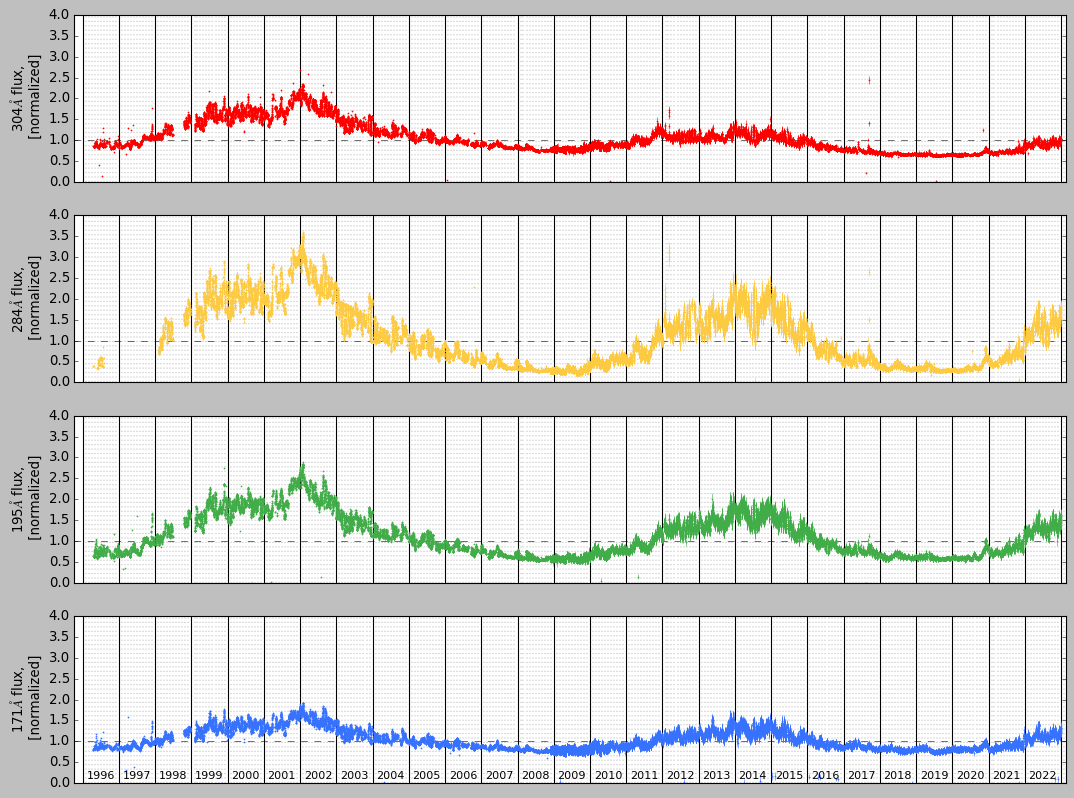

In [53]:
# Mission-long LCs
fArrs_to_plot = [f304_corrected_2008onwards, f284_corrected_2008onwards_bakeoutlineup, f195_corrected_2008onwards_bakeoutlineup, f171_corrected_2008onwards_bakeoutlineup]
uArrs_to_plot = [u304_corrected_2008onwards, u284_corrected_2008onwards_bakeoutlineup, u195_corrected_2008onwards_bakeoutlineup, u171_corrected_2008onwards_bakeoutlineup]
tArrs_to_plot = [t304, t284, t195, t171]
labels = ['304', '284', '195', '171']

cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(16,12))


for i, y in enumerate(np.arange(1996,2024)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    if y < 2023:
        axes[3].text(jan1_thisyear + 180., 0.1, str(y),horizontalalignment='center',fontsize=10)

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)
    ax.axhline(1, color='k', ls = '--', lw=0.5, zorder=1)


for i, ax in enumerate(axes):

    fluxnorm = np.median(fArrs_to_plot[i])

    plotcolor = cs[i]
    axes[i].errorbar(tArrs_to_plot[i],fArrs_to_plot[i]/fluxnorm, yerr=uArrs_to_plot[i]/fluxnorm, ls='None', elinewidth=0.5, capsize=0, marker='.',ms=2,c=plotcolor)
    #axes[i].plot(tArrs_to_plot[i],fArrs_to_plot[i]/fluxnorm, ls='None', marker='.',ms=2,c=plotcolor)
    
    #axes[i].plot(ts[wmask], 0.3*np.ones_like(ts[wmask]), marker='|',ms=20,mec=plotcolor,ls='None')
    #axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" [normalized]".format(labels[i]))

for ax in axes:
    ax.set_xticks([])

    #ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    #ax.set_ylim(0.5,2.0)
    ax.set_xlim(2450000, 2460000)
    #ax.set_xlim(2454045, 2454049)
    #ax.axvline(2454047.950787)
    #ax.axvline(2454048.950787)
    
    '''
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    '''
#axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)

axes[0].set_ylim(0.,4.0)
axes[1].set_ylim(0.,4.0)
axes[2].set_ylim(0.,4.0)
axes[3].set_ylim(0.,4.0)

#plt.subplots_adjust(hspace=0.05)
#plt.show()
plt.savefig("./EIT_LCs_fullmission_systematicscorrected2008onwards.pdf", bbox_inches="tight")

# Now, re-run everything from the straight line fit onwards for the full-baseline corrected data (rather than for 2008 onwards)

/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


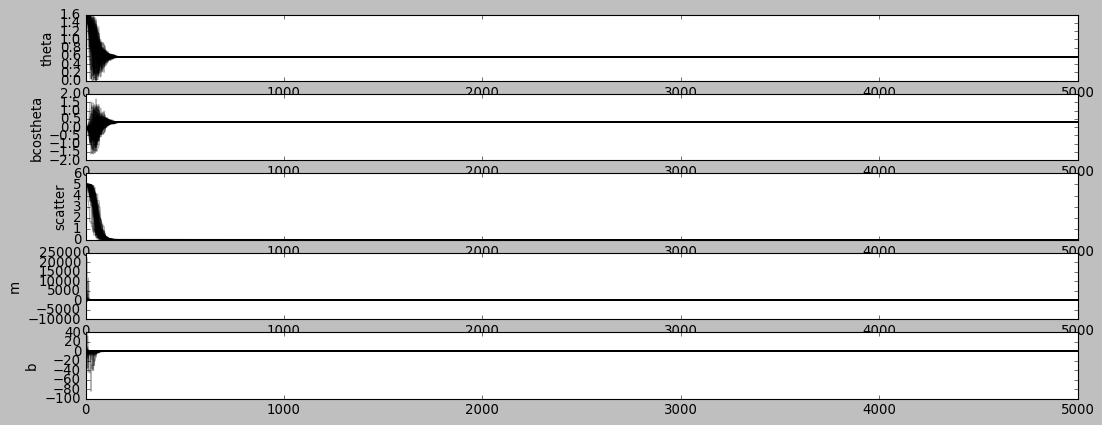

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.637114


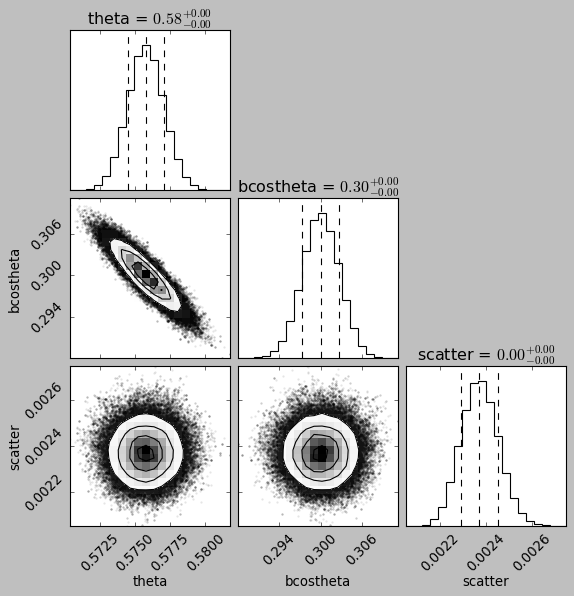

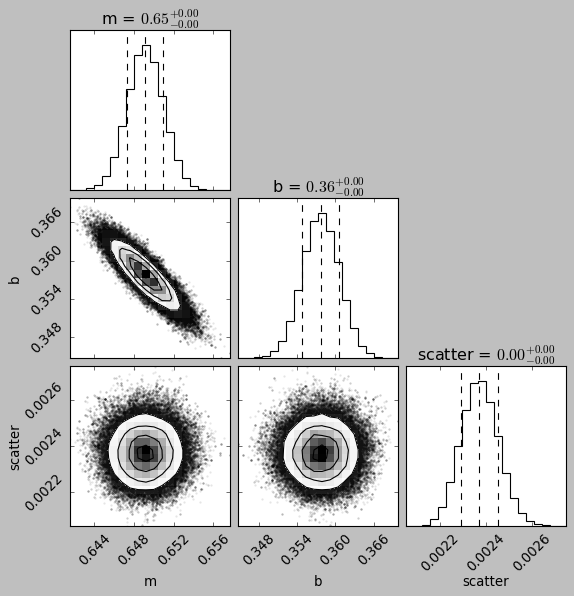

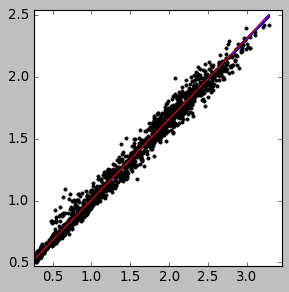

/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


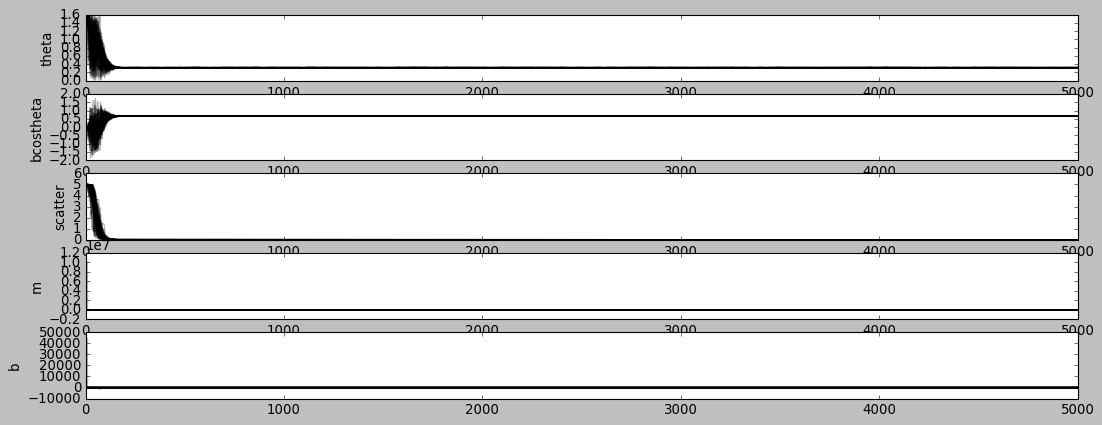

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.6372680000000001


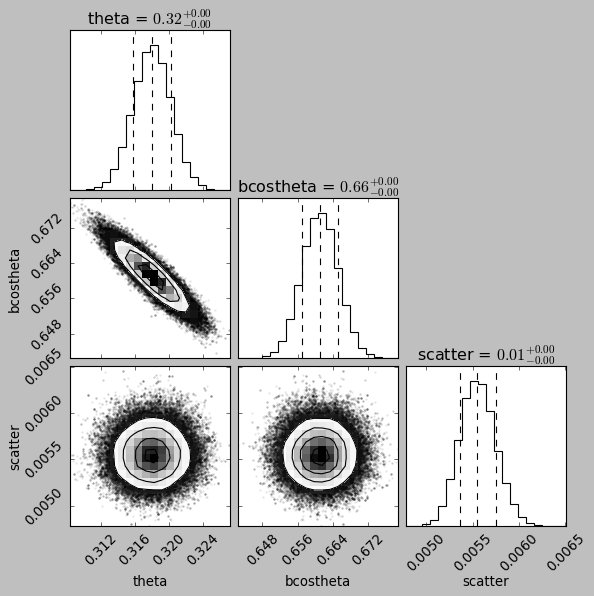

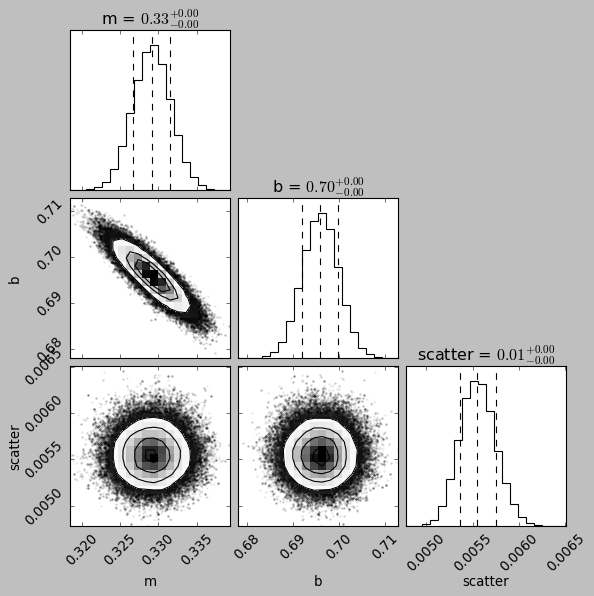

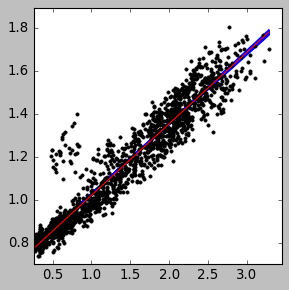

/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


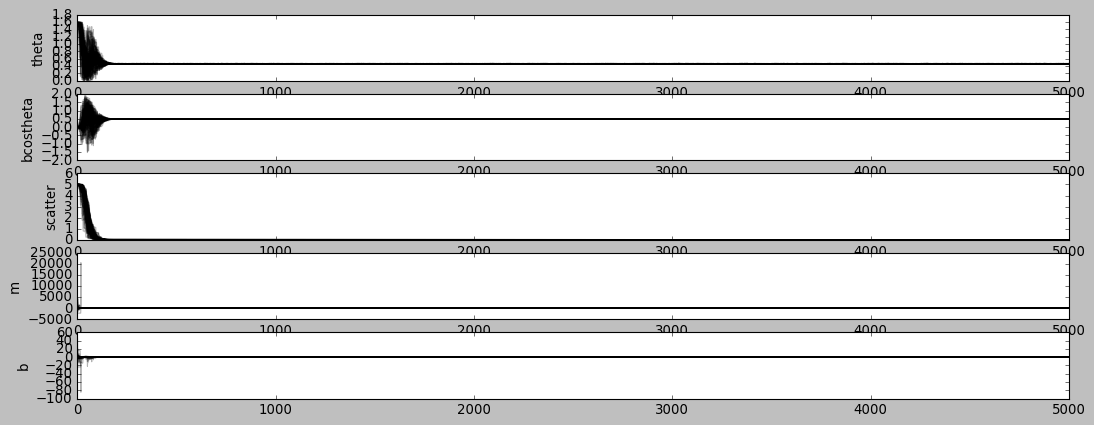

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.636536


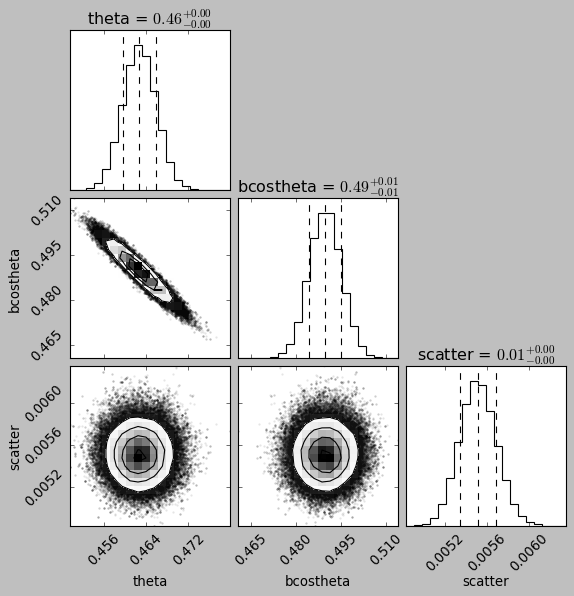

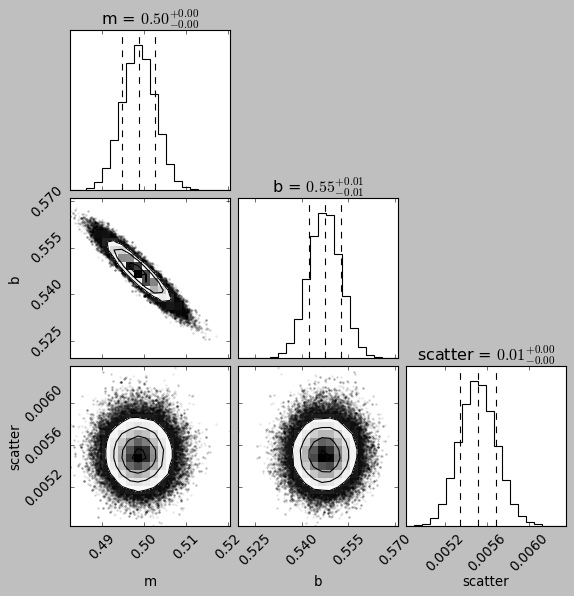

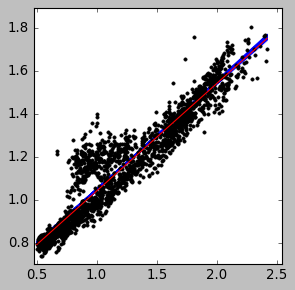

In [54]:
fArrs_to_plot = [f304_corrected_all, f284_corrected_all, f195_corrected_all, f171_corrected_all]
uArrs_to_plot = [u304_corrected_all, u284_corrected_all, u195_corrected_all, u171_corrected_all]
tArrs_to_plot = [t304, t284, t195, t171]


# before Nov 12, 2008 (first obvious bakeout discontinuity)
tstart = t304[0]
tend = 2454783.150532

lp_195_vs_284, lpstats_195_vs_284 = fit2EITBakeoutSegment(t1=t284, f1=f284_corrected_all, u1=u284_corrected_all, t2=t195, f2=f195_corrected_all, u2=u195_corrected_all, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_284, lpstats_171_vs_284 = fit2EITBakeoutSegment(t1=t284, f1=f284_corrected_all, u1=u284_corrected_all, t2=t171, f2=f171_corrected_all, u2=u171_corrected_all, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_195, lpstats_171_vs_195 = fit2EITBakeoutSegment(t1=t195, f1=f195_corrected_all, u1=u195_corrected_all, t2=t171, f2=f171_corrected_all, u2=u171_corrected_all, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

In [55]:
# notation (for comparison with pages 232-239 of lab notebook)
# x = f284
# y = f195
# z = f171

alpha = lpstats_195_vs_284[1,0] # = slope of y vs. x = slope of f195 vs f284
beta  = lpstats_171_vs_284[1,0] # = slope of z vs. x = slope of f171 vs f284
gamma = lpstats_171_vs_195[1,0] # = slope of z vs. y = slope of f171 vs f195

#uncertainties
sigma_alpha = ((lpstats_195_vs_284[1,0] - lpstats_195_vs_284[0,0]) + (lpstats_195_vs_284[2,0] - lpstats_195_vs_284[1,0]))/2
sigma_beta = ((lpstats_171_vs_284[1,0] - lpstats_171_vs_284[0,0]) + (lpstats_171_vs_284[2,0] - lpstats_171_vs_284[1,0]))/2
sigma_gamma = ((lpstats_171_vs_195[1,0] - lpstats_171_vs_195[0,0]) + (lpstats_171_vs_195[2,0] - lpstats_171_vs_195[1,0]))/2

# unit vectors in the new coordinate system wrt the xyz coordinate system. l is parallel to the line of best fit, while j and k are perpendicular to it (and to each other)
j_xyz = (1./(np.sqrt(1 + (gamma**2 * alpha**2))*np.sqrt(1 + alpha**2 * (1 + gamma**2)))) * np.array(( -alpha, 1 + gamma**2 * alpha**2, -gamma * alpha**2 ))
k_xyz = (1./(np.sqrt(1 + gamma**2 * alpha**2))) * np.array((-gamma*alpha, 0, 1))
l_xyz = (1./(np.sqrt(1 + alpha**2 * (1 + gamma**2)))) * np.array((1, alpha, gamma*alpha))
transformation_matrix_xyz_to_jkl = np.vstack((j_xyz, k_xyz, l_xyz))
transformation_matrix_jkl_to_xyz = transformation_matrix_xyz_to_jkl.T


#analytic uncertainty propagation 
j_denom_fac = 1 + (alpha**2) + (2 * alpha**2 * gamma**2) + (gamma**2 * alpha**4) + (gamma**4 * alpha**4)

djx_dalpha = (-1*np.sqrt(j_denom_fac) + (alpha/2)*(j_denom_fac)**(-1/2.) * (2*alpha + 4*alpha*gamma**2 + 4*gamma**2*alpha**3 + 4*gamma**4*alpha**3))/j_denom_fac
djx_dgamma = (alpha * j_denom_fac**(-1./2) * (4*alpha**2 * gamma + 2*gamma*alpha**4 + 4*gamma**3*alpha**4))/j_denom_fac
sigma_jx = np.sqrt( (djx_dalpha*sigma_alpha)**2 + (djx_dgamma*sigma_gamma)**2 )

djy_dalpha = ( (2*alpha*gamma**2)*np.sqrt(j_denom_fac) - (1 + gamma**2 * alpha**2)*0.5*j_denom_fac**(-1./2)*(2*alpha + 4*alpha*gamma**2 + 4*gamma**2*alpha**3 + 4*gamma**4*alpha**3))/j_denom_fac
djy_dgamma = ( (2*gamma*alpha**2)*np.sqrt(j_denom_fac) - (1 + gamma**2 * alpha**2)*0.5*j_denom_fac**(-1./2)*(4*alpha**2 * gamma + 2*gamma*alpha**4 + 4*gamma**3*alpha**4))/j_denom_fac
sigma_jy = np.sqrt( (djy_dalpha*sigma_alpha)**2 + (djy_dgamma*sigma_gamma)**2 )

djz_dalpha = ( (-2*gamma*alpha)*np.sqrt(j_denom_fac) + (gamma*alpha**2)*0.5*j_denom_fac**(-1./2)*(2*alpha + 4*alpha*gamma**2 + 4*gamma**2*alpha**3 + 4*gamma**4*alpha**3))/j_denom_fac
djz_dgamma = ( (-alpha**2)*np.sqrt(j_denom_fac) + (gamma*alpha**2)*0.5*j_denom_fac**(-1./2)*(4*alpha**2 * gamma + 2*gamma*alpha**4 + 4*gamma**3*alpha**4))/j_denom_fac
sigma_jz = np.sqrt( (djz_dalpha*sigma_alpha)**2 + (djz_dgamma*sigma_gamma)**2 )

print(sigma_jx, sigma_jy, sigma_jz)


k_denom_fac = 1 + (gamma**2 * alpha**2)

dkx_dalpha = ( -gamma * np.sqrt(k_denom_fac) + (gamma*alpha)*0.5*k_denom_fac**(-1./2)*(2*gamma**2 *alpha))/k_denom_fac
dkx_dgamma = ( -alpha * np.sqrt(k_denom_fac) + (gamma*alpha)*0.5*k_denom_fac**(-1./2)*(2*alpha**2 *gamma))/k_denom_fac
sigma_kx = np.sqrt( (dkx_dalpha*sigma_alpha)**2 + (dkx_dgamma*sigma_gamma)**2 )

dky_dalpha = 0
dky_dgamma = 0
sigma_ky = np.sqrt( (dky_dalpha*sigma_alpha)**2 + (dky_dgamma*sigma_gamma)**2 )

dkz_dalpha = -1*k_denom_fac**(-3./2) * gamma**2 * alpha
dkz_dgamma = -1*k_denom_fac**(-3./2) * alpha**2 * gamma
sigma_kz = np.sqrt( (dkz_dalpha*sigma_alpha)**2 + (dkz_dgamma*sigma_gamma)**2 )

print(sigma_kx, sigma_ky, sigma_kz)


l_denom_fac = 1 + alpha**2 + (alpha**2 * gamma**2)

dlx_dalpha = -0.5*l_denom_fac**(-3/2.)*(2*alpha + 2*alpha*gamma**2)
dlx_dgamma =  -0.5*l_denom_fac**(-3/2.)*(2*gamma*alpha**2)
sigma_lx = np.sqrt( (dlx_dalpha*sigma_alpha)**2 + (dlx_dgamma*sigma_gamma)**2 )

dly_dalpha = ( np.sqrt(l_denom_fac) - alpha*0.5*l_denom_fac**(-1./2)*(2*alpha + 2*alpha*gamma**2))/l_denom_fac
dly_dgamma = (-alpha*0.5*l_denom_fac**(-1./2)*(2*gamma*alpha**2))/l_denom_fac
sigma_ly = np.sqrt( (dly_dalpha*sigma_alpha)**2 + (dly_dgamma*sigma_gamma)**2 )

dlz_dalpha = ( gamma*np.sqrt(l_denom_fac) - alpha*gamma*0.5*l_denom_fac**(-1./2)*(2*alpha + 2*alpha*gamma**2))/l_denom_fac
dlz_dgamma = ( alpha*np.sqrt(l_denom_fac) - alpha*gamma*0.5*l_denom_fac**(-1./2)*(2*gamma*alpha**2))/l_denom_fac
sigma_lz = np.sqrt( (dlz_dalpha*sigma_alpha)**2 + (dlz_dgamma*sigma_gamma)**2 )

print(sigma_lx, sigma_ly, sigma_lz)


def convert_xyz_to_jkl(xyz_coords, xyz_uncs):
    """
    both arguments are arrays of shape (3, N)
    """
    jkl_coords = np.matmul(transformation_matrix_xyz_to_jkl, xyz_coords)
    jkl_uncs = np.zeros_like(xyz_uncs)
    # j,k,l uncertainty
    jkl_uncs[0] = np.sqrt( xyz_coords[0]**2 * sigma_jx**2 + j_xyz[0]**2 * xyz_uncs[0]**2 + xyz_coords[1]**2 * sigma_jy**2 + j_xyz[1]**2 * xyz_uncs[1]**2 + xyz_coords[2]**2 * sigma_jz**2 + j_xyz[2]**2 * xyz_uncs[2]**2)
    jkl_uncs[1] = np.sqrt( xyz_coords[0]**2 * sigma_kx**2 + k_xyz[0]**2 * xyz_uncs[0]**2 + xyz_coords[1]**2 * sigma_ky**2 + k_xyz[1]**2 * xyz_uncs[1]**2 + xyz_coords[2]**2 * sigma_kz**2 + k_xyz[2]**2 * xyz_uncs[2]**2)
    jkl_uncs[2] = np.sqrt( xyz_coords[0]**2 * sigma_lx**2 + l_xyz[0]**2 * xyz_uncs[0]**2 + xyz_coords[1]**2 * sigma_ly**2 + l_xyz[1]**2 * xyz_uncs[1]**2 + xyz_coords[2]**2 * sigma_lz**2 + l_xyz[2]**2 * xyz_uncs[2]**2)
    return jkl_coords, jkl_uncs

def convert_jkl_to_xyz(jkl_coords, jkl_uncs):
    """
    both arguments are arrays of shape (3, N)
    """
    xyz_coords = np.matmul(transformation_matrix_jkl_to_xyz, jkl_coords)
    xyz_uncs = np.zeros_like(jkl_uncs)
    xyz_uncs[0] = np.sqrt( jkl_coords[0]**2 * sigma_jx**2 + j_xyz[0]**2 * jkl_uncs[0]**2 + jkl_coords[1]**2 * sigma_kx**2 + k_xyz[0]**2 * jkl_uncs[1]**2 + jkl_coords[2]**2 * sigma_lx**2 + l_xyz[0]**2 * jkl_uncs[2]**2 )
    xyz_uncs[1] = np.sqrt( jkl_coords[0]**2 * sigma_jy**2 + j_xyz[1]**2 * jkl_uncs[0]**2 + jkl_coords[1]**2 * sigma_ky**2 + k_xyz[1]**2 * jkl_uncs[1]**2 + jkl_coords[2]**2 * sigma_ly**2 + l_xyz[1]**2 * jkl_uncs[2]**2 )
    xyz_uncs[2] = np.sqrt( jkl_coords[0]**2 * sigma_jz**2 + j_xyz[2]**2 * jkl_uncs[0]**2 + jkl_coords[1]**2 * sigma_kz**2 + k_xyz[2]**2 * jkl_uncs[1]**2 + jkl_coords[2]**2 * sigma_lz**2 + l_xyz[2]**2 * jkl_uncs[2]**2 )
    return xyz_coords, xyz_uncs

0.0015162556319558208 0.0006220581582303269 0.0012861895717284687
0.0023450931205557355 0.0 0.0007592721177935856
0.0008984767849370663 0.001007283152433254 0.0019945328655100376


In [56]:
#need to rerun this cell in conjunction with a new straight-line fit to the beginning of the time series based on fEIT_corrected_all rather than fEIT_corrected_2008onwards

# new arrays to work with for whole time series
f284_corrected_all_bakeoutlineup = copy.deepcopy(f284_corrected_all)
u284_corrected_all_bakeoutlineup = copy.deepcopy(u284_corrected_all)
f195_corrected_all_bakeoutlineup = copy.deepcopy(f195_corrected_all)
u195_corrected_all_bakeoutlineup = copy.deepcopy(u195_corrected_all)
f171_corrected_all_bakeoutlineup = copy.deepcopy(f171_corrected_all)
u171_corrected_all_bakeoutlineup = copy.deepcopy(u171_corrected_all)


# values that the flux and uncertainty arrays were normalized by before the straight-line fit to pre-Nov 12, 2008 was done
f284_norm_all = np.median(f284_corrected_all)
f195_norm_all = np.median(f195_corrected_all)
f171_norm_all = np.median(f171_corrected_all)
#print(f284_norm, f195_norm, f171_norm)

for j in range(80):
    tstart = heaterOff[j]['jd']
    tend = heaterOn[j+1]['jd']

    #mask out some points in f284 (during a flare? anomalously high) that I suspect are causing problems with the transposition
    if heaterOff[j]['jd'] >= 2455930 and heaterOn[j]['jd'] < 2456110:
        print('here')
        fitMask_t284 = (t284 >= heaterOff[j]['jd']) & (t284 <= heaterOn[j+1]['jd']) & (f284_corrected_all/norm <= 1.75)
    else:
        fitMask_t284 = (t284 >= heaterOff[j]['jd']) & (t284 <= heaterOn[j+1]['jd']) 
    fitMask_t195 = (t195 >= heaterOff[j]['jd']) & (t195 <= heaterOn[j+1]['jd']) 
    fitMask_t171 = (t171 >= heaterOff[j]['jd']) & (t171 <= heaterOn[j+1]['jd'])

    f284_thisbakeout = f284_corrected_all[fitMask_t284]/f284_norm_all
    f195_thisbakeout = f195_corrected_all[fitMask_t195]/f195_norm_all
    f171_thisbakeout = f171_corrected_all[fitMask_t171]/f171_norm_all

    u284_thisbakeout = u284_corrected_all[fitMask_t284]/f284_norm_all
    u195_thisbakeout = u195_corrected_all[fitMask_t195]/f195_norm_all
    u171_thisbakeout = u171_corrected_all[fitMask_t171]/f171_norm_all

    b0_f284 = np.median(f284_thisbakeout)
    b0_f195 = np.median(f195_thisbakeout)
    b0_f171 = np.median(f171_thisbakeout)

    b0_f284_unc = np.mean(u284_thisbakeout) * np.sqrt(np.pi/2)
    b0_f195_unc = np.mean(u195_thisbakeout) * np.sqrt(np.pi/2)
    b0_f171_unc = np.mean(u171_thisbakeout) * np.sqrt(np.pi/2)

    b0_xyz = np.array((b0_f284, b0_f195, b0_f171))
    b0_xyz_unc = np.array((b0_f284_unc, b0_f195_unc, b0_f171_unc))

    b0_jkl, b0_jkl_unc = convert_xyz_to_jkl(b0_xyz, b0_xyz_unc)

    #points on the line of best fit        
    # this is a point on the line, deduced by setting x = 0 and then solving for y and z in the three projected line equations
    l0_xyz = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))
    l0_xyz_unc = np.array((((lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]) +  (lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]))/2.,
                            ((lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]) +  (lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]))/2.,
                            ((lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]) +  (lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]))/2.))

    l0_jkl, l0_jkl_unc = convert_xyz_to_jkl(l0_xyz, l0_xyz_unc)

    # therefore an array of points along the line can be obtained by:
    # (parametric form of the line is (x-x0)/1 = (y-y0)/alpha = (z-z0)/beta )
    t = np.linspace(-10, 10, 10000)
    lp_x = l0_xyz[0] + t
    lp_y = l0_xyz[1] + t*alpha
    lp_z = l0_xyz[2] + t*beta
    lp_xyz = np.vstack((lp_x, lp_y, lp_z))

    lp_xyz_unc = np.zeros_like(lp_xyz)
    lp_xyz_unc[0] = l0_xyz_unc[0]*np.ones_like(lp_xyz_unc[0])
    lp_xyz_unc[1] = np.sqrt(l0_xyz_unc[1]**2  + t**2 * sigma_alpha**2)
    lp_xyz_unc[2] = np.sqrt(l0_xyz_unc[2]**2  + t**2 * sigma_beta**2)

    lp_jkl, lp_jkl_unc = convert_xyz_to_jkl(lp_xyz, lp_xyz_unc)
        
    # find the point on the line that is perpendicularly closest to b0_jkl
    closestIdx = np.argmin(np.abs(lp_jkl[2] - b0_jkl[2]))

    lambda_j = lp_jkl[0,closestIdx] - b0_jkl[0]
    lambda_k = lp_jkl[1,closestIdx] - b0_jkl[1]
    lambda_l = lp_jkl[2,closestIdx] - b0_jkl[2]
    lambda_jkl = np.array((lambda_j, lambda_k, lambda_l))

    lambda_jkl_unc = np.array(( np.sqrt(lp_jkl_unc[0,closestIdx]**2 + b0_jkl_unc[0]**2), np.sqrt(lp_jkl_unc[1,closestIdx]**2 + b0_jkl_unc[1]**2), np.sqrt(lp_jkl_unc[2,closestIdx]**2 + b0_jkl_unc[2]**2) ))

    lambda_xyz, lambda_xyz_unc = convert_jkl_to_xyz(lambda_jkl, lambda_jkl_unc)

    # correct the fluxes
    f284_corr = f284_thisbakeout + lambda_xyz[0]
    f195_corr = f195_thisbakeout + lambda_xyz[1]
    f171_corr = f171_thisbakeout + lambda_xyz[2]

    u284_corr = np.sqrt(u284_thisbakeout**2 + lambda_xyz_unc[0]**2)
    u195_corr = np.sqrt(u195_thisbakeout**2 + lambda_xyz_unc[1]**2)
    u171_corr = np.sqrt(u171_thisbakeout**2 + lambda_xyz_unc[2]**2)
    
    f284_corrected_all_bakeoutlineup[fitMask_t284] = f284_corr*f284_norm_all
    f195_corrected_all_bakeoutlineup[fitMask_t195] = f195_corr*f195_norm_all
    f171_corrected_all_bakeoutlineup[fitMask_t171] = f171_corr*f171_norm_all

    u284_corrected_all_bakeoutlineup[fitMask_t284] = u284_corr*f284_norm_all
    u195_corrected_all_bakeoutlineup[fitMask_t195] = u195_corr*f195_norm_all
    u171_corrected_all_bakeoutlineup[fitMask_t171] = u171_corr*f171_norm_all
    
#final segment, after all bakeouts
fitMask_t284 = (t284 >= heaterOff[-1]['jd']) & (t284 <= t284[-1]) 
fitMask_t195 = (t195 >= heaterOff[-1]['jd']) & (t195 <= t195[-1]) 
fitMask_t171 = (t171 >= heaterOff[-1]['jd']) & (t171 <= t171[-1])

f284_thisbakeout = f284_corrected_all[fitMask_t284]/f284_norm_all
f195_thisbakeout = f195_corrected_all[fitMask_t195]/f195_norm_all
f171_thisbakeout = f171_corrected_all[fitMask_t171]/f171_norm_all

u284_thisbakeout = u284_corrected_all[fitMask_t284]/f284_norm_all
u195_thisbakeout = u195_corrected_all[fitMask_t195]/f195_norm_all
u171_thisbakeout = u171_corrected_all[fitMask_t171]/f171_norm_all

b0_f284 = np.median(f284_thisbakeout)
b0_f195 = np.median(f195_thisbakeout)
b0_f171 = np.median(f171_thisbakeout)

b0_f284_unc = np.mean(u284_thisbakeout) * np.sqrt(np.pi/2)
b0_f195_unc = np.mean(u195_thisbakeout) * np.sqrt(np.pi/2)
b0_f171_unc = np.mean(u171_thisbakeout) * np.sqrt(np.pi/2)

b0_xyz = np.array((b0_f284, b0_f195, b0_f171))
b0_xyz_unc = np.array((b0_f284_unc, b0_f195_unc, b0_f171_unc))

b0_jkl, b0_jkl_unc = convert_xyz_to_jkl(b0_xyz, b0_xyz_unc)

#points on the line of best fit
# this is a point on the line, deduced by setting x = 0 and then solving for y and z in the three projected line equations
l0_xyz = np.array((0, lpstats_195_vs_284[1,1], lpstats_171_vs_284[1,1]))
l0_xyz_unc = np.array((((lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]) +  (lpstats_171_vs_195[1,1] - lpstats_171_vs_195[0,1]))/2.,
                        ((lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]) +  (lpstats_195_vs_284[1,1] - lpstats_195_vs_284[0,1]))/2.,
                        ((lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]) +  (lpstats_171_vs_284[1,1] - lpstats_171_vs_284[0,1]))/2.))

l0_jkl, l0_jkl_unc = convert_xyz_to_jkl(l0_xyz, l0_xyz_unc)

# therefore an array of points along the line can be obtained by:
# (parametric form of the line is (x-x0)/1 = (y-y0)/alpha = (z-z0)/beta )
t = np.linspace(-10, 10, 10000)
lp_x = l0_xyz[0] + t
lp_y = l0_xyz[1] + t*alpha
lp_z = l0_xyz[2] + t*beta
lp_xyz = np.vstack((lp_x, lp_y, lp_z))

lp_xyz_unc = np.zeros_like(lp_xyz)
lp_xyz_unc[0] = l0_xyz_unc[0]*np.ones_like(lp_xyz_unc[0])
lp_xyz_unc[1] = np.sqrt(l0_xyz_unc[1]**2  + t**2 * sigma_alpha**2)
lp_xyz_unc[2] = np.sqrt(l0_xyz_unc[2]**2  + t**2 * sigma_beta**2)

lp_jkl, lp_jkl_unc = convert_xyz_to_jkl(lp_xyz, lp_xyz_unc)
        
# find the point on the line that is perpendicularly closest to b0_jkl
closestIdx = np.argmin(np.abs(lp_jkl[2] - b0_jkl[2]))

lambda_j = lp_jkl[0,closestIdx] - b0_jkl[0]
lambda_k = lp_jkl[1,closestIdx] - b0_jkl[1]
lambda_l = lp_jkl[2,closestIdx] - b0_jkl[2]
lambda_jkl = np.array((lambda_j, lambda_k, lambda_l))

lambda_jkl_unc = np.array(( np.sqrt(lp_jkl_unc[0,closestIdx]**2 + b0_jkl_unc[0]**2), np.sqrt(lp_jkl_unc[1,closestIdx]**2 + b0_jkl_unc[1]**2), np.sqrt(lp_jkl_unc[2,closestIdx]**2 + b0_jkl_unc[2]**2) ))

lambda_xyz, lambda_xyz_unc = convert_jkl_to_xyz(lambda_jkl, lambda_jkl_unc)

# correct the fluxes
f284_corr = f284_thisbakeout + lambda_xyz[0]
f195_corr = f195_thisbakeout + lambda_xyz[1]
f171_corr = f171_thisbakeout + lambda_xyz[2]

u284_corr = np.sqrt(u284_thisbakeout**2 + lambda_xyz_unc[0]**2)
u195_corr = np.sqrt(u195_thisbakeout**2 + lambda_xyz_unc[1]**2)
u171_corr = np.sqrt(u171_thisbakeout**2 + lambda_xyz_unc[2]**2)

f284_corrected_all_bakeoutlineup[fitMask_t284] = f284_corr*f284_norm_all
f195_corrected_all_bakeoutlineup[fitMask_t195] = f195_corr*f195_norm_all
f171_corrected_all_bakeoutlineup[fitMask_t171] = f171_corr*f171_norm_all

u284_corrected_all_bakeoutlineup[fitMask_t284] = u284_corr*f284_norm_all
u195_corrected_all_bakeoutlineup[fitMask_t195] = u195_corr*f195_norm_all
u171_corrected_all_bakeoutlineup[fitMask_t171] = u171_corr*f171_norm_all


here


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


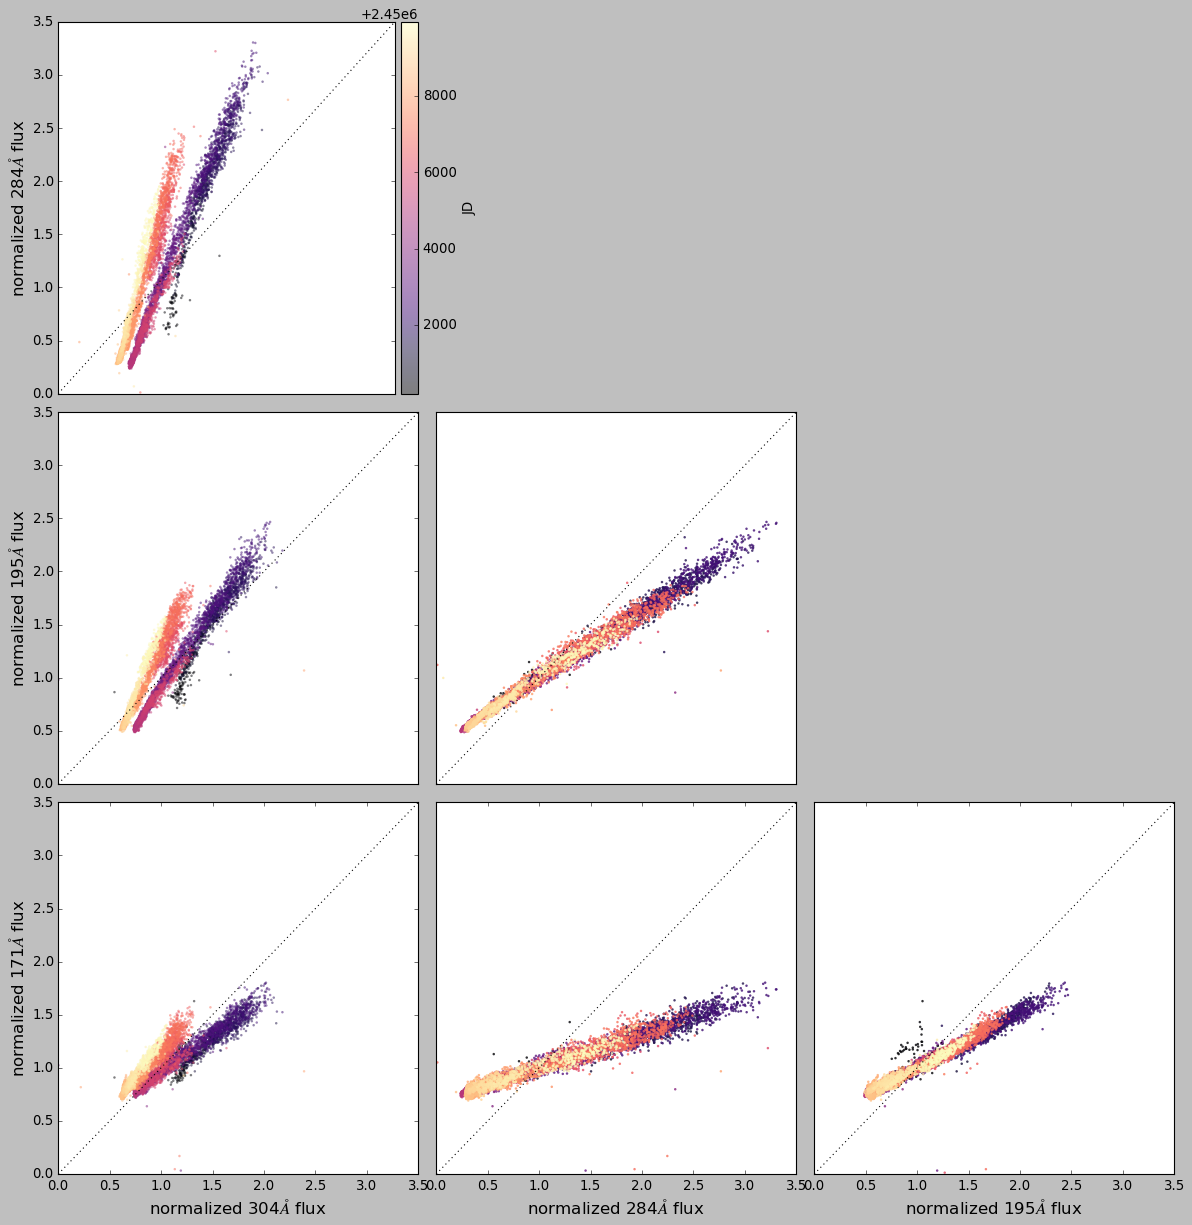

<Figure size 640x480 with 0 Axes>

In [57]:
fArrs_to_plot = [f304_corrected_all, f284_corrected_all_bakeoutlineup, f195_corrected_all_bakeoutlineup, f171_corrected_all_bakeoutlineup]
uArrs_to_plot = [u304_corrected_all, u284_corrected_all_bakeoutlineup, u195_corrected_all_bakeoutlineup, u171_corrected_all_bakeoutlineup]

tArrs_to_plot = [t304, t284, t195, t171]


# nov 12, 2008 (first bakeout with obvious discontinuity)
tsplit_1 = 2454783.150532

tLastBadBakeoutBegins = 2455765.033727

# beginning of f304 first exponential trend
tsplit_exp1 = 2455938.417
# beginning of f304 second exponential trend
tsplit_exp2 = 2457542.583333

fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):

    overlap_t, tEIT_i_ind, t304_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[0],0), return_indices=True)

    split0 = (overlap_t <= tsplit_1)
    split1 = (overlap_t > tLastBadBakeoutBegins) & (overlap_t <= tsplit_exp1)
    split_exp1 = (overlap_t > tsplit_exp1) & (overlap_t <= 2456111.033727)#tsplit_exp2)
    split_exp2 = (overlap_t > tsplit_exp2)
    
    c_s = axes[i-1,0].scatter(fArrs_to_plot[0][t304_ind]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[0][t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.5,zorder=0)

    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split0]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split0]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'k.',zorder=1,alpha=0.1)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'k.',zorder=2,alpha=1)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'b.',zorder=3,alpha=0.4)
    #axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp2]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp2]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'g.',zorder=4,alpha=0.4)
    
   
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="JD")
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"normalized 304$\AA$ flux",fontsize=15)
axes[0,0].set_ylabel(r"normalized 284$\AA$ flux",fontsize=15)
axes[1,0].set_ylabel(r"normalized 195$\AA$ flux",fontsize=15)
axes[2,0].set_ylabel(r"normalized 171$\AA$ flux",fontsize=15)


for i in range(2,4):
    overlap_t, tEIT_i_ind, t284_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[1],0), return_indices=True)
    
    axes[i-1,1].scatter(fArrs_to_plot[1][t284_ind]/np.median(fArrs_to_plot[1][~np.isnan(fArrs_to_plot[1])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[1][t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"normalized 284$\AA$ flux",fontsize=15)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    overlap_t, tEIT_i_ind, t195_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[2],0), return_indices=True)
    
    axes[i-1,2].scatter(fArrs_to_plot[2][t195_ind]/np.median(fArrs_to_plot[2][~np.isnan(fArrs_to_plot[2])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[2][t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"normalized 195$\AA$ flux",fontsize=15)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.plot(np.arange(5),np.arange(5),color='k',ls=':')

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])

plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

plt.savefig("./ratio_EITbands_to_eachother_all_bakeoutlineup.pdf",bbox_inches="tight")
#plt.show()

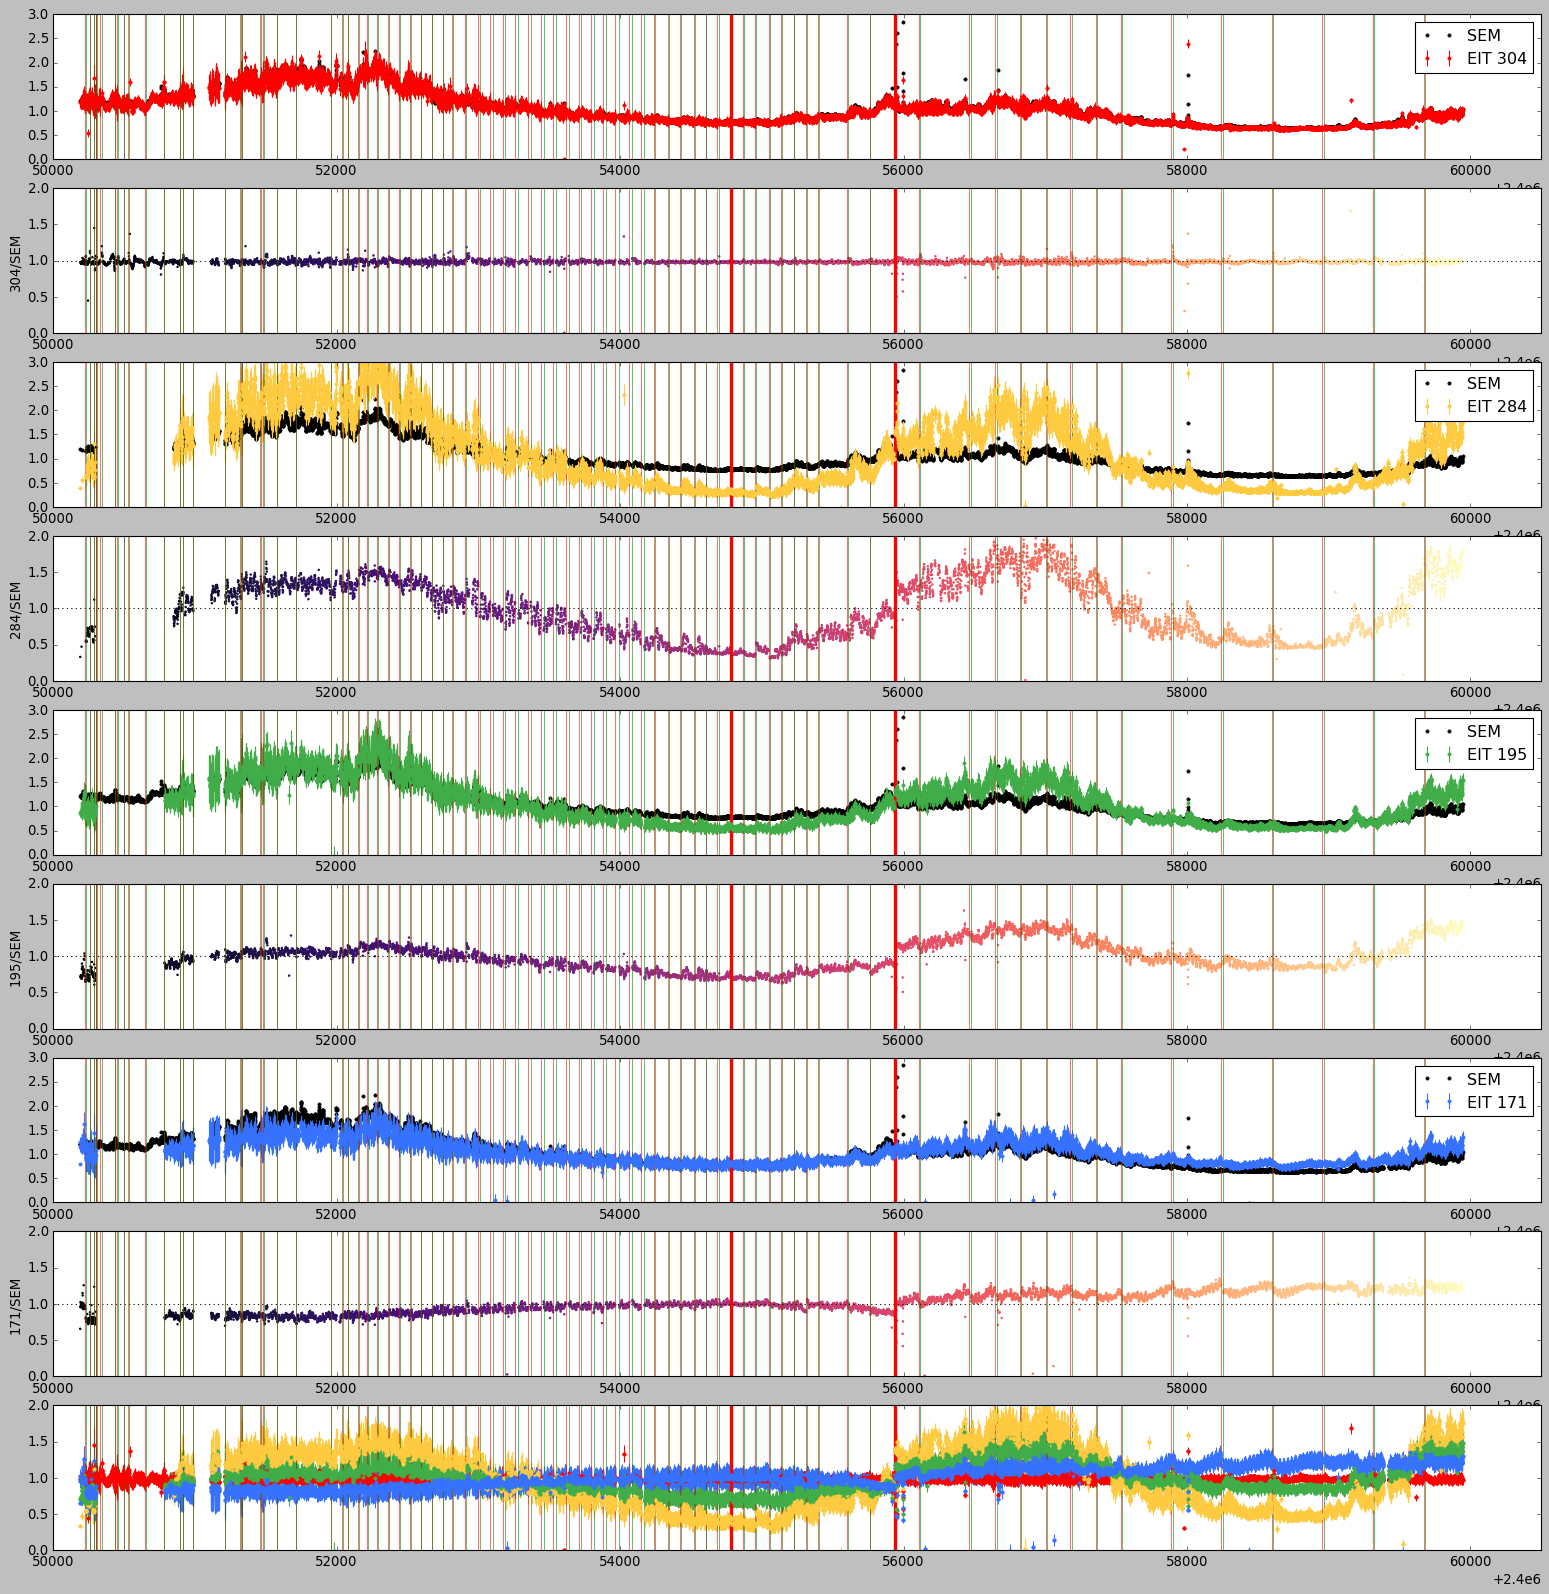

In [58]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    tEIT = tArrs_to_plot[i]
    fEIT = fArrs_to_plot[i]
    uEIT = uArrs_to_plot[i]

    overlap_t, tEIT_ind, tSEM_ind = np.intersect1d(np.round(tEIT,0), np.round(tSEM,0), return_indices=True)
    axes[2*i].plot(tSEM[tSEM_ind], fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)]), 'k.',label='SEM')
    axes[2*i].errorbar(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]),capsize=0,elinewidth=1)
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].scatter(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),c=tEIT[tEIT_ind], marker='.',cmap='magma',edgecolor='None')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),marker='.',ls='None',color=cs[i])
    axes[8].errorbar(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),yerr=(uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),marker='.',ls='None',elinewidth=1,capsize=0,color=cs[i])
    
    axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

    #ax.axvline(2455406.162303, color='r',lw=3) #end of bakeout July 28 2010
    #ax.axvline(2455609.162303, color='r',lw=3) #end of bakeout 16 Feb 2011

    ax.axvline(2454783.150532, color='r', lw=3) #Nov 12, 2008
    ax.axvline(2455938.417, color='r', lw=3) # Jan 11, 2012, beginning of first 304 exponential trend, end of obvious bakeout offsets

#plt.show()
plt.savefig("./ratio_EITbands_to_SEM1stOrder_all_bakeoutlineup.pdf",bbox_inches="tight")

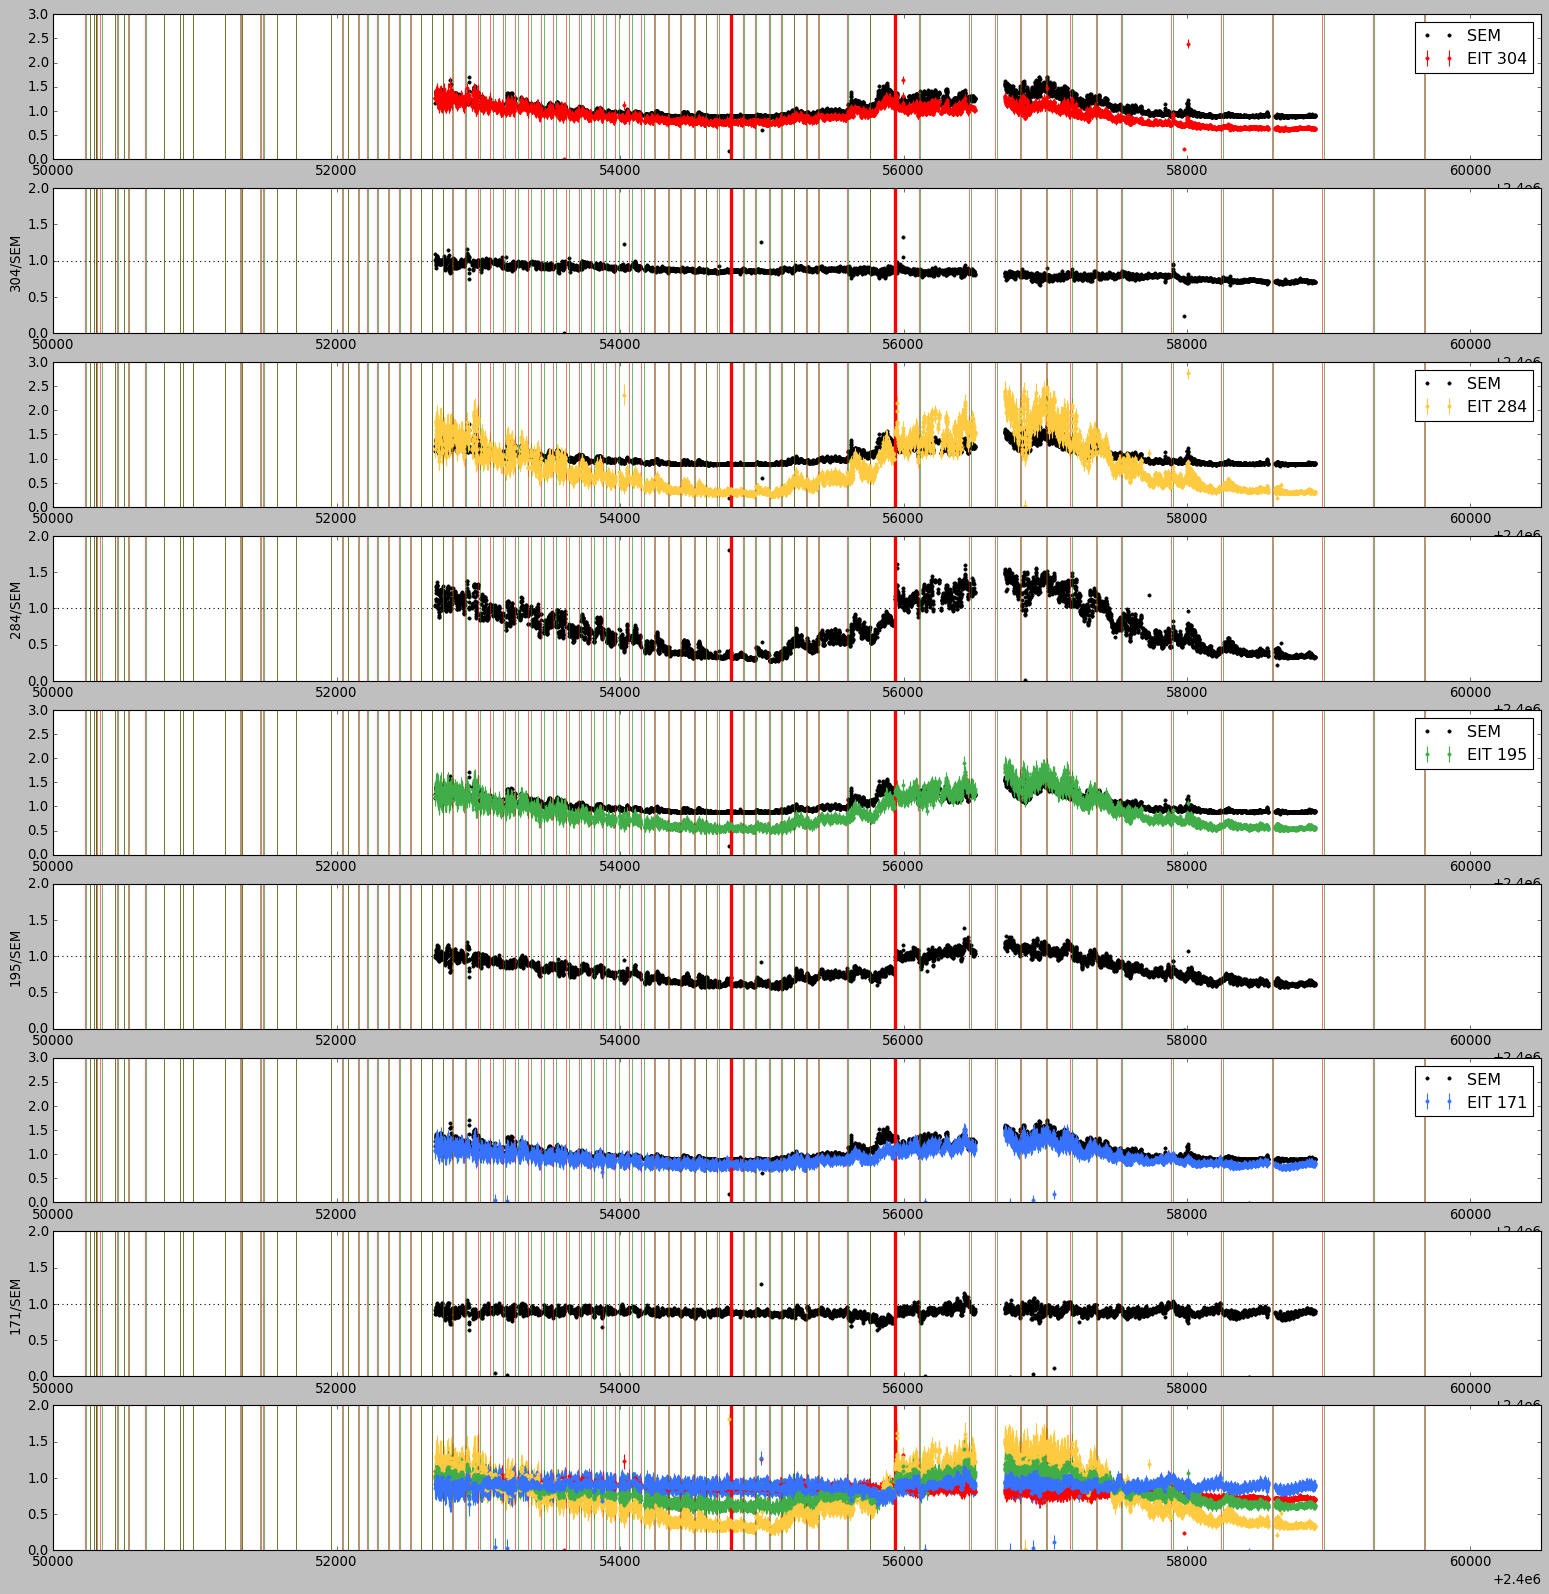

In [59]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    tEIT = tArrs_to_plot[i]
    fEIT = fArrs_to_plot[i]
    uEIT = uArrs_to_plot[i]

    overlap_t, tEIT_ind, tSORCE_ind = np.intersect1d(np.round(tEIT,0), np.round(tSORCE,0), return_indices=True)
    axes[2*i].plot(tSORCE[tSORCE_ind], fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)]), 'k.',label='SEM')
    axes[2*i].errorbar(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]),capsize=0,elinewidth=1)
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),'k.')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))

    axes[8].errorbar(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])), (uEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)])), marker='.',ls='None',color=cs[i],capsize=0,elinewidth=1)
    axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

    ax.axvline(2454783.150532, color='r', lw=3) #Nov 12, 2008
    ax.axvline(2455938.417, color='r', lw=3) # Jan 11, 2012, beginning of first 304 exponential trend, end of obvious bakeout offsets


#plt.show()
plt.savefig("./ratio_EITbands_to_SORCE_all_bakeoutlineup.pdf",bbox_inches="tight")

In [60]:
toSave_304_all = np.vstack((t304, f304_corrected_all, u304_corrected_all, beforeBakeout_304, afterBakeout_304)).T
toSave_284_all = np.vstack((t284, f284_corrected_all_bakeoutlineup, u284_corrected_all_bakeoutlineup, beforeBakeout_284, afterBakeout_284)).T
toSave_195_all = np.vstack((t195, f195_corrected_all_bakeoutlineup, u195_corrected_all_bakeoutlineup, beforeBakeout_195, afterBakeout_195)).T
toSave_171_all = np.vstack((t171, f171_corrected_all_bakeoutlineup, u171_corrected_all_bakeoutlineup, beforeBakeout_171, afterBakeout_171)).T


In [61]:
np.savetxt("./EIT/EIT304_LC_corrected_all.txt", toSave_304_all, fmt='%f %f %f %d %d', delimiter=' ', header=header)
np.savetxt("./EIT/EIT284_LC_corrected_all.txt", toSave_284_all, fmt='%f %f %f %d %d', delimiter=' ', header=header)
np.savetxt("./EIT/EIT195_LC_corrected_all.txt", toSave_195_all, fmt='%f %f %f %d %d', delimiter=' ', header=header)
np.savetxt("./EIT/EIT171_LC_corrected_all.txt", toSave_171_all, fmt='%f %f %f %d %d', delimiter=' ', header=header)